Extract biometrics from segmentation results

## Metadata

Age, Sex, Height, Weight, BMI (= weight/height² [kg/m²])

In [ ]:
import SimpleITK as sitk
import sys, os, glob
import pydicomext as pydcm
from pydicom.fileset import FileSet
from deid.data import get_dataset
from deid.dicom import get_files, get_identifiers
from pathlib import Path

input_path = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/non_labeled_dataset/'

# List of volumes for each individual label and subject
len_path = len([elem for elem in os.listdir(input_path)])
name_subject = [None]*len_path
age_subject = [None]*len_path
sex_subject = [None]*len_path
height_subject = [None]*len_path
weight_subject = [None]*len_path
bmi_subject = [None]*len_path

# Create sorted list
i=0
list_subs = [None]*len_path
for folder1 in sorted(os.listdir(input_path)):
    list_subs[i] = folder1
    i+=1

# Start subloop from specific subject (0 if it's from the beginning)
index_sub = list_subs.index('2022160103683') # index_sub = 0 # if it's from the beginning
print(f'subject index: {index_sub}')

# Loop sublist
k=0
for j in range(index_sub, len_path):

    dicom_folder = f'{input_path}{list_subs[j]}/I_Kopf_t1_mpr_tra_iso_p2/'
    dicom_files = sorted(glob.glob(os.path.join(dicom_folder, "*.dcm")))
    ids = get_identifiers(dicom_files)

    # print(ids[dicom_files[0]].keys())

    # ID
    field_id = ids[dicom_files[0]]['(0010, 0020)']
    id = field_id.element.value
    name_subject[j] = id
    print(f'subject: {id}')

    # Sex
    field_sex = ids[dicom_files[0]]['(0010, 0040)']
    sex = field_sex.element.value
    sex_subject[j] = sex
    print(f'sex: {sex}')
    # name = field_sex.name
    # uid = field_sex.uid

    # Age
    field_age = ids[dicom_files[0]]['(0010, 1010)']
    age = field_age.element.value
    age = age[1:3]
    age_subject[j] = age
    print(f'age: {age}')

    # Height
    try:
        field_height = ids[dicom_files[0]]['(0010, 1020)']
        height = field_height.element.value
        height_subject[j] = height
    except KeyError:
        field_height = None
        height = None
        height_subject[j] = None
    print(f'height: {height} m')

    # Weight
    field_weight = ids[dicom_files[0]]['(0010, 1030)']
    weight = field_weight.element.value
    weight_subject[j] = weight
    print(f'weight: {weight} kg')

    # BMI (kg/m²)
    if height != None:
        bmi_subject[j] = weight / (height**2)
    print(f'BMI: {bmi_subject[j]} kg/m²')

    k+=1
    # if k==1:
    #     break

Save values to .csv

In [ ]:
import csv
import numpy as np

column_names = ['Subject','Sex','Age','Height','Weight','BMI']
vals = np.array([name_subject, sex_subject, age_subject, height_subject, weight_subject, bmi_subject])
vals = vals.T
vals = vals[index_sub:]

if index_sub != 0:
    # Reader
    with open('/mnt/sda1/Repos/a-eye/Output/sub_metadata.csv', 'r') as read_file:
        reader = csv.reader(read_file)
        lines = list(reader)
        lines = lines[0:index_sub+1]
        lines.extend(list(vals))
# Writer
with open('/mnt/sda1/Repos/a-eye/Output/sub_metadata.csv', 'w') as write_file:
    writer = csv.writer(write_file)
    if index_sub==0: # only writing columns if not starting from the first subject
        writer.writerow(column_names)
        lines = vals
    writer.writerows(lines)

read_file.close()
write_file.close()

### Read values from.csv

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px

csv_file = '/mnt/sda1/Repos/a-eye/Output/metadata/sub_metadata.csv'
pd_csv = pd.read_csv(csv_file)

# Data from .csv
sex_csv = np.array([pd_csv["Sex"]], dtype='<U7')
age_csv = np.array([pd_csv["Age"]])
num_males = np.count_nonzero(np.char.count(sex_csv, "M"))
num_females = np.count_nonzero(np.char.count(sex_csv, "F"))

print(f'mean age is: {np.around(np.mean(age_csv), 1)}, std: {int(np.std(age_csv))}, min age is: {np.amin(age_csv)}, max age is: {np.amax(age_csv)}')
print(f'men: {num_males}, women: {num_females}')

# Sex group using pandas
sex_group = pd_csv.groupby(["Sex"], dropna=True)

# Print sex group
# for name, group in sex_group:
#     print(name)
#     print(group)

# Male group
male_group = sex_group.get_group("M").dropna() # group by male and remove NaN values
bmi_male = np.array([male_group["BMI"]])
mean_bmi_male = np.around(np.mean(bmi_male), decimals=1)
std_bmi_male = np.around(np.std(bmi_male), decimals=1)
underweight_male = np.count_nonzero(bmi_male<18.5)
non_overweight_male = np.count_nonzero(np.logical_and(18.5<=bmi_male, bmi_male<25))
overweight_male = np.count_nonzero(np.logical_and(25<=bmi_male, bmi_male<30))
obese_male = np.count_nonzero(bmi_male>=30)
print(f'- MALES ({male_group.shape[0]}): \n     BMI = {np.around(mean_bmi_male, 1)} +- {np.around(std_bmi_male, 1)} kg/m² \
Underweight: {underweight_male}; Non-overweight: {non_overweight_male}; Overweight: {overweight_male}; Obese: {obese_male}')

# Female group
female_group = sex_group.get_group("F").dropna() # group by female and remove NaN values (there is one that has no height)
bmi_female = np.array([female_group["BMI"]])
mean_bmi_female = np.around(np.mean(bmi_female), decimals=1)
std_bmi_female = np.around(np.std(bmi_female), decimals=1)
underweight_female = np.count_nonzero(bmi_female<18.5)
non_overweight_female = np.count_nonzero(np.logical_and(18.5<=bmi_female, bmi_female<25))
overweight_female = np.count_nonzero(np.logical_and(25<=bmi_female, bmi_female<30))
obese_female = np.count_nonzero(bmi_female>=30)
print(f'- FEMALES ({female_group.shape[0]}): \n     BMI = {np.around(mean_bmi_female, 1)} +- {np.around(std_bmi_female, 1)} kg/m² \
Underweight: {underweight_female}; Non-overweight: {non_overweight_female}; Overweight: {overweight_female}; Obese: {obese_female}')

# Total
print(f'- TOTAL ({male_group.shape[0] + female_group.shape[0]}): \n     Underweight: {underweight_female + underweight_male}; \
Non-overweight: {non_overweight_female + non_overweight_male}; Overweight: {overweight_female + overweight_male}; \
Obese: {obese_female + obese_male}')


# PLOT #

# Sex
fig1 = plt.figure(figsize=(5,5))
fig1.patch.set_facecolor('white')
plt.bar(('Males', 'Females'), (num_males, num_females))
plt.xlabel('Sex')
plt.ylabel('Number of subjects')
plt.title(f'Number of subjects grouped by sex ({num_males+num_females} subjects)')
plt.show()
# plt.savefig('/mnt/sda1/Repos/a-eye/Output/sex_bargraph.png')

# Age
age_counts = pd_csv["Age"].value_counts()
fig2 = px.bar(age_counts, title=f'Distribution of age ({num_males+num_females} subjects)')
fig2.update_layout(
    xaxis_title = 'Age',
    yaxis_title = 'Frequency',
    title_x = 0.5,
    showlegend = False
)
fig2.show()
fig2.write_image('/mnt/sda1/Repos/a-eye/Output/age_bargraph.png')

# BMI
bmi_labels = ('Underweight', 'Non-overweight', 'Overweight', 'Obese')
bmi_percentages_male = np.array([underweight_male, non_overweight_male, overweight_male, obese_male]) / male_group.shape[0]
bmi_percentages_female = np.array([underweight_female, non_overweight_female, overweight_female, obese_female]) / female_group.shape[0]
bmi_colors = ('tab:red','tab:blue','tab:orange','tab:green')
fig3, axs3 = plt.subplots(1, 2, figsize=(10, 5))
fig3.patch.set_facecolor('white')
fig3.suptitle(f'BMI classification ({num_males+num_females} subjects)')
axs3[0].pie(bmi_percentages_male, labels=bmi_labels, startangle=45, colors=bmi_colors, autopct='%1.1f%%')
axs3[0].axis('equal'), axs3[0].set_title(f'Males ({male_group.shape[0]})')
axs3[1].pie(bmi_percentages_female, labels=bmi_labels, startangle=45, colors=bmi_colors, autopct='%1.1f%%')
axs3[1].axis('equal'), axs3[1].set_title(f'Females ({female_group.shape[0]})')
plt.show()
# plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_piechart.png')


## Volumetry

Literature

In [ ]:
from cmath import pi

# Measures
# GLOBE
# The means for the horizontal and vertical diameters are 24.26 ± 0.96 mm (n = 518) and 24.16 ± 0.97 mm (n = 510), respectively.
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3432692/#:~:text=In%20the%20adult%2C%20the%20spherical,11.8%20and%2011.2%20mm%2C%20respectively
globe_avg_diameter = 24.2 # mm
globe_avg_volume = 4/3*pi*((globe_avg_diameter/2)**3) # mm³
print(globe_avg_volume)

Compute volumes

In [ ]:
import os, glob
import numpy as np
import nibabel as nb

METHOD = 'dl'

# Paths - segmentation results
if METHOD=='reg':
    main_path = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/'
    input_path = main_path + 'non_labeled_dataset_nifti_reg_2/'
elif METHOD=='dl':
    main_path = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/deep_learning/nnUNet/nnUNet/nnUNet_inference/'
    input_path = main_path + 'no_postprocessing/'

# List of volumes for each individual label and subject
len_path = len([elem for elem in glob.glob(f'{input_path}*.nii.gz')])
name_subject = ['' for _ in range(len_path)]
vol_lens = np.zeros(len_path)
vol_globe = np.zeros(len_path)
vol_nerve = np.zeros(len_path)
vol_int_fat = np.zeros(len_path)
vol_ext_fat = np.zeros(len_path)
vol_lat_mus = np.zeros(len_path)
vol_med_mus = np.zeros(len_path)
vol_inf_mus = np.zeros(len_path)
vol_sup_mus = np.zeros(len_path)
vol_total = np.zeros(len_path)

i=0
# for folder1 in sorted(os.listdir(input_path)):
for file in sorted(glob.glob(f'{input_path}*.nii.gz')):
    
    # Subject's name
    basename = os.path.basename(file)
    if METHOD=='reg': name_subject[i] = basename
    elif METHOD=='dl': name_subject[i] = basename.split('_')[1].split('.')[0]
    print(f'subject: {name_subject[i]}')

    # Load image in array format
    if METHOD=='reg': 
        lab_arr = nb.load(file).get_fdata()
    elif METHOD=='dl': 
        lab_arr = nb.load(file).get_fdata()
        lab_arr = lab_arr[int(np.around(lab_arr.shape[0]/2)):lab_arr.shape[0], int(np.around(lab_arr.shape[1]/2)):lab_arr.shape[1], 0:lab_arr.shape[2]] # quadrant right eye

    # # plot lab_arr in 3D -  to check we are in the right quadrant, for nnUNet case
    # from matplotlib import pyplot as plt
    # from mpl_toolkits.mplot3d import Axes3D
    # fig = plt.figure(figsize=(10,10))
    # ax = fig.add_subplot(111, projection='3d')
    # ax.voxels(lab_arr, edgecolor='k')
    # plt.show()

    # Total volumetry of the subject's eye
    total_vol = np.count_nonzero(lab_arr)
    vol_total[i] = total_vol # / total_vol
    print(f'Total volume of the eye: {total_vol} mm³')

    # Lens
    vol_lens[i] = np.count_nonzero(lab_arr==1) # / total_vol
    print(f'lens {vol_lens[i]}')

    # Globe
    vol_globe[i] = np.count_nonzero(lab_arr==2) # / total_vol
    print(f'globe {vol_globe[i]}')

    # Nerve
    vol_nerve[i] = np.count_nonzero(lab_arr==3) # / total_vol
    print(f'nerve {vol_nerve[i]}')

    # Intraconal fat
    vol_int_fat[i] = np.count_nonzero(lab_arr==4) # / total_vol
    print(f'intraconal fat {vol_int_fat[i]}')

    # Extraconal fat
    vol_ext_fat[i] = np.count_nonzero(lab_arr==5) # / total_vol
    print(f'extraconal fat {vol_ext_fat[i]}')

    # Lateral rectus muscle
    vol_lat_mus[i] = np.count_nonzero(lab_arr==6) # / total_vol
    print(f'lateral rectus muscle {vol_lat_mus[i]}')

    # Medial rectus muscle
    vol_med_mus[i] = np.count_nonzero(lab_arr==7) # / total_vol
    print(f'medial rectus muscle {vol_med_mus[i]}')

    # Inferior rectus muscle
    vol_inf_mus[i] = np.count_nonzero(lab_arr==8) # / total_vol
    print(f'medial rectus muscle {vol_inf_mus[i]}')

    # Superior rectus muscle
    vol_sup_mus[i] = int(np.count_nonzero(lab_arr==9)) # / total_vol
    print(f'superior rectus muscle {vol_sup_mus[i]}\n')

    i+=1
    # if i==1:
    #     break

Save values into .csv

In [ ]:
import csv

if METHOD=='reg': filename = 'volumes_reg_total.csv'
elif METHOD=='dl': filename = 'volumes_nnunet_right_eye.csv'

column_names = ['Subject','vol_lens','vol_globe','vol_nerve','vol_int_fat','vol_ext_fat','vol_lat_mus','vol_med_mus','vol_inf_mus','vol_sup_mus','vol_total']
vals = np.array([name_subject, vol_lens, vol_globe, vol_nerve, vol_int_fat, vol_ext_fat, vol_lat_mus, vol_med_mus, vol_inf_mus, vol_sup_mus, vol_total])
vals = vals.T
with open('/mnt/sda1/Repos/a-eye/Output/volumetry/nnunet/' + filename, 'w') as file:
    writer = csv.writer(file)
    writer.writerow(column_names)
    writer.writerows(vals)

Read values from .csv

In [ ]:
import numpy as np
from turtle import color
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

METHOD = 'dl'

if METHOD=='reg':
    main_path = '/mnt/sda1/Repos/a-eye/Output/volumetry/atlas/'
    filename = 'volumes_reg_total.csv'
elif METHOD=='dl':
    main_path = '/mnt/sda1/Repos/a-eye/Output/volumetry/nnunet/'
    filename = 'volumes_nnunet_right_eye.csv'

df_vol = pd.read_csv(main_path + filename)

# lens
vol_lens = np.array([df_vol["vol_lens"]])
vol_lens = vol_lens[vol_lens != 0] # drop 0 values
print(f'lens - mean: {np.mean(vol_lens)}, std: {np.std(vol_lens)}')

# globe
vol_globe = np.array([df_vol["vol_globe"]])
vol_globe = vol_globe[vol_globe != 0] # drop 0 values
print(f'globe - mean: {np.mean(vol_globe)}, std: {np.std(vol_globe)}')

# nerve
vol_nerve = np.array([df_vol["vol_nerve"]])
vol_nerve = vol_nerve[vol_nerve != 0] # drop 0 values
print(f'nerve - mean: {np.mean(vol_nerve)}, std: {np.std(vol_nerve)}')

# intraconal fat
vol_int_fat = np.array([df_vol["vol_int_fat"]])
vol_int_fat = vol_int_fat[vol_int_fat != 0] # drop 0 values
print(f'intraconal fat - mean: {np.mean(vol_int_fat)}, std: {np.std(vol_int_fat)}')

# extraconal fat
vol_ext_fat = np.array([df_vol["vol_ext_fat"]])
vol_ext_fat = vol_ext_fat[vol_ext_fat != 0] # drop 0 values
print(f'extraconal fat - mean: {np.mean(vol_ext_fat)}, std: {np.std(vol_ext_fat)}')

# lateral rectus muscle
vol_lat_mus = np.array([df_vol["vol_lat_mus"]])
vol_lat_mus = vol_lat_mus[vol_lat_mus != 0] # drop 0 values
print(f'lateral rectus muscle - mean: {np.mean(vol_lat_mus)}, std: {np.std(vol_lat_mus)}')

# medial rectus muscle
vol_med_mus= np.array([df_vol["vol_med_mus"]])
vol_med_mus = vol_med_mus[vol_med_mus != 0] # drop 0 values
print(f'medial rectus muscle - mean: {np.mean(vol_med_mus)}, std: {np.std(vol_med_mus)}')

# inferior rectus muscle
vol_inf_mus = np.array([df_vol["vol_inf_mus"]])
vol_inf_mus = vol_inf_mus[vol_inf_mus != 0] # drop 0 values
print(f'inferior rectus muscle - mean: {np.mean(vol_inf_mus)}, std: {np.std(vol_inf_mus)}')

# superior rectus muscle
vol_sup_mus = np.array([df_vol["vol_sup_mus"]])
vol_sup_mus = vol_sup_mus[vol_sup_mus != 0] # drop 0 values
print(f'superior rectus muscle - mean: {np.mean(vol_sup_mus)}, std: {np.std(vol_sup_mus)}')

# Subplots
k = 1.5 # Figure size to preserve ratio 16:9
fig, ax = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig.suptitle('Volume per label (mm³) - nnUNet')
fig.patch.set_facecolor('white')
fix_axis = False
# x_axis = [-2, 2]
# y_axis = [-2.5, 3.5]

# lens
ax[0][0].set_title(f'lens - mean: {np.round(np.mean(vol_lens))}, std: {np.round(np.std(vol_lens), 2)}')
graph_lens = sns.boxplot(df_vol['vol_lens'], ax=ax[0][0])
# graph_lens.axhline(np.round(np.mean(vol_lens)), color='red')
if fix_axis:
    # ax[0][0].set_xlim(x_axis)
    ax[0][0].set_ylim([0, 160])

# globe
ax[0][1].set_title(f'globe - mean: {np.round(np.mean(vol_globe))}, std: {np.round(np.std(vol_globe), 2)}')
graph_globe = sns.boxplot(df_vol['vol_globe'], ax=ax[0][1])
# graph_globe.axhline(np.round(np.mean(vol_globe)), color='red')
if fix_axis:
    # ax[0][1].set_xlim(x_axis)
    ax[0][1].set_ylim([2500, 9000])

# nerve
ax[0][2].set_title(f'nerve - mean: {np.round(np.mean(vol_nerve))}, std: {np.round(np.std(vol_nerve), 2)}')
graph_nerve = sns.boxplot(df_vol['vol_nerve'], ax=ax[0][2])
# graph_nerve.axhline(np.round(np.mean(vol_nerve)), color='red')
if fix_axis:
    # ax[0][2].set_xlim(x_axis)
    ax[0][2].set_ylim([300, 1100])

# intraconal fat
ax[0][3].set_title(f'int fat - mean: {np.round(np.mean(vol_int_fat))}, std: {np.round(np.std(vol_int_fat), 2)}')
graph_int_fat = sns.boxplot(df_vol['vol_int_fat'], ax=ax[0][3])
# graph_int_fat.axhline(np.round(np.mean(vol_int_fat)), color='red')
if fix_axis:
    # ax[0][3].set_xlim(x_axis)
    ax[0][3].set_ylim([2000, 7000])

# extraconal fat
ax[0][4].set_title(f'ext fat - mean: {np.round(np.mean(vol_ext_fat))}, std: {np.round(np.std(vol_ext_fat), 2)}')
graph_ext_fat = sns.boxplot(df_vol['vol_ext_fat'], ax=ax[0][4])
# graph_ext_fat.axhline(np.round(np.mean(vol_ext_fat)), color='red')
if fix_axis:
    # ax[0][4].set_xlim(x_axis)
    ax[0][4].set_ylim([1000, 7000])

# lateral rectus muscle
ax[1][0].set_title(f'lat mus - mean: {np.round(np.mean(vol_lat_mus))}, std: {np.round(np.std(vol_lat_mus), 2)}')
graph_lat_mus = sns.boxplot(df_vol['vol_ext_fat'], ax=ax[1][0])
# graph_lat_mus.axhline(np.round(np.mean(vol_ext_fat)), color='red')
if fix_axis:
    # ax[1][0].set_xlim(x_axis)
    ax[1][0].set_ylim([1000, 8000])    

# medial rectus muscle
ax[1][1].set_title(f'med mus - mean: {np.round(np.mean(vol_med_mus))}, std: {np.round(np.std(vol_med_mus), 2)}')
graph_med_mus = sns.boxplot(df_vol['vol_med_mus'], ax=ax[1][1])
# graph_med_mus.axhline(np.round(np.mean(vol_med_mus)), color='red')
if fix_axis:
    # ax[1][1].set_xlim(x_axis)
    ax[1][1].set_ylim([400, 1500])

# inferior rectus muscle
ax[1][2].set_title(f'inf mus - mean: {np.round(np.mean(vol_inf_mus))}, std: {np.round(np.std(vol_inf_mus), 2)}')
graph_med_mus = sns.boxplot(df_vol['vol_inf_mus'], ax=ax[1][2])
# graph_med_mus.axhline(np.round(np.mean(vol_inf_mus)), color='red')
if fix_axis:
    # ax[1][2].set_xlim(x_axis)
    ax[1][2].set_ylim([400, 1300])

# superior rectus muscle
ax[1][3].set_title(f'sup mus - mean: {np.round(np.mean(vol_sup_mus))}, std: {np.round(np.std(vol_sup_mus), 2)}')
graph_med_mus = sns.boxplot(df_vol['vol_sup_mus'], ax=ax[1][3])
# graph_med_mus.axhline(np.round(np.mean(vol_sup_mus)), color='red')
if fix_axis:
    # ax[1][3].set_xlim(x_axis)
    ax[1][3].set_ylim([300, 2000])     

plt.show

# plt.savefig(main_path + filename.split('.')[0] + '_boxplot.png')

Concatenate csv and group by sex

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
# import plotly.express as px

# Concat csv in one dataframe (metadata + volumes per label)
METHOD = 'dl'

# Paths
csv_metadata = '/mnt/sda1/Repos/a-eye/Output/metadata/sub_metadata.csv'
if METHOD=='reg':
    csv_volumes = '/mnt/sda1/Repos/a-eye/Output/volumetry/atlas/volumes_reg_total.csv'
elif METHOD=='dl':
    csv_volumes = '/mnt/sda1/Repos/a-eye/Output/volumetry/nnunet/volumes_nnunet.csv'

# Pandas read csv
pd_metadata = pd.read_csv(csv_metadata)
pd_volumes= pd.read_csv(csv_volumes)

# Dataframe
df = pd.concat([pd_metadata, pd_volumes.iloc[:, 1:]], axis=1, verify_integrity=True)

# Group by sex (males and females)
sex_group = df.groupby(["Sex"], dropna=True)

Males

In [ ]:
from turtle import color
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Male group
male_group = sex_group.get_group("M").dropna() 

# lens
vol_lens = np.array([male_group["vol_lens"]])
print(f'lens - mean: {np.mean(vol_lens)}, std: {np.std(vol_lens)}')

# globe
vol_globe = np.array([male_group["vol_globe"]])
print(f'globe - mean: {np.mean(vol_globe)}, std: {np.std(vol_globe)}')

# nerve
vol_nerve = np.array([male_group["vol_nerve"]])
print(f'nerve - mean: {np.mean(vol_nerve)}, std: {np.std(vol_nerve)}')

# intraconal fat
vol_int_fat = np.array([male_group["vol_int_fat"]])
print(f'intraconal fat - mean: {np.mean(vol_int_fat)}, std: {np.std(vol_int_fat)}')

# extraconal fat
vol_ext_fat = np.array([male_group["vol_ext_fat"]])
print(f'extraconal fat - mean: {np.mean(vol_ext_fat)}, std: {np.std(vol_ext_fat)}')

# lateral rectus muscle
vol_lat_mus = np.array([male_group["vol_lat_mus"]])
print(f'lateral rectus muscle - mean: {np.mean(vol_lat_mus)}, std: {np.std(vol_lat_mus)}')

# medial rectus muscle
vol_med_mus= np.array([male_group["vol_med_mus"]])
print(f'medial rectus muscle - mean: {np.mean(vol_med_mus)}, std: {np.std(vol_med_mus)}')

# inferior rectus muscle
vol_inf_mus = np.array([male_group["vol_inf_mus"]])
print(f'inferior rectus muscle - mean: {np.mean(vol_inf_mus)}, std: {np.std(vol_inf_mus)}')

# superior rectus muscle
vol_sup_mus = np.array([male_group["vol_sup_mus"]])
print(f'superior rectus muscle - mean: {np.mean(vol_sup_mus)}, std: {np.std(vol_sup_mus)}')

# total
vol_total = np.array([male_group["vol_total"]])
print(f'total - mean: {np.mean(vol_total)}, std: {np.std(vol_total)}')

# Subplots
k = 1.5 # Figure size to preserve ratio 16:9
fig, ax = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig.suptitle('Volume per label (mm³) in MALES')
fig.patch.set_facecolor('white')
fix_axis = False
# x_axis = [-2, 2]
# y_axis = [-2.5, 3.5]

# lens
ax[0][0].set_title(f'lens - mean: {np.round(np.mean(vol_lens))}, std: {np.round(np.std(vol_lens), 2)}')
graph_lens = sns.boxplot(data=vol_lens, ax=ax[0][0])
# graph_lens.axhline(np.round(np.mean(vol_lens)), color='red')
if fix_axis:
    # ax[0][0].set_xlim(x_axis)
    ax[0][0].set_ylim([0, 160])

# globe
ax[0][1].set_title(f'globe - mean: {np.round(np.mean(vol_globe))}, std: {np.round(np.std(vol_globe), 2)}')
graph_globe = sns.boxplot(vol_globe, ax=ax[0][1])
# graph_globe.axhline(np.round(np.mean(vol_globe)), color='red')
if fix_axis:
    # ax[0][1].set_xlim(x_axis)
    ax[0][1].set_ylim([2500, 9000])

# nerve
ax[0][2].set_title(f'nerve - mean: {np.round(np.mean(vol_nerve))}, std: {np.round(np.std(vol_nerve), 2)}')
graph_nerve = sns.boxplot(vol_nerve, ax=ax[0][2])
# graph_nerve.axhline(np.round(np.mean(vol_nerve)), color='red')
if fix_axis:
    # ax[0][2].set_xlim(x_axis)
    ax[0][2].set_ylim([300, 1100])

# intraconal fat
ax[0][3].set_title(f'int fat - mean: {np.round(np.mean(vol_int_fat))}, std: {np.round(np.std(vol_int_fat), 2)}')
graph_int_fat = sns.boxplot(vol_int_fat, ax=ax[0][3])
# graph_int_fat.axhline(np.round(np.mean(vol_int_fat)), color='red')
if fix_axis:
    # ax[0][3].set_xlim(x_axis)
    ax[0][3].set_ylim([2000, 7000])

# extraconal fat
ax[0][4].set_title(f'ext fat - mean: {np.round(np.mean(vol_ext_fat))}, std: {np.round(np.std(vol_ext_fat), 2)}')
graph_ext_fat = sns.boxplot(vol_ext_fat, ax=ax[0][4])
# graph_ext_fat.axhline(np.round(np.mean(vol_ext_fat)), color='red')
if fix_axis:
    # ax[0][4].set_xlim(x_axis)
    ax[0][4].set_ylim([1000, 7000])

# lateral rectus muscle
ax[1][0].set_title(f'lat mus - mean: {np.round(np.mean(vol_lat_mus))}, std: {np.round(np.std(vol_lat_mus), 2)}')
graph_lat_mus = sns.boxplot(vol_lat_mus, ax=ax[1][0])
# graph_lat_mus.axhline(np.round(np.mean(vol_ext_fat)), color='red')
if fix_axis:
    # ax[1][0].set_xlim(x_axis)
    ax[1][0].set_ylim([1000, 8000])    

# medial rectus muscle
ax[1][1].set_title(f'med mus - mean: {np.round(np.mean(vol_med_mus))}, std: {np.round(np.std(vol_med_mus), 2)}')
graph_med_mus = sns.boxplot(vol_med_mus, ax=ax[1][1])
# graph_med_mus.axhline(np.round(np.mean(vol_med_mus)), color='red')
if fix_axis:
    # ax[1][1].set_xlim(x_axis)
    ax[1][1].set_ylim([400, 1500])

# inferior rectus muscle
ax[1][2].set_title(f'inf mus - mean: {np.round(np.mean(vol_inf_mus))}, std: {np.round(np.std(vol_inf_mus), 2)}')
graph_med_mus = sns.boxplot(vol_inf_mus, ax=ax[1][2])
# graph_med_mus.axhline(np.round(np.mean(vol_inf_mus)), color='red')
if fix_axis:
    # ax[1][2].set_xlim(x_axis)
    ax[1][2].set_ylim([400, 1300])

# superior rectus muscle
ax[1][3].set_title(f'sup mus - mean: {np.round(np.mean(vol_sup_mus))}, std: {np.round(np.std(vol_sup_mus), 2)}')
graph_med_mus = sns.boxplot(vol_sup_mus, ax=ax[1][3])
# graph_med_mus.axhline(np.round(np.mean(vol_sup_mus)), color='red')
if fix_axis:
    # ax[1][3].set_xlim(x_axis)
    ax[1][3].set_ylim([300, 2000])    

# total
ax[1][4].set_title(f'total - mean: {np.round(np.mean(vol_total))}, std: {np.round(np.std(vol_total), 2)}')
graph_total = sns.boxplot(vol_total, ax=ax[1][4])
if fix_axis:
    # ax[1][3].set_xlim(x_axis)
    ax[1][4].set_ylim([300, 2000])  

plt.show

# plt.savefig('/mnt/sda1/Repos/a-eye/Output/volumes/volumes_reg_males.png')

Females

In [ ]:
from turtle import color
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Female group
female_group = sex_group.get_group("F").dropna() 

# lens
vol_lens = np.array([female_group["vol_lens"]])
print(f'lens - mean: {np.mean(vol_lens)}, std: {np.std(vol_lens)}')

# globe
vol_globe = np.array([female_group["vol_globe"]])
print(f'globe - mean: {np.mean(vol_globe)}, std: {np.std(vol_globe)}')

# nerve
vol_nerve = np.array([female_group["vol_nerve"]])
print(f'nerve - mean: {np.mean(vol_nerve)}, std: {np.std(vol_nerve)}')

# intraconal fat
vol_int_fat = np.array([female_group["vol_int_fat"]])
print(f'intraconal fat - mean: {np.mean(vol_int_fat)}, std: {np.std(vol_int_fat)}')

# extraconal fat
vol_ext_fat = np.array([female_group["vol_ext_fat"]])
print(f'extraconal fat - mean: {np.mean(vol_ext_fat)}, std: {np.std(vol_ext_fat)}')

# lateral rectus muscle
vol_lat_mus = np.array([female_group["vol_lat_mus"]])
print(f'lateral rectus muscle - mean: {np.mean(vol_lat_mus)}, std: {np.std(vol_lat_mus)}')

# medial rectus muscle
vol_med_mus= np.array([female_group["vol_med_mus"]])
print(f'medial rectus muscle - mean: {np.mean(vol_med_mus)}, std: {np.std(vol_med_mus)}')

# inferior rectus muscle
vol_inf_mus = np.array([female_group["vol_inf_mus"]])
print(f'inferior rectus muscle - mean: {np.mean(vol_inf_mus)}, std: {np.std(vol_inf_mus)}')

# superior rectus muscle
vol_sup_mus = np.array([female_group["vol_sup_mus"]])
print(f'superior rectus muscle - mean: {np.mean(vol_sup_mus)}, std: {np.std(vol_sup_mus)}')

# total
vol_total = np.array([female_group["vol_total"]])
print(f'total - mean: {np.mean(vol_total)}, std: {np.std(vol_total)}')

# Subplots
k = 1.5 # Figure size to preserve ratio 16:9
fig, ax = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig.suptitle('Volume per label (mm³) in FEMALES')
fig.patch.set_facecolor('white')
fix_axis = False
# x_axis = [-2, 2]
# y_axis = [-2.5, 3.5]

# lens
ax[0][0].set_title(f'lens - mean: {np.round(np.mean(vol_lens))}, std: {np.round(np.std(vol_lens), 2)}')
graph_lens = sns.boxplot(vol_lens, ax=ax[0][0])
# graph_lens.axhline(np.round(np.mean(vol_lens)), color='red')
if fix_axis:
    # ax[0][0].set_xlim(x_axis)
    ax[0][0].set_ylim([0, 160])

# globe
ax[0][1].set_title(f'globe - mean: {np.round(np.mean(vol_globe))}, std: {np.round(np.std(vol_globe), 2)}')
graph_globe = sns.boxplot(vol_globe, ax=ax[0][1])
# graph_globe.axhline(np.round(np.mean(vol_globe)), color='red')
if fix_axis:
    # ax[0][1].set_xlim(x_axis)
    ax[0][1].set_ylim([2500, 9000])

# nerve
ax[0][2].set_title(f'nerve - mean: {np.round(np.mean(vol_nerve))}, std: {np.round(np.std(vol_nerve), 2)}')
graph_nerve = sns.boxplot(vol_nerve, ax=ax[0][2])
# graph_nerve.axhline(np.round(np.mean(vol_nerve)), color='red')
if fix_axis:
    # ax[0][2].set_xlim(x_axis)
    ax[0][2].set_ylim([300, 1100])

# intraconal fat
ax[0][3].set_title(f'int fat - mean: {np.round(np.mean(vol_int_fat))}, std: {np.round(np.std(vol_int_fat), 2)}')
graph_int_fat = sns.boxplot(vol_int_fat, ax=ax[0][3])
# graph_int_fat.axhline(np.round(np.mean(vol_int_fat)), color='red')
if fix_axis:
    # ax[0][3].set_xlim(x_axis)
    ax[0][3].set_ylim([2000, 7000])

# extraconal fat
ax[0][4].set_title(f'ext fat - mean: {np.round(np.mean(vol_ext_fat))}, std: {np.round(np.std(vol_ext_fat), 2)}')
graph_ext_fat = sns.boxplot(vol_ext_fat, ax=ax[0][4])
# graph_ext_fat.axhline(np.round(np.mean(vol_ext_fat)), color='red')
if fix_axis:
    # ax[0][4].set_xlim(x_axis)
    ax[0][4].set_ylim([1000, 7000])

# lateral rectus muscle
ax[1][0].set_title(f'lat mus - mean: {np.round(np.mean(vol_lat_mus))}, std: {np.round(np.std(vol_lat_mus), 2)}')
graph_lat_mus = sns.boxplot(vol_lat_mus, ax=ax[1][0])
# graph_lat_mus.axhline(np.round(np.mean(vol_ext_fat)), color='red')
if fix_axis:
    # ax[1][0].set_xlim(x_axis)
    ax[1][0].set_ylim([1000, 8000])    

# medial rectus muscle
ax[1][1].set_title(f'med mus - mean: {np.round(np.mean(vol_med_mus))}, std: {np.round(np.std(vol_med_mus), 2)}')
graph_med_mus = sns.boxplot(vol_med_mus, ax=ax[1][1])
# graph_med_mus.axhline(np.round(np.mean(vol_med_mus)), color='red')
if fix_axis:
    # ax[1][1].set_xlim(x_axis)
    ax[1][1].set_ylim([400, 1500])

# inferior rectus muscle
ax[1][2].set_title(f'inf mus - mean: {np.round(np.mean(vol_inf_mus))}, std: {np.round(np.std(vol_inf_mus), 2)}')
graph_med_mus = sns.boxplot(vol_inf_mus, ax=ax[1][2])
# graph_med_mus.axhline(np.round(np.mean(vol_inf_mus)), color='red')
if fix_axis:
    # ax[1][2].set_xlim(x_axis)
    ax[1][2].set_ylim([400, 1300])

# superior rectus muscle
ax[1][3].set_title(f'sup mus - mean: {np.round(np.mean(vol_sup_mus))}, std: {np.round(np.std(vol_sup_mus), 2)}')
graph_med_mus = sns.boxplot(vol_sup_mus, ax=ax[1][3])
# graph_med_mus.axhline(np.round(np.mean(vol_sup_mus)), color='red')
if fix_axis:
    # ax[1][3].set_xlim(x_axis)
    ax[1][3].set_ylim([300, 2000])

# total
ax[1][4].set_title(f'total - mean: {np.round(np.mean(vol_total))}, std: {np.round(np.std(vol_total), 2)}')
graph_total = sns.boxplot(vol_total, ax=ax[1][4])
if fix_axis:
    # ax[1][3].set_xlim(x_axis)
    ax[1][4].set_ylim([300, 2000])  

plt.show

# plt.savefig('/mnt/sda1/Repos/a-eye/Output/volumes/volumes_reg_females.png')

Males and females together

In [ ]:
from turtle import color
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

METHOD = 'dl'

# Male group
male_group = sex_group.get_group("M").dropna()

# Female group
female_group = sex_group.get_group("F").dropna()

# lens
vol_lens_male = np.array([male_group["vol_lens"]])
vol_lens_female = np.array([female_group["vol_lens"]])

# globe
vol_globe_male = np.array([male_group["vol_globe"]])
vol_globe_female = np.array([female_group["vol_globe"]])

# nerve
vol_nerve_male = np.array([male_group["vol_nerve"]])
vol_nerve_female = np.array([female_group["vol_nerve"]])

# intraconal fat
vol_int_fat_male = np.array([male_group["vol_int_fat"]])
vol_int_fat_female = np.array([female_group["vol_int_fat"]])

# extraconal fat
vol_ext_fat_male = np.array([male_group["vol_ext_fat"]])
vol_ext_fat_female = np.array([female_group["vol_ext_fat"]])

# lateral rectus muscle
vol_lat_mus_male = np.array([male_group["vol_lat_mus"]])
vol_lat_mus_female = np.array([female_group["vol_lat_mus"]])

# medial rectus muscle
vol_med_mus_male = np.array([male_group["vol_med_mus"]])
vol_med_mus_female = np.array([female_group["vol_med_mus"]])

# inferior rectus muscle
vol_inf_mus_male = np.array([male_group["vol_inf_mus"]])
vol_inf_mus_female = np.array([female_group["vol_inf_mus"]])

# superior rectus muscle
vol_sup_mus_male = np.array([male_group["vol_sup_mus"]])
vol_sup_mus_female = np.array([female_group["vol_sup_mus"]])

# total
vol_total_male = np.array([male_group["vol_total"]])
vol_total_female = np.array([female_group["vol_total"]])

# Subplots
k = 1.5 # Figure size to preserve ratio 16:9
fig, ax = plt.subplots(2, 10, figsize=(16*k, 9*k))
# plt.subplots_adjust(wspace=0.8, hspace=0.2)
if METHOD == 'reg':
    fig.suptitle('Volume per label (mm³) per sex - ATLAS')
elif METHOD == 'dl':
    fig.suptitle('Volume per label (mm³) per sex - nnUNet')
fig.patch.set_facecolor('white')
fix_axis = False
# x_axis = [-2, 2]
# y_axis = [-2.5, 3.5]

# Legend
# legend_elements = [Line2D([0], [0], color='c', lw=2, label='Males'),
#     Line2D([0], [0], color='orange', lw=2, label='Females')]
# fig.legend(handles=legend_elements, loc='upper right')
fig.tight_layout(pad = 3)

# lens male
ax[0][0].set_title(f'M {np.round(np.mean(vol_lens_male))} +/- {np.round(np.std(vol_lens_male), 2)}')
graph_lens = sns.boxplot(data=vol_lens_male, ax=ax[0][0], color='tab:red')
# graph_lens.axhline(np.round(np.mean(vol_lens)), color='red')
ax[0][0].set_xlabel('lens')
ax[0][0].tick_params(labelbottom=False, bottom=False)
if fix_axis and METHOD == 'reg':
    # ax[0][0].set_xlim(x_axis)
    ax[0][0].set_ylim([30, 130])

# lens female
ax[0][1].set_title(f'F {np.round(np.mean(vol_lens_female))} +/- {np.round(np.std(vol_lens_female), 2)}')
graph_lens = sns.boxplot(data=vol_lens_female, ax=ax[0][1], color='tab:red')
# graph_lens.axhline(np.round(np.mean(vol_lens)), color='red')
ax[0][1].set_xlabel('lens')
ax[0][1].tick_params(labelbottom=False, bottom=False)
if fix_axis:
    # ax[0][0].set_xlim(x_axis)
    ax[0][1].set_ylim([30, 130])

# globe male
ax[0][2].set_title(f'M {np.round(np.mean(vol_globe_male))} +/- {np.round(np.std(vol_globe_male), 2)}')
graph_globe = sns.boxplot(data=vol_globe_male, ax=ax[0][2], color='lime')
# graph_globe.axhline(np.round(np.mean(vol_globe)), color='red')
ax[0][2].set_xlabel('globe')
ax[0][2].tick_params(labelbottom=False, bottom=False)
if fix_axis:
    # ax[0][1].set_xlim(x_axis)
    ax[0][2].set_ylim([2500, 9000])

# globe female
ax[0][3].set_title(f'F {np.round(np.mean(vol_globe_female))} +/- {np.round(np.std(vol_globe_female), 2)}')
graph_globe = sns.boxplot(data=vol_globe_female, ax=ax[0][3], color='lime')
# graph_globe.axhline(np.round(np.mean(vol_globe)), color='red')
ax[0][3].set_xlabel('globe')
ax[0][3].tick_params(labelbottom=False, bottom=False)
if fix_axis:
    # ax[0][1].set_xlim(x_axis)
    ax[0][3].set_ylim([2500, 9000])

# nerve male 
ax[0][4].set_title(f'M {np.round(np.mean(vol_nerve_male))} +/- {np.round(np.std(vol_nerve_male), 2)}')
graph_nerve = sns.boxplot(data=vol_nerve_male, ax=ax[0][4], color='tab:blue')
# graph_nerve.axhline(np.round(np.mean(vol_nerve)), color='red')
ax[0][4].set_xlabel('nerve')
ax[0][4].tick_params(labelbottom=False, bottom=False)
if fix_axis:
    # ax[0][2].set_xlim(x_axis)
    ax[0][4].set_ylim([300, 1100])

# nerve female 
ax[0][5].set_title(f'F {np.round(np.mean(vol_nerve_female))} +/- {np.round(np.std(vol_nerve_female), 2)}')
graph_nerve = sns.boxplot(data=vol_nerve_female, ax=ax[0][5], color='tab:blue')
# graph_nerve.axhline(np.round(np.mean(vol_nerve)), color='red')
ax[0][5].set_xlabel('nerve')
ax[0][5].tick_params(labelbottom=False, bottom=False)
if fix_axis:
    # ax[0][2].set_xlim(x_axis)
    ax[0][5].set_ylim([300, 1100])

# intraconal fat male
ax[0][6].set_title(f'M {np.round(np.mean(vol_int_fat_male))} +/- {np.round(np.std(vol_int_fat_male), 2)}')
graph_int_fat = sns.boxplot(data=vol_int_fat_male, ax=ax[0][6], color='yellow')
# graph_int_fat.axhline(np.round(np.mean(vol_int_fat)), color='red')
ax[0][6].set_xlabel('int fat')
ax[0][6].tick_params(labelbottom=False, bottom=False)
if fix_axis:
    # ax[0][3].set_xlim(x_axis)
    ax[0][6].set_ylim([2000, 7000])

# intraconal fat female
ax[0][7].set_title(f'F {np.round(np.mean(vol_int_fat_female))} +/- {np.round(np.std(vol_int_fat_female), 2)}')
graph_int_fat = sns.boxplot(data=vol_int_fat_female, ax=ax[0][7], color='yellow')
# graph_int_fat.axhline(np.round(np.mean(vol_int_fat)), color='red')
ax[0][7].set_xlabel('int fat')
ax[0][7].tick_params(labelbottom=False, bottom=False)
if fix_axis:
    # ax[0][3].set_xlim(x_axis)
    ax[0][7].set_ylim([2000, 7000])

# extraconal fat male
ax[0][8].set_title(f'M {np.round(np.mean(vol_ext_fat_male))} +/- {np.round(np.std(vol_ext_fat_male), 2)}')
graph_ext_fat = sns.boxplot(data=vol_ext_fat_male, ax=ax[0][8], color='cyan')
# graph_ext_fat.axhline(np.round(np.mean(vol_ext_fat)), color='red')
ax[0][8].set_xlabel('ext fat')
ax[0][8].tick_params(labelbottom=False, bottom=False)
if fix_axis:
    # ax[0][4].set_xlim(x_axis)
    ax[0][8].set_ylim([1000, 8000])

# extraconal fat female
ax[0][9].set_title(f'F {np.round(np.mean(vol_ext_fat_female))} +/- {np.round(np.std(vol_ext_fat_female), 2)}')
graph_ext_fat = sns.boxplot(data=vol_ext_fat_female, ax=ax[0][9], color='cyan')
# graph_ext_fat.axhline(np.round(np.mean(vol_ext_fat)), color='red')
ax[0][9].set_xlabel('ext fat')
ax[0][9].tick_params(labelbottom=False, bottom=False)
if fix_axis:
    # ax[0][4].set_xlim(x_axis)
    ax[0][9].set_ylim([1000, 8000])

# lateral rectus muscle male
ax[1][0].set_title(f'M {np.round(np.mean(vol_lat_mus_male))} +/- {np.round(np.std(vol_lat_mus_male), 2)}')
graph_lat_mus = sns.boxplot(data=vol_lat_mus_male, ax=ax[1][0], color='magenta')
# graph_lat_mus.axhline(np.round(np.mean(vol_ext_fat)), color='red')
ax[1][0].set_xlabel('lat mus')
ax[1][0].tick_params(labelbottom=False, bottom=False)
if fix_axis:
    # ax[1][0].set_xlim(x_axis)
    ax[1][0].set_ylim([300, 1100])

# lateral rectus muscle female
ax[1][1].set_title(f'F {np.round(np.mean(vol_lat_mus_female))} +/- {np.round(np.std(vol_lat_mus_female), 2)}')
graph_lat_mus = sns.boxplot(data=vol_lat_mus_female, ax=ax[1][1], color='magenta')
# graph_lat_mus.axhline(np.round(np.mean(vol_ext_fat)), color='red')
ax[1][1].set_xlabel('lat mus') 
ax[1][1].tick_params(labelbottom=False, bottom=False)
if fix_axis:
    # ax[1][0].set_xlim(x_axis)
    ax[1][1].set_ylim([300, 1100]) 

# medial rectus muscle male
ax[1][2].set_title(f'M {np.round(np.mean(vol_med_mus_male))} +/- {np.round(np.std(vol_med_mus_male), 2)}')
graph_med_mus = sns.boxplot(data=vol_med_mus_male, ax=ax[1][2], color='ivory')
# graph_med_mus.axhline(np.round(np.mean(vol_med_mus)), color='red')
ax[1][2].set_xlabel('med mus')
ax[1][2].tick_params(labelbottom=False, bottom=False)
if fix_axis:
    # ax[1][1].set_xlim(x_axis)
    ax[1][2].set_ylim([400, 1700])

# medial rectus muscle female
ax[1][3].set_title(f'F {np.round(np.mean(vol_med_mus_female))} +/- {np.round(np.std(vol_med_mus_female), 2)}')
graph_med_mus = sns.boxplot(data=vol_med_mus_female, ax=ax[1][3], color='ivory')
# graph_med_mus.axhline(np.round(np.mean(vol_med_mus)), color='red')
ax[1][3].set_xlabel('med mus')
ax[1][3].tick_params(labelbottom=False, bottom=False)
if fix_axis:
    # ax[1][1].set_xlim(x_axis)
    ax[1][3].set_ylim([400, 1700])

# inferior rectus muscle male
ax[1][4].set_title(f'M {np.round(np.mean(vol_inf_mus_male))} +/- {np.round(np.std(vol_inf_mus_male), 2)}')
graph_med_mus = sns.boxplot(data=vol_inf_mus_male, ax=ax[1][4], color='tab:purple')
# graph_med_mus.axhline(np.round(np.mean(vol_inf_mus)), color='red')
ax[1][4].set_xlabel('inf mus')
ax[1][4].tick_params(labelbottom=False, bottom=False)
if fix_axis:
    # ax[1][2].set_xlim(x_axis)
    ax[1][4].set_ylim([400, 1300])

# inferior rectus muscle female
ax[1][5].set_title(f'F {np.round(np.mean(vol_inf_mus_female))} +/- {np.round(np.std(vol_inf_mus_female), 2)}')
graph_med_mus = sns.boxplot(data=vol_inf_mus_female, ax=ax[1][5], color='tab:purple')
# graph_med_mus.axhline(np.round(np.mean(vol_inf_mus)), color='red')
ax[1][5].set_xlabel('inf mus')
ax[1][5].tick_params(labelbottom=False, bottom=False)
if fix_axis:
    # ax[1][2].set_xlim(x_axis)
    ax[1][5].set_ylim([400, 1300])

# superior rectus muscle male
ax[1][6].set_title(f'M {np.round(np.mean(vol_sup_mus_male))} +/- {np.round(np.std(vol_sup_mus_male), 2)}')
graph_med_mus = sns.boxplot(data=vol_sup_mus_male, ax=ax[1][6], color='chocolate')
# graph_med_mus.axhline(np.round(np.mean(vol_sup_mus)), color='red')
ax[1][6].set_xlabel('sup mus')
ax[1][6].tick_params(labelbottom=False, bottom=False)
if fix_axis:
    # ax[1][3].set_xlim(x_axis)
    ax[1][6].set_ylim([500, 2600])

# superior rectus muscle female
ax[1][7].set_title(f'F {np.round(np.mean(vol_sup_mus_female))} +/- {np.round(np.std(vol_sup_mus_female), 2)}')
graph_med_mus = sns.boxplot(data=vol_sup_mus_female, ax=ax[1][7], color='chocolate')
# graph_med_mus.axhline(np.round(np.mean(vol_sup_mus)), color='red')
ax[1][7].set_xlabel('sup mus')
ax[1][7].tick_params(labelbottom=False, bottom=False)
if fix_axis:
    # ax[1][3].set_xlim(x_axis)
    ax[1][7].set_ylim([500, 2600])

# total male
ax[1][8].set_title(f'M {np.round(np.mean(vol_total_male))} +/- {np.round(np.std(vol_total_male), 2)}')
graph_total = sns.boxplot(data=vol_total_male, ax=ax[1][8], color='lightseagreen')
ax[1][8].set_xlabel('Total')
ax[1][8].tick_params(labelbottom=False, bottom=False)
if fix_axis:
    # ax[1][3].set_xlim(x_axis)
    ax[1][8].set_ylim([10000, 28000])  

# total female
ax[1][9].set_title(f'F {np.round(np.mean(vol_total_female))} +/-{np.round(np.std(vol_total_female), 2)}')
graph_total = sns.boxplot(data=vol_total_female, ax=ax[1][9], color='lightseagreen')
ax[1][9].set_xlabel('Total')
ax[1][9].tick_params(labelbottom=False, bottom=False)
if fix_axis:
    # ax[1][3].set_xlim(x_axis)
    ax[1][9].set_ylim([10000, 28000])

plt.show

if METHOD=='reg':
    plt.savefig('/mnt/sda1/Repos/a-eye/Output/volumetry/atlas/volumes_reg_males_females.png')
elif METHOD=='dl':
    plt.savefig('/mnt/sda1/Repos/a-eye/Output/volumetry/nnunet/volumes_nnunet_males_females-AXIS.png')

### ATLAS vs nnUNet

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
# import plotly.express as px

# Paths
csv_metadata = '/mnt/sda1/Repos/a-eye/Output/metadata/sub_metadata.csv'
csv_volumes_reg = '/mnt/sda1/Repos/a-eye/Output/volumetry/atlas/volumes_reg_total.csv'
csv_volumes_nnunet = '/mnt/sda1/Repos/a-eye/Output/volumetry/nnunet/volumes_nnunet_right_eye.csv'

# Pandas read csv
pd_metadata = pd.read_csv(csv_metadata)
pd_volumes_reg = pd.read_csv(csv_volumes_reg)
pd_volumes_nnunet = pd.read_csv(csv_volumes_nnunet)

Remove excluded subjects qc1, qc2, qc3

In [3]:
import pandas as pd

qc1 = pd.read_csv("/mnt/sda1/Repos/a-eye/Output/mri_qc/qc1.csv")
qc2 = pd.read_csv("/mnt/sda1/Repos/a-eye/Output/mri_qc/qc2_atlas_nnunet.csv")
qc3_vol = pd.read_csv("/mnt/sda1/Repos/a-eye/Output/mri_qc/qc3_vol.csv")
qc3_al = pd.read_csv("/mnt/sda1/Repos/a-eye/Output/mri_qc/qc3_al.csv")

# concat qc1, qc2 and qc3
qc_list = pd.concat([qc1, qc2, qc3_vol, qc3_al], ignore_index=True)

# subdataframe of pd_volumes_reg and pd_volumes_nnunet removing the subjects that are in qc1 and qc2
pd_metadata = pd_metadata[~pd_metadata['Subject'].isin(qc_list['subject'])]
pd_volumes_reg = pd_volumes_reg[~pd_volumes_reg['Subject'].isin(qc_list['subject'])]
pd_volumes_nnunet = pd_volumes_nnunet[~pd_volumes_nnunet['Subject'].isin(qc_list['subject'])]

In [ ]:
# save to csv
# pd_volumes_reg.to_csv('/mnt/sda1/Repos/a-eye/Output/volumetry/atlas/volumes_reg_total_qc1_qc2_qc3.csv', index=False)
# pd_volumes_nnunet.to_csv('/mnt/sda1/Repos/a-eye/Output/volumetry/nnunet/volumes_nnunet_right_eye_qc1_qc2_qc3.csv', index=False)

Horizontal dataframe (for data extraction)

In [4]:
# Dataframe horizontal
df_vols_horizontal = pd.concat([pd_metadata, pd_volumes_reg.iloc[:, 1:], pd_volumes_nnunet.iloc[:, 1:]], axis=1, ignore_index=False, verify_integrity=False)
# change columns names
df_vols_horizontal.columns.values[6:16] = df_vols_horizontal.columns.values[6:16] + '_atlas'
df_vols_horizontal.columns.values[16:26] = df_vols_horizontal.columns.values[16:26] + '_nnunet'

Vertical dataframe (for plotting)

In [5]:
# atlas and nnunet dataframes
df_vols1 = pd.concat([pd_metadata, pd_volumes_reg.iloc[:, 1:]], axis=1, ignore_index=False, verify_integrity=False)
df_vols2 = pd.concat([pd_metadata, pd_volumes_nnunet.iloc[:, 1:]], axis=1, ignore_index=False, verify_integrity=False)
# add 'method' column in each dataframe as the last column with 'atlas' or 'nnunet' as value
df_vols1.insert(16, 'method', 'atlas')
df_vols2.insert(16, 'method', 'nnunet')
# concatenate both dataframes vertically
df_vols_vertical = pd.concat([df_vols1, df_vols2], ignore_index=True)

Data extraction (arrays - mean and std by sex)

In [12]:
# Group by sex (males and females)
sex_group = df_vols_horizontal.groupby(["Sex"], dropna=True)
# Male group
male_group = sex_group.get_group("M").dropna()
# Female group
female_group = sex_group.get_group("F").dropna()

REMOVE_ZEROS = 0
REMOVE_OUTLIERS = 0
if REMOVE_ZEROS:
    print('Removing zeros \n')
elif REMOVE_OUTLIERS:
    print('Removing outliers \n')
else:
    print('No removal \n')

# lens
print('Lens')
df_vol_lens_atlas = df_vols_horizontal
vol_lens_atlas = df_vols_horizontal["vol_lens_atlas"]
vol_lens_male_atlas = np.array([male_group["vol_lens_atlas"]])
vol_lens_female_atlas = np.array([female_group["vol_lens_atlas"]])
df_vol_lens_nnunet = df_vols_horizontal
vol_lens_nnunet = df_vols_horizontal["vol_lens_nnunet"]
vol_lens_male_nnunet = np.array([male_group["vol_lens_nnunet"]])
vol_lens_female_nnunet = np.array([female_group["vol_lens_nnunet"]])
if REMOVE_ZEROS:
    df_vol_lens_atlas = df_vols_horizontal[vol_lens_atlas != 0]
    sex_group = df_vol_lens_atlas.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_lens_male_atlas = np.array([male_group["vol_lens_atlas"]])
    vol_lens_female_atlas = np.array([female_group["vol_lens_atlas"]])

    df_vol_lens_nnunet = df_vols_horizontal[vol_lens_nnunet != 0]
    sex_group = df_vol_lens_nnunet.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_lens_male_nnunet = np.array([male_group["vol_lens_nnunet"]])
    vol_lens_female_nnunet = np.array([female_group["vol_lens_nnunet"]])
if REMOVE_OUTLIERS:
    lower_bound = np.percentile(vol_lens_atlas, 5)
    upper_bound = np.percentile(vol_lens_atlas, 95)
    df_vol_lens_atlas = df_vol_lens_atlas[(df_vol_lens_atlas["vol_lens_atlas"] > lower_bound) & (df_vol_lens_atlas["vol_lens_atlas"] < upper_bound)]
    sex_group = df_vol_lens_atlas.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_lens_male_atlas = np.array([male_group["vol_lens_atlas"]])
    vol_lens_female_atlas = np.array([female_group["vol_lens_atlas"]])

    lower_bound = np.percentile(vol_lens_nnunet, 5)
    upper_bound = np.percentile(vol_lens_nnunet, 95)
    df_vol_lens_nnunet = df_vol_lens_nnunet[(df_vol_lens_nnunet["vol_lens_nnunet"] > lower_bound) & (df_vol_lens_nnunet["vol_lens_nnunet"] < upper_bound)]
    sex_group = df_vol_lens_nnunet.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_lens_male_nnunet = np.array([male_group["vol_lens_nnunet"]])
    vol_lens_female_nnunet = np.array([female_group["vol_lens_nnunet"]])

print(f'Lens | Atlas  | Male --- median: {np.round(np.median(vol_lens_male_atlas))}, std: {np.round(np.std(vol_lens_male_atlas))} mm3')
print(f'Lens | Atlas  | Female - median: {np.round(np.median(vol_lens_female_atlas))}, std: {np.round(np.std(vol_lens_female_atlas))} mm3')
print(f'Lens | nnUNet | Male --- median: {np.round(np.median(vol_lens_male_nnunet))}, std: {np.round(np.std(vol_lens_male_nnunet))} mm3')
print(f'Lens | nnUNet | Female - median: {np.round(np.median(vol_lens_female_nnunet))}, std: {np.round(np.std(vol_lens_female_nnunet))} mm3 \n')

# globe
print('Globe')
df_vol_globe_atlas = df_vols_horizontal
vol_globe_atlas = df_vols_horizontal["vol_globe_atlas"]
vol_globe_male_atlas = np.array([male_group["vol_globe_atlas"]])
vol_globe_female_atlas = np.array([female_group["vol_globe_atlas"]])
df_vol_globe_nnunet = df_vols_horizontal
vol_globe_nnunet = df_vols_horizontal["vol_globe_nnunet"]
vol_globe_male_nnunet = np.array([male_group["vol_globe_nnunet"]])
vol_globe_female_nnunet = np.array([female_group["vol_globe_nnunet"]])

if REMOVE_ZEROS:
    df_vol_globe_atlas = df_vols_horizontal[vol_globe_atlas != 0]
    sex_group = df_vol_globe_atlas.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_globe_male_atlas = np.array([male_group["vol_globe_atlas"]])
    vol_globe_female_atlas = np.array([female_group["vol_globe_atlas"]])
    
    df_vol_globe_nnunet = df_vols_horizontal[vol_globe_nnunet != 0]
    sex_group = df_vol_globe_nnunet.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_globe_male_nnunet = np.array([male_group["vol_globe_nnunet"]])
    vol_globe_female_nnunet = np.array([female_group["vol_globe_nnunet"]])    

if REMOVE_OUTLIERS:
    lower_bound = np.percentile(vol_globe_atlas, 5)
    upper_bound = np.percentile(vol_globe_atlas, 95)
    df_vol_globe_atlas = df_vol_globe_atlas[(df_vol_globe_atlas["vol_globe_atlas"] > lower_bound) & (df_vol_globe_atlas["vol_globe_atlas"] < upper_bound)]
    sex_group = df_vol_globe_atlas.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_globe_male_atlas = np.array([male_group["vol_globe_atlas"]])
    vol_globe_female_atlas = np.array([female_group["vol_globe_atlas"]])
    
    lower_bound = np.percentile(vol_globe_nnunet, 5)
    upper_bound = np.percentile(vol_globe_nnunet, 95)
    df_vol_globe_nnunet = df_vol_globe_nnunet[(df_vol_globe_nnunet["vol_globe_nnunet"] > lower_bound) & (df_vol_globe_nnunet["vol_globe_nnunet"] < upper_bound)]
    sex_group = df_vol_globe_nnunet.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_globe_male_nnunet = np.array([male_group["vol_globe_nnunet"]])
    vol_globe_female_nnunet = np.array([female_group["vol_globe_nnunet"]])

print(f'Globe | Atlas  | Male --- median: {np.round(np.median(vol_globe_male_atlas))}, std: {np.round(np.std(vol_globe_male_atlas))} mm3')
print(f'Globe | Atlas  | Female - median: {np.round(np.median(vol_globe_female_atlas))}, std: {np.round(np.std(vol_globe_female_atlas))} mm3')
print(f'Globe | nnUNet | Male --- median: {np.round(np.median(vol_globe_male_nnunet))}, std: {np.round(np.std(vol_globe_male_nnunet))} mm3')
print(f'Globe | nnUNet | Female - median: {np.round(np.median(vol_globe_female_nnunet))}, std: {np.round(np.std(vol_globe_female_nnunet))} mm3 \n')

# nerve
print('Nerve')
df_vol_nerve_atlas = df_vols_horizontal
vol_nerve_atlas = df_vols_horizontal["vol_nerve_atlas"]
vol_nerve_male_atlas = np.array([male_group["vol_nerve_atlas"]])
vol_nerve_female_atlas = np.array([female_group["vol_nerve_atlas"]])
df_vol_nerve_nnunet = df_vols_horizontal
vol_nerve_nnunet = df_vols_horizontal["vol_nerve_nnunet"]
vol_nerve_male_nnunet = np.array([male_group["vol_nerve_nnunet"]])
vol_nerve_female_nnunet = np.array([female_group["vol_nerve_nnunet"]])

if REMOVE_ZEROS:
    df_vol_nerve_atlas = df_vols_horizontal[vol_nerve_atlas != 0]
    sex_group = df_vol_nerve_atlas.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_nerve_male_atlas = np.array([male_group["vol_nerve_atlas"]])
    vol_nerve_female_atlas = np.array([female_group["vol_nerve_atlas"]])
    
    df_vol_nerve_nnunet = df_vols_horizontal[vol_nerve_nnunet != 0]
    sex_group = df_vol_nerve_nnunet.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_nerve_male_nnunet = np.array([male_group["vol_nerve_nnunet"]])
    vol_nerve_female_nnunet = np.array([female_group["vol_nerve_nnunet"]])    

if REMOVE_OUTLIERS:
    lower_bound = np.percentile(vol_nerve_atlas, 5)
    upper_bound = np.percentile(vol_nerve_atlas, 95)
    df_vol_nerve_atlas = df_vol_nerve_atlas[(df_vol_nerve_atlas["vol_nerve_atlas"] > lower_bound) & (df_vol_nerve_atlas["vol_nerve_atlas"] < upper_bound)]
    sex_group = df_vol_nerve_atlas.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_nerve_male_atlas = np.array([male_group["vol_nerve_atlas"]])
    vol_nerve_female_atlas = np.array([female_group["vol_nerve_atlas"]])
    
    lower_bound = np.percentile(vol_nerve_nnunet, 5)
    upper_bound = np.percentile(vol_nerve_nnunet, 95)
    df_vol_nerve_nnunet = df_vol_nerve_nnunet[(df_vol_nerve_nnunet["vol_nerve_nnunet"] > lower_bound) & (df_vol_nerve_nnunet["vol_nerve_nnunet"] < upper_bound)]
    sex_group = df_vol_nerve_nnunet.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_nerve_male_nnunet = np.array([male_group["vol_nerve_nnunet"]])
    vol_nerve_female_nnunet = np.array([female_group["vol_nerve_nnunet"]])

print(f'Nerve | Atlas  | Male --- median: {np.round(np.median(vol_nerve_male_atlas))}, std: {np.round(np.std(vol_nerve_male_atlas))} mm3')
print(f'Nerve | Atlas  | Female - median: {np.round(np.median(vol_nerve_female_atlas))}, std: {np.round(np.std(vol_nerve_female_atlas))} mm3')
print(f'Nerve | nnUNet | Male --- median: {np.round(np.median(vol_nerve_male_nnunet))}, std: {np.round(np.std(vol_nerve_male_nnunet))} mm3')
print(f'Nerve | nnUNet | Female - median: {np.round(np.median(vol_nerve_female_nnunet))}, std: {np.round(np.std(vol_nerve_female_nnunet))} mm3 \n')

# int_fat
print('Int_Fat')
df_vol_int_fat_atlas = df_vols_horizontal
vol_int_fat_atlas = df_vols_horizontal["vol_int_fat_atlas"]
vol_int_fat_male_atlas = np.array([male_group["vol_int_fat_atlas"]])
vol_int_fat_female_atlas = np.array([female_group["vol_int_fat_atlas"]])
df_vol_int_fat_nnunet = df_vols_horizontal
vol_int_fat_nnunet = df_vols_horizontal["vol_int_fat_nnunet"]
vol_int_fat_male_nnunet = np.array([male_group["vol_int_fat_nnunet"]])
vol_int_fat_female_nnunet = np.array([female_group["vol_int_fat_nnunet"]])

if REMOVE_ZEROS:
    df_vol_int_fat_atlas = df_vols_horizontal[vol_int_fat_atlas != 0]
    sex_group = df_vol_int_fat_atlas.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_int_fat_male_atlas = np.array([male_group["vol_int_fat_atlas"]])
    vol_int_fat_female_atlas = np.array([female_group["vol_int_fat_atlas"]])
    
    df_vol_int_fat_nnunet = df_vols_horizontal[vol_int_fat_nnunet != 0]
    sex_group = df_vol_int_fat_nnunet.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_int_fat_male_nnunet = np.array([male_group["vol_int_fat_nnunet"]])
    vol_int_fat_female_nnunet = np.array([female_group["vol_int_fat_nnunet"]])    

if REMOVE_OUTLIERS:
    lower_bound = np.percentile(vol_int_fat_atlas, 5)
    upper_bound = np.percentile(vol_int_fat_atlas, 95)
    df_vol_int_fat_atlas = df_vol_int_fat_atlas[(df_vol_int_fat_atlas["vol_int_fat_atlas"] > lower_bound) & (df_vol_int_fat_atlas["vol_int_fat_atlas"] < upper_bound)]
    sex_group = df_vol_int_fat_atlas.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_int_fat_male_atlas = np.array([male_group["vol_int_fat_atlas"]])
    vol_int_fat_female_atlas = np.array([female_group["vol_int_fat_atlas"]])
    
    lower_bound = np.percentile(vol_int_fat_nnunet, 5)
    upper_bound = np.percentile(vol_int_fat_nnunet, 95)
    df_vol_int_fat_nnunet = df_vol_int_fat_nnunet[(df_vol_int_fat_nnunet["vol_int_fat_nnunet"] > lower_bound) & (df_vol_int_fat_nnunet["vol_int_fat_nnunet"] < upper_bound)]
    sex_group = df_vol_int_fat_nnunet.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_int_fat_male_nnunet = np.array([male_group["vol_int_fat_nnunet"]])
    vol_int_fat_female_nnunet = np.array([female_group["vol_int_fat_nnunet"]])

print(f'Int_Fat | Atlas  | Male --- median: {np.round(np.median(vol_int_fat_male_atlas))}, std: {np.round(np.std(vol_int_fat_male_atlas))} mm3')
print(f'Int_Fat | Atlas  | Female - median: {np.round(np.median(vol_int_fat_female_atlas))}, std: {np.round(np.std(vol_int_fat_female_atlas))} mm3')
print(f'Int_Fat | nnUNet | Male --- median: {np.round(np.median(vol_int_fat_male_nnunet))}, std: {np.round(np.std(vol_int_fat_male_nnunet))} mm3')
print(f'Int_Fat | nnUNet | Female - median: {np.round(np.median(vol_int_fat_female_nnunet))}, std: {np.round(np.std(vol_int_fat_female_nnunet))} mm3 \n')

# ext_fat
print('Ext_Fat')
df_vol_ext_fat_atlas = df_vols_horizontal
vol_ext_fat_atlas = df_vols_horizontal["vol_ext_fat_atlas"]
vol_ext_fat_male_atlas = np.array([male_group["vol_ext_fat_atlas"]])
vol_ext_fat_female_atlas = np.array([female_group["vol_ext_fat_atlas"]])
df_vol_ext_fat_nnunet = df_vols_horizontal
vol_ext_fat_nnunet = df_vols_horizontal["vol_ext_fat_nnunet"]
vol_ext_fat_male_nnunet = np.array([male_group["vol_ext_fat_nnunet"]])
vol_ext_fat_female_nnunet = np.array([female_group["vol_ext_fat_nnunet"]])

if REMOVE_ZEROS:
    df_vol_ext_fat_atlas = df_vols_horizontal[vol_ext_fat_atlas != 0]
    sex_group = df_vol_ext_fat_atlas.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_ext_fat_male_atlas = np.array([male_group["vol_ext_fat_atlas"]])
    vol_ext_fat_female_atlas = np.array([female_group["vol_ext_fat_atlas"]])
    
    df_vol_ext_fat_nnunet = df_vols_horizontal[vol_ext_fat_nnunet != 0]
    sex_group = df_vol_ext_fat_nnunet.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_ext_fat_male_nnunet = np.array([male_group["vol_ext_fat_nnunet"]])
    vol_ext_fat_female_nnunet = np.array([female_group["vol_ext_fat_nnunet"]])    

if REMOVE_OUTLIERS:
    lower_bound = np.percentile(vol_ext_fat_atlas, 5)
    upper_bound = np.percentile(vol_ext_fat_atlas, 95)
    df_vol_ext_fat_atlas = df_vol_ext_fat_atlas[(df_vol_ext_fat_atlas["vol_ext_fat_atlas"] > lower_bound) & (df_vol_ext_fat_atlas["vol_ext_fat_atlas"] < upper_bound)]
    sex_group = df_vol_ext_fat_atlas.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_ext_fat_male_atlas = np.array([male_group["vol_ext_fat_atlas"]])
    vol_ext_fat_female_atlas = np.array([female_group["vol_ext_fat_atlas"]])
    
    lower_bound = np.percentile(vol_ext_fat_nnunet, 5)
    upper_bound = np.percentile(vol_ext_fat_nnunet, 95)
    df_vol_ext_fat_nnunet = df_vol_ext_fat_nnunet[(df_vol_ext_fat_nnunet["vol_ext_fat_nnunet"] > lower_bound) & (df_vol_ext_fat_nnunet["vol_ext_fat_nnunet"] < upper_bound)]
    sex_group = df_vol_ext_fat_nnunet.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_ext_fat_male_nnunet = np.array([male_group["vol_ext_fat_nnunet"]])
    vol_ext_fat_female_nnunet = np.array([female_group["vol_ext_fat_nnunet"]])

print(f'Ext_Fat | Atlas  | Male --- median: {np.round(np.median(vol_ext_fat_male_atlas))}, std: {np.round(np.std(vol_ext_fat_male_atlas))} mm3')
print(f'Ext_Fat | Atlas  | Female - median: {np.round(np.median(vol_ext_fat_female_atlas))}, std: {np.round(np.std(vol_ext_fat_female_atlas))} mm3')
print(f'Ext_Fat | nnUNet | Male --- median: {np.round(np.median(vol_ext_fat_male_nnunet))}, std: {np.round(np.std(vol_ext_fat_male_nnunet))} mm3')
print(f'Ext_Fat | nnUNet | Female - median: {np.round(np.median(vol_ext_fat_female_nnunet))}, std: {np.round(np.std(vol_ext_fat_female_nnunet))} mm3 \n')

# lat_mus
print('Lat_Mus')
df_vol_lat_mus_atlas = df_vols_horizontal
vol_lat_mus_atlas = df_vols_horizontal["vol_lat_mus_atlas"]
vol_lat_mus_male_atlas = np.array([male_group["vol_lat_mus_atlas"]])
vol_lat_mus_female_atlas = np.array([female_group["vol_lat_mus_atlas"]])
df_vol_lat_mus_nnunet = df_vols_horizontal
vol_lat_mus_nnunet = df_vols_horizontal["vol_lat_mus_nnunet"]
vol_lat_mus_male_nnunet = np.array([male_group["vol_lat_mus_nnunet"]])
vol_lat_mus_female_nnunet = np.array([female_group["vol_lat_mus_nnunet"]])

if REMOVE_ZEROS:
    df_vol_lat_mus_atlas = df_vols_horizontal[vol_lat_mus_atlas != 0]
    sex_group = df_vol_lat_mus_atlas.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_lat_mus_male_atlas = np.array([male_group["vol_lat_mus_atlas"]])
    vol_lat_mus_female_atlas = np.array([female_group["vol_lat_mus_atlas"]])
    
    df_vol_lat_mus_nnunet = df_vols_horizontal[vol_lat_mus_nnunet != 0]
    sex_group = df_vol_lat_mus_nnunet.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_lat_mus_male_nnunet = np.array([male_group["vol_lat_mus_nnunet"]])
    vol_lat_mus_female_nnunet = np.array([female_group["vol_lat_mus_nnunet"]])    

if REMOVE_OUTLIERS:
    lower_bound = np.percentile(vol_lat_mus_atlas, 5)
    upper_bound = np.percentile(vol_lat_mus_atlas, 95)
    df_vol_lat_mus_atlas = df_vol_lat_mus_atlas[(df_vol_lat_mus_atlas["vol_lat_mus_atlas"] > lower_bound) & (df_vol_lat_mus_atlas["vol_lat_mus_atlas"] < upper_bound)]
    sex_group = df_vol_lat_mus_atlas.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_lat_mus_male_atlas = np.array([male_group["vol_lat_mus_atlas"]])
    vol_lat_mus_female_atlas = np.array([female_group["vol_lat_mus_atlas"]])
    
    lower_bound = np.percentile(vol_lat_mus_nnunet, 5)
    upper_bound = np.percentile(vol_lat_mus_nnunet, 95)
    df_vol_lat_mus_nnunet = df_vol_lat_mus_nnunet[(df_vol_lat_mus_nnunet["vol_lat_mus_nnunet"] > lower_bound) & (df_vol_lat_mus_nnunet["vol_lat_mus_nnunet"] < upper_bound)]
    sex_group = df_vol_lat_mus_nnunet.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_lat_mus_male_nnunet = np.array([male_group["vol_lat_mus_nnunet"]])
    vol_lat_mus_female_nnunet = np.array([female_group["vol_lat_mus_nnunet"]])

print(f'Lat_Mus | Atlas  | Male --- median: {np.round(np.median(vol_lat_mus_male_atlas))}, std: {np.round(np.std(vol_lat_mus_male_atlas))} mm3')
print(f'Lat_Mus | Atlas  | Female - median: {np.round(np.median(vol_lat_mus_female_atlas))}, std: {np.round(np.std(vol_lat_mus_female_atlas))} mm3')
print(f'Lat_Mus | nnUNet | Male --- median: {np.round(np.median(vol_lat_mus_male_nnunet))}, std: {np.round(np.std(vol_lat_mus_male_nnunet))} mm3')
print(f'Lat_Mus | nnUNet | Female - median: {np.round(np.median(vol_lat_mus_female_nnunet))}, std: {np.round(np.std(vol_lat_mus_female_nnunet))} mm3 \n')

# med_mus
print('Med_Mus')
df_vol_med_mus_atlas = df_vols_horizontal
vol_med_mus_atlas = df_vols_horizontal["vol_med_mus_atlas"]
vol_med_mus_male_atlas = np.array([male_group["vol_med_mus_atlas"]])
vol_med_mus_female_atlas = np.array([female_group["vol_med_mus_atlas"]])
df_vol_med_mus_nnunet = df_vols_horizontal
vol_med_mus_nnunet = df_vols_horizontal["vol_med_mus_nnunet"]
vol_med_mus_male_nnunet = np.array([male_group["vol_med_mus_nnunet"]])
vol_med_mus_female_nnunet = np.array([female_group["vol_med_mus_nnunet"]])

if REMOVE_ZEROS:
    df_vol_med_mus_atlas = df_vols_horizontal[vol_med_mus_atlas != 0]
    sex_group = df_vol_med_mus_atlas.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_med_mus_male_atlas = np.array([male_group["vol_med_mus_atlas"]])
    vol_med_mus_female_atlas = np.array([female_group["vol_med_mus_atlas"]])
    
    df_vol_med_mus_nnunet = df_vols_horizontal[vol_med_mus_nnunet != 0]
    sex_group = df_vol_med_mus_nnunet.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_med_mus_male_nnunet = np.array([male_group["vol_med_mus_nnunet"]])
    vol_med_mus_female_nnunet = np.array([female_group["vol_med_mus_nnunet"]])    

if REMOVE_OUTLIERS:
    lower_bound = np.percentile(vol_med_mus_atlas, 5)
    upper_bound = np.percentile(vol_med_mus_atlas, 95)
    df_vol_med_mus_atlas = df_vol_med_mus_atlas[(df_vol_med_mus_atlas["vol_med_mus_atlas"] > lower_bound) & (df_vol_med_mus_atlas["vol_med_mus_atlas"] < upper_bound)]
    sex_group = df_vol_med_mus_atlas.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_med_mus_male_atlas = np.array([male_group["vol_med_mus_atlas"]])
    vol_med_mus_female_atlas = np.array([female_group["vol_med_mus_atlas"]])
    
    lower_bound = np.percentile(vol_med_mus_nnunet, 5)
    upper_bound = np.percentile(vol_med_mus_nnunet, 95)
    df_vol_med_mus_nnunet = df_vol_med_mus_nnunet[(df_vol_med_mus_nnunet["vol_med_mus_nnunet"] > lower_bound) & (df_vol_med_mus_nnunet["vol_med_mus_nnunet"] < upper_bound)]
    sex_group = df_vol_med_mus_nnunet.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_med_mus_male_nnunet = np.array([male_group["vol_med_mus_nnunet"]])
    vol_med_mus_female_nnunet = np.array([female_group["vol_med_mus_nnunet"]])

print(f'Med_Mus | Atlas  | Male --- median: {np.round(np.median(vol_med_mus_male_atlas))}, std: {np.round(np.std(vol_med_mus_male_atlas))} mm3')
print(f'Med_Mus | Atlas  | Female - median: {np.round(np.median(vol_med_mus_female_atlas))}, std: {np.round(np.std(vol_med_mus_female_atlas))} mm3')
print(f'Med_Mus | nnUNet | Male --- median: {np.round(np.median(vol_med_mus_male_nnunet))}, std: {np.round(np.std(vol_med_mus_male_nnunet))} mm3')
print(f'Med_Mus | nnUNet | Female - median: {np.round(np.median(vol_med_mus_female_nnunet))}, std: {np.round(np.std(vol_med_mus_female_nnunet))} mm3 \n')

# inf_mus
print('Inf_Mus')
df_vol_inf_mus_atlas = df_vols_horizontal
vol_inf_mus_atlas = df_vols_horizontal["vol_inf_mus_atlas"]
vol_inf_mus_male_atlas = np.array([male_group["vol_inf_mus_atlas"]])
vol_inf_mus_female_atlas = np.array([female_group["vol_inf_mus_atlas"]])
df_vol_inf_mus_nnunet = df_vols_horizontal
vol_inf_mus_nnunet = df_vols_horizontal["vol_inf_mus_nnunet"]
vol_inf_mus_male_nnunet = np.array([male_group["vol_inf_mus_nnunet"]])
vol_inf_mus_female_nnunet = np.array([female_group["vol_inf_mus_nnunet"]])

if REMOVE_ZEROS:
    df_vol_inf_mus_atlas = df_vols_horizontal[vol_inf_mus_atlas != 0]
    sex_group = df_vol_inf_mus_atlas.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_inf_mus_male_atlas = np.array([male_group["vol_inf_mus_atlas"]])
    vol_inf_mus_female_atlas = np.array([female_group["vol_inf_mus_atlas"]])
    
    df_vol_inf_mus_nnunet = df_vols_horizontal[vol_inf_mus_nnunet != 0]
    sex_group = df_vol_inf_mus_nnunet.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_inf_mus_male_nnunet = np.array([male_group["vol_inf_mus_nnunet"]])
    vol_inf_mus_female_nnunet = np.array([female_group["vol_inf_mus_nnunet"]])    

if REMOVE_OUTLIERS:
    lower_bound = np.percentile(vol_inf_mus_atlas, 5)
    upper_bound = np.percentile(vol_inf_mus_atlas, 95)
    df_vol_inf_mus_atlas = df_vol_inf_mus_atlas[(df_vol_inf_mus_atlas["vol_inf_mus_atlas"] > lower_bound) & (df_vol_inf_mus_atlas["vol_inf_mus_atlas"] < upper_bound)]
    sex_group = df_vol_inf_mus_atlas.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_inf_mus_male_atlas = np.array([male_group["vol_inf_mus_atlas"]])
    vol_inf_mus_female_atlas = np.array([female_group["vol_inf_mus_atlas"]])
    
    lower_bound = np.percentile(vol_inf_mus_nnunet, 5)
    upper_bound = np.percentile(vol_inf_mus_nnunet, 95)
    df_vol_inf_mus_nnunet = df_vol_inf_mus_nnunet[(df_vol_inf_mus_nnunet["vol_inf_mus_nnunet"] > lower_bound) & (df_vol_inf_mus_nnunet["vol_inf_mus_nnunet"] < upper_bound)]
    sex_group = df_vol_inf_mus_nnunet.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_inf_mus_male_nnunet = np.array([male_group["vol_inf_mus_nnunet"]])
    vol_inf_mus_female_nnunet = np.array([female_group["vol_inf_mus_nnunet"]])

print(f'Inf_Mus | Atlas  | Male --- median: {np.round(np.median(vol_inf_mus_male_atlas))}, std: {np.round(np.std(vol_inf_mus_male_atlas))} mm3')
print(f'Inf_Mus | Atlas  | Female - median: {np.round(np.median(vol_inf_mus_female_atlas))}, std: {np.round(np.std(vol_inf_mus_female_atlas))} mm3')
print(f'Inf_Mus | nnUNet | Male --- median: {np.round(np.median(vol_inf_mus_male_nnunet))}, std: {np.round(np.std(vol_inf_mus_male_nnunet))} mm3')
print(f'Inf_Mus | nnUNet | Female - median: {np.round(np.median(vol_inf_mus_female_nnunet))}, std: {np.round(np.std(vol_inf_mus_female_nnunet))} mm3 \n')

# sup_mus
print('Sup_Mus')
df_vol_sup_mus_atlas = df_vols_horizontal
vol_sup_mus_atlas = df_vols_horizontal["vol_sup_mus_atlas"]
vol_sup_mus_male_atlas = np.array([male_group["vol_sup_mus_atlas"]])
vol_sup_mus_female_atlas = np.array([female_group["vol_sup_mus_atlas"]])
df_vol_sup_mus_nnunet = df_vols_horizontal
vol_sup_mus_nnunet = df_vols_horizontal["vol_sup_mus_nnunet"]
vol_sup_mus_male_nnunet = np.array([male_group["vol_sup_mus_nnunet"]])
vol_sup_mus_female_nnunet = np.array([female_group["vol_sup_mus_nnunet"]])

if REMOVE_ZEROS:
    df_vol_sup_mus_atlas = df_vols_horizontal[vol_sup_mus_atlas != 0]
    sex_group = df_vol_sup_mus_atlas.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_sup_mus_male_atlas = np.array([male_group["vol_sup_mus_atlas"]])
    vol_sup_mus_female_atlas = np.array([female_group["vol_sup_mus_atlas"]])
    
    df_vol_sup_mus_nnunet = df_vols_horizontal[vol_sup_mus_nnunet != 0]
    sex_group = df_vol_sup_mus_nnunet.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_sup_mus_male_nnunet = np.array([male_group["vol_sup_mus_nnunet"]])
    vol_sup_mus_female_nnunet = np.array([female_group["vol_sup_mus_nnunet"]])    

if REMOVE_OUTLIERS:
    lower_bound = np.percentile(vol_sup_mus_atlas, 5)
    upper_bound = np.percentile(vol_sup_mus_atlas, 95)
    df_vol_sup_mus_atlas = df_vol_sup_mus_atlas[(df_vol_sup_mus_atlas["vol_sup_mus_atlas"] > lower_bound) & (df_vol_sup_mus_atlas["vol_sup_mus_atlas"] < upper_bound)]
    sex_group = df_vol_sup_mus_atlas.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_sup_mus_male_atlas = np.array([male_group["vol_sup_mus_atlas"]])
    vol_sup_mus_female_atlas = np.array([female_group["vol_sup_mus_atlas"]])
    
    lower_bound = np.percentile(vol_sup_mus_nnunet, 5)
    upper_bound = np.percentile(vol_sup_mus_nnunet, 95)
    df_vol_sup_mus_nnunet = df_vol_sup_mus_nnunet[(df_vol_sup_mus_nnunet["vol_sup_mus_nnunet"] > lower_bound) & (df_vol_sup_mus_nnunet["vol_sup_mus_nnunet"] < upper_bound)]
    sex_group = df_vol_sup_mus_nnunet.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_sup_mus_male_nnunet = np.array([male_group["vol_sup_mus_nnunet"]])
    vol_sup_mus_female_nnunet = np.array([female_group["vol_sup_mus_nnunet"]])

print(f'Sup_Mus | Atlas  | Male --- median: {np.round(np.median(vol_sup_mus_male_atlas))}, std: {np.round(np.std(vol_sup_mus_male_atlas))} mm3')
print(f'Sup_Mus | Atlas  | Female - median: {np.round(np.median(vol_sup_mus_female_atlas))}, std: {np.round(np.std(vol_sup_mus_female_atlas))} mm3')
print(f'Sup_Mus | nnUNet | Male --- median: {np.round(np.median(vol_sup_mus_male_nnunet))}, std: {np.round(np.std(vol_sup_mus_male_nnunet))} mm3')
print(f'Sup_Mus | nnUNet | Female - median: {np.round(np.median(vol_sup_mus_female_nnunet))}, std: {np.round(np.std(vol_sup_mus_female_nnunet))} mm3 \n')

# total
print('Total')
df_vol_total_atlas = df_vols_horizontal
vol_total_atlas = df_vols_horizontal["vol_total_atlas"]
vol_total_male_atlas = np.array([male_group["vol_total_atlas"]])
vol_total_female_atlas = np.array([female_group["vol_total_atlas"]])
df_vol_total_nnunet = df_vols_horizontal
vol_total_nnunet = df_vols_horizontal["vol_total_nnunet"]
vol_total_male_nnunet = np.array([male_group["vol_total_nnunet"]])
vol_total_female_nnunet = np.array([female_group["vol_total_nnunet"]])

if REMOVE_ZEROS:
    df_vol_total_atlas = df_vols_horizontal[vol_total_atlas != 0]
    sex_group = df_vol_total_atlas.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_total_male_atlas = np.array([male_group["vol_total_atlas"]])
    vol_total_female_atlas = np.array([female_group["vol_total_atlas"]])
    
    df_vol_total_nnunet = df_vols_horizontal[vol_total_nnunet != 0]
    sex_group = df_vol_total_nnunet.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_total_male_nnunet = np.array([male_group["vol_total_nnunet"]])
    vol_total_female_nnunet = np.array([female_group["vol_total_nnunet"]])    

if REMOVE_OUTLIERS:
    lower_bound = np.percentile(vol_total_atlas, 5)
    upper_bound = np.percentile(vol_total_atlas, 95)
    df_vol_total_atlas = df_vol_total_atlas[(df_vol_total_atlas["vol_total_atlas"] > lower_bound) & (df_vol_total_atlas["vol_total_atlas"] < upper_bound)]
    sex_group = df_vol_total_atlas.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_total_male_atlas = np.array([male_group["vol_total_atlas"]])
    vol_total_female_atlas = np.array([female_group["vol_total_atlas"]])
    
    lower_bound = np.percentile(vol_total_nnunet, 5)
    upper_bound = np.percentile(vol_total_nnunet, 95)
    df_vol_total_nnunet = df_vol_total_nnunet[(df_vol_total_nnunet["vol_total_nnunet"] > lower_bound) & (df_vol_total_nnunet["vol_total_nnunet"] < upper_bound)]
    sex_group = df_vol_total_nnunet.groupby(["Sex"], dropna=True)
    male_group = sex_group.get_group("M").dropna()
    female_group = sex_group.get_group("F").dropna()
    vol_total_male_nnunet = np.array([male_group["vol_total_nnunet"]])
    vol_total_female_nnunet = np.array([female_group["vol_total_nnunet"]])

print(f'Total | Atlas  | Male --- median: {np.round(np.median(vol_total_male_atlas))}, std: {np.round(np.std(vol_total_male_atlas))} mm3')
print(f'Total | Atlas  | Female - median: {np.round(np.median(vol_total_female_atlas))}, std: {np.round(np.std(vol_total_female_atlas))} mm3')
print(f'Total | nnUNet | Male --- median: {np.round(np.median(vol_total_male_nnunet))}, std: {np.round(np.std(vol_total_male_nnunet))} mm3')
print(f'Total | nnUNet | Female - median: {np.round(np.median(vol_total_female_nnunet))}, std: {np.round(np.std(vol_total_female_nnunet))} mm3 \n')

No removal 

Lens
Lens | Atlas  | Male --- median: 82.0, std: 13.0 mm3
Lens | Atlas  | Female - median: 74.0, std: 13.0 mm3
Lens | nnUNet | Male --- median: 110.0, std: 33.0 mm3
Lens | nnUNet | Female - median: 111.0, std: 32.0 mm3 

Globe
Globe | Atlas  | Male --- median: 5934.0, std: 676.0 mm3
Globe | Atlas  | Female - median: 5434.0, std: 650.0 mm3
Globe | nnUNet | Male --- median: 5328.0, std: 1085.0 mm3
Globe | nnUNet | Female - median: 5014.0, std: 703.0 mm3 

Nerve
Nerve | Atlas  | Male --- median: 718.0, std: 93.0 mm3
Nerve | Atlas  | Female - median: 610.0, std: 82.0 mm3
Nerve | nnUNet | Male --- median: 626.0, std: 136.0 mm3
Nerve | nnUNet | Female - median: 583.0, std: 95.0 mm3 

Int_Fat
Int_Fat | Atlas  | Male --- median: 4652.0, std: 655.0 mm3
Int_Fat | Atlas  | Female - median: 3690.0, std: 520.0 mm3
Int_Fat | nnUNet | Male --- median: 2660.0, std: 839.0 mm3
Int_Fat | nnUNet | Female - median: 2120.0, std: 610.0 mm3 

Ext_Fat
Ext_Fat | Atlas  | Male --- median: 5170.0, st

Data plotting (dataframes - per seye structure removing zeros or outliers)

In [8]:
# lens
df_vol_lens = df_vols_vertical
if REMOVE_ZEROS:
    df_vol_lens = df_vols_vertical[df_vols_vertical["vol_lens"] != 0]
if REMOVE_OUTLIERS:
    df_vol_lens_atlas_v = df_vol_lens_atlas.iloc[:, 0:16].copy()
    df_vol_lens_atlas_v.insert(16, 'method', 'atlas')
    rename_dict = {col: col.replace('_atlas', '') for col in df_vol_lens_atlas_v.columns[6:16]}
    df_vol_lens_atlas_v.rename(columns=rename_dict, inplace=True)
    df_vol_lens_nnunet_v = df_vol_lens_nnunet.iloc[:, list(range(0, 6)) + list(range(16, 26))].copy()
    df_vol_lens_nnunet_v.insert(16, 'method', 'nnunet')
    rename_dict = {col: col.replace('_nnunet', '') for col in df_vol_lens_nnunet_v.columns[6:16]}
    df_vol_lens_nnunet_v.rename(columns=rename_dict, inplace=True)
    df_vol_lens = pd.concat([df_vol_lens_atlas_v, df_vol_lens_nnunet_v], ignore_index=True)

# globe
df_vol_globe = df_vols_vertical
if REMOVE_ZEROS:
    df_vol_globe = df_vols_vertical[df_vols_vertical["vol_globe"] != 0]
if REMOVE_OUTLIERS:
    df_vol_globe_atlas_v = df_vol_globe_atlas.iloc[:, 0:16].copy()
    df_vol_globe_atlas_v.insert(16, 'method', 'atlas')
    rename_dict = {col: col.replace('_atlas', '') for col in df_vol_globe_atlas_v.columns[6:16]}
    df_vol_globe_atlas_v.rename(columns=rename_dict, inplace=True)
    df_vol_globe_nnunet_v = df_vol_globe_nnunet.iloc[:, list(range(0, 6)) + list(range(16, 26))].copy()
    df_vol_globe_nnunet_v.insert(16, 'method', 'nnunet')
    rename_dict = {col: col.replace('_nnunet', '') for col in df_vol_globe_nnunet_v.columns[6:16]}
    df_vol_globe_nnunet_v.rename(columns=rename_dict, inplace=True)
    df_vol_globe = pd.concat([df_vol_globe_atlas_v, df_vol_globe_nnunet_v], ignore_index=True)

# nerve
df_vol_nerve = df_vols_vertical
if REMOVE_ZEROS:
    df_vol_nerve = df_vols_vertical[df_vols_vertical["vol_nerve"] != 0]
if REMOVE_OUTLIERS:
    df_vol_nerve_atlas_v = df_vol_nerve_atlas.iloc[:, 0:16].copy()
    df_vol_nerve_atlas_v.insert(16, 'method', 'atlas')
    rename_dict = {col: col.replace('_atlas', '') for col in df_vol_nerve_atlas_v.columns[6:16]}
    df_vol_nerve_atlas_v.rename(columns=rename_dict, inplace=True)
    df_vol_nerve_nnunet_v = df_vol_nerve_nnunet.iloc[:, list(range(0, 6)) + list(range(16, 26))].copy()
    df_vol_nerve_nnunet_v.insert(16, 'method', 'nnunet')
    rename_dict = {col: col.replace('_nnunet', '') for col in df_vol_nerve_nnunet_v.columns[6:16]}
    df_vol_nerve_nnunet_v.rename(columns=rename_dict, inplace=True)
    df_vol_nerve = pd.concat([df_vol_nerve_atlas_v, df_vol_nerve_nnunet_v], ignore_index=True)

# int_fat
df_vol_int_fat = df_vols_vertical
if REMOVE_ZEROS:
    df_vol_int_fat = df_vols_vertical[df_vols_vertical["vol_int_fat"] != 0]
if REMOVE_OUTLIERS:
    df_vol_int_fat_atlas_v = df_vol_int_fat_atlas.iloc[:, 0:16].copy()
    df_vol_int_fat_atlas_v.insert(16, 'method', 'atlas')
    rename_dict = {col: col.replace('_atlas', '') for col in df_vol_int_fat_atlas_v.columns[6:16]}
    df_vol_int_fat_atlas_v.rename(columns=rename_dict, inplace=True)
    df_vol_int_fat_nnunet_v = df_vol_int_fat_nnunet.iloc[:, list(range(0, 6)) + list(range(16, 26))].copy()
    df_vol_int_fat_nnunet_v.insert(16, 'method', 'nnunet')
    rename_dict = {col: col.replace('_nnunet', '') for col in df_vol_int_fat_nnunet_v.columns[6:16]}
    df_vol_int_fat_nnunet_v.rename(columns=rename_dict, inplace=True)
    df_vol_int_fat = pd.concat([df_vol_int_fat_atlas_v, df_vol_int_fat_nnunet_v], ignore_index=True)

# ext_fat
df_vol_ext_fat = df_vols_vertical
if REMOVE_ZEROS:
    df_vol_ext_fat = df_vols_vertical[df_vols_vertical["vol_ext_fat"] != 0]
if REMOVE_OUTLIERS:
    df_vol_ext_fat_atlas_v = df_vol_ext_fat_atlas.iloc[:, 0:16].copy()
    df_vol_ext_fat_atlas_v.insert(16, 'method', 'atlas')
    rename_dict = {col: col.replace('_atlas', '') for col in df_vol_ext_fat_atlas_v.columns[6:16]}
    df_vol_ext_fat_atlas_v.rename(columns=rename_dict, inplace=True)
    df_vol_ext_fat_nnunet_v = df_vol_ext_fat_nnunet.iloc[:, list(range(0, 6)) + list(range(16, 26))].copy()
    df_vol_ext_fat_nnunet_v.insert(16, 'method', 'nnunet')
    rename_dict = {col: col.replace('_nnunet', '') for col in df_vol_ext_fat_nnunet_v.columns[6:16]}
    df_vol_ext_fat_nnunet_v.rename(columns=rename_dict, inplace=True)
    df_vol_ext_fat = pd.concat([df_vol_ext_fat_atlas_v, df_vol_ext_fat_nnunet_v], ignore_index=True)

# lat_mus
df_vol_lat_mus = df_vols_vertical
if REMOVE_ZEROS:
    df_vol_lat_mus = df_vols_vertical[df_vols_vertical["vol_lat_mus"] != 0]
if REMOVE_OUTLIERS:
    df_vol_lat_mus_atlas_v = df_vol_lat_mus_atlas.iloc[:, 0:16].copy()
    df_vol_lat_mus_atlas_v.insert(16, 'method', 'atlas')
    rename_dict = {col: col.replace('_atlas', '') for col in df_vol_lat_mus_atlas_v.columns[6:16]}
    df_vol_lat_mus_atlas_v.rename(columns=rename_dict, inplace=True)
    df_vol_lat_mus_nnunet_v = df_vol_lat_mus_nnunet.iloc[:, list(range(0, 6)) + list(range(16, 26))].copy()
    df_vol_lat_mus_nnunet_v.insert(16, 'method', 'nnunet')
    rename_dict = {col: col.replace('_nnunet', '') for col in df_vol_lat_mus_nnunet_v.columns[6:16]}
    df_vol_lat_mus_nnunet_v.rename(columns=rename_dict, inplace=True)
    df_vol_lat_mus = pd.concat([df_vol_lat_mus_atlas_v, df_vol_lat_mus_nnunet_v], ignore_index=True)

# med_mus
df_vol_med_mus = df_vols_vertical
if REMOVE_ZEROS:
    df_vol_med_mus = df_vols_vertical[df_vols_vertical["vol_med_mus"] != 0]
if REMOVE_OUTLIERS:
    df_vol_med_mus_atlas_v = df_vol_med_mus_atlas.iloc[:, 0:16].copy()
    df_vol_med_mus_atlas_v.insert(16, 'method', 'atlas')
    rename_dict = {col: col.replace('_atlas', '') for col in df_vol_med_mus_atlas_v.columns[6:16]}
    df_vol_med_mus_atlas_v.rename(columns=rename_dict, inplace=True)
    df_vol_med_mus_nnunet_v = df_vol_med_mus_nnunet.iloc[:, list(range(0, 6)) + list(range(16, 26))].copy()
    df_vol_med_mus_nnunet_v.insert(16, 'method', 'nnunet')
    rename_dict = {col: col.replace('_nnunet', '') for col in df_vol_med_mus_nnunet_v.columns[6:16]}
    df_vol_med_mus_nnunet_v.rename(columns=rename_dict, inplace=True)
    df_vol_med_mus = pd.concat([df_vol_med_mus_atlas_v, df_vol_med_mus_nnunet_v], ignore_index=True)

# inf_mus
df_vol_inf_mus = df_vols_vertical
if REMOVE_ZEROS:
    df_vol_inf_mus = df_vols_vertical[df_vols_vertical["vol_inf_mus"] != 0]
if REMOVE_OUTLIERS:
    df_vol_inf_mus_atlas_v = df_vol_inf_mus_atlas.iloc[:, 0:16].copy()
    df_vol_inf_mus_atlas_v.insert(16, 'method', 'atlas')
    rename_dict = {col: col.replace('_atlas', '') for col in df_vol_inf_mus_atlas_v.columns[6:16]}
    df_vol_inf_mus_atlas_v.rename(columns=rename_dict, inplace=True)
    df_vol_inf_mus_nnunet_v = df_vol_inf_mus_nnunet.iloc[:, list(range(0, 6)) + list(range(16, 26))].copy()
    df_vol_inf_mus_nnunet_v.insert(16, 'method', 'nnunet')
    rename_dict = {col: col.replace('_nnunet', '') for col in df_vol_inf_mus_nnunet_v.columns[6:16]}
    df_vol_inf_mus_nnunet_v.rename(columns=rename_dict, inplace=True)
    df_vol_inf_mus = pd.concat([df_vol_inf_mus_atlas_v, df_vol_inf_mus_nnunet_v], ignore_index=True)

# sup_mus
df_vol_sup_mus = df_vols_vertical
if REMOVE_ZEROS:
    df_vol_sup_mus = df_vols_vertical[df_vols_vertical["vol_sup_mus"] != 0]
if REMOVE_OUTLIERS:
    df_vol_sup_mus_atlas_v = df_vol_sup_mus_atlas.iloc[:, 0:16].copy()
    df_vol_sup_mus_atlas_v.insert(16, 'method', 'atlas')
    rename_dict = {col: col.replace('_atlas', '') for col in df_vol_sup_mus_atlas_v.columns[6:16]}
    df_vol_sup_mus_atlas_v.rename(columns=rename_dict, inplace=True)
    df_vol_sup_mus_nnunet_v = df_vol_sup_mus_nnunet.iloc[:, list(range(0, 6)) + list(range(16, 26))].copy()
    df_vol_sup_mus_nnunet_v.insert(16, 'method', 'nnunet')
    rename_dict = {col: col.replace('_nnunet', '') for col in df_vol_sup_mus_nnunet_v.columns[6:16]}
    df_vol_sup_mus_nnunet_v.rename(columns=rename_dict, inplace=True)
    df_vol_sup_mus = pd.concat([df_vol_sup_mus_atlas_v, df_vol_sup_mus_nnunet_v], ignore_index=True)

# total
df_vol_total = df_vols_vertical
if REMOVE_ZEROS:
    df_vol_total = df_vols_vertical[df_vols_vertical["vol_total"] != 0]
if REMOVE_OUTLIERS:
    df_vol_total_atlas_v = df_vol_total_atlas.iloc[:, 0:16].copy()
    df_vol_total_atlas_v.insert(16, 'method', 'atlas')
    rename_dict = {col: col.replace('_atlas', '') for col in df_vol_total_atlas_v.columns[6:16]}
    df_vol_total_atlas_v.rename(columns=rename_dict, inplace=True)
    df_vol_total_nnunet_v = df_vol_total_nnunet.iloc[:, list(range(0, 6)) + list(range(16, 26))].copy()
    df_vol_total_nnunet_v.insert(16, 'method', 'nnunet')
    rename_dict = {col: col.replace('_nnunet', '') for col in df_vol_total_nnunet_v.columns[6:16]}
    df_vol_total_nnunet_v.rename(columns=rename_dict, inplace=True)
    df_vol_total = pd.concat([df_vol_total_atlas_v, df_vol_total_nnunet_v], ignore_index=True)

Plot with seaborn

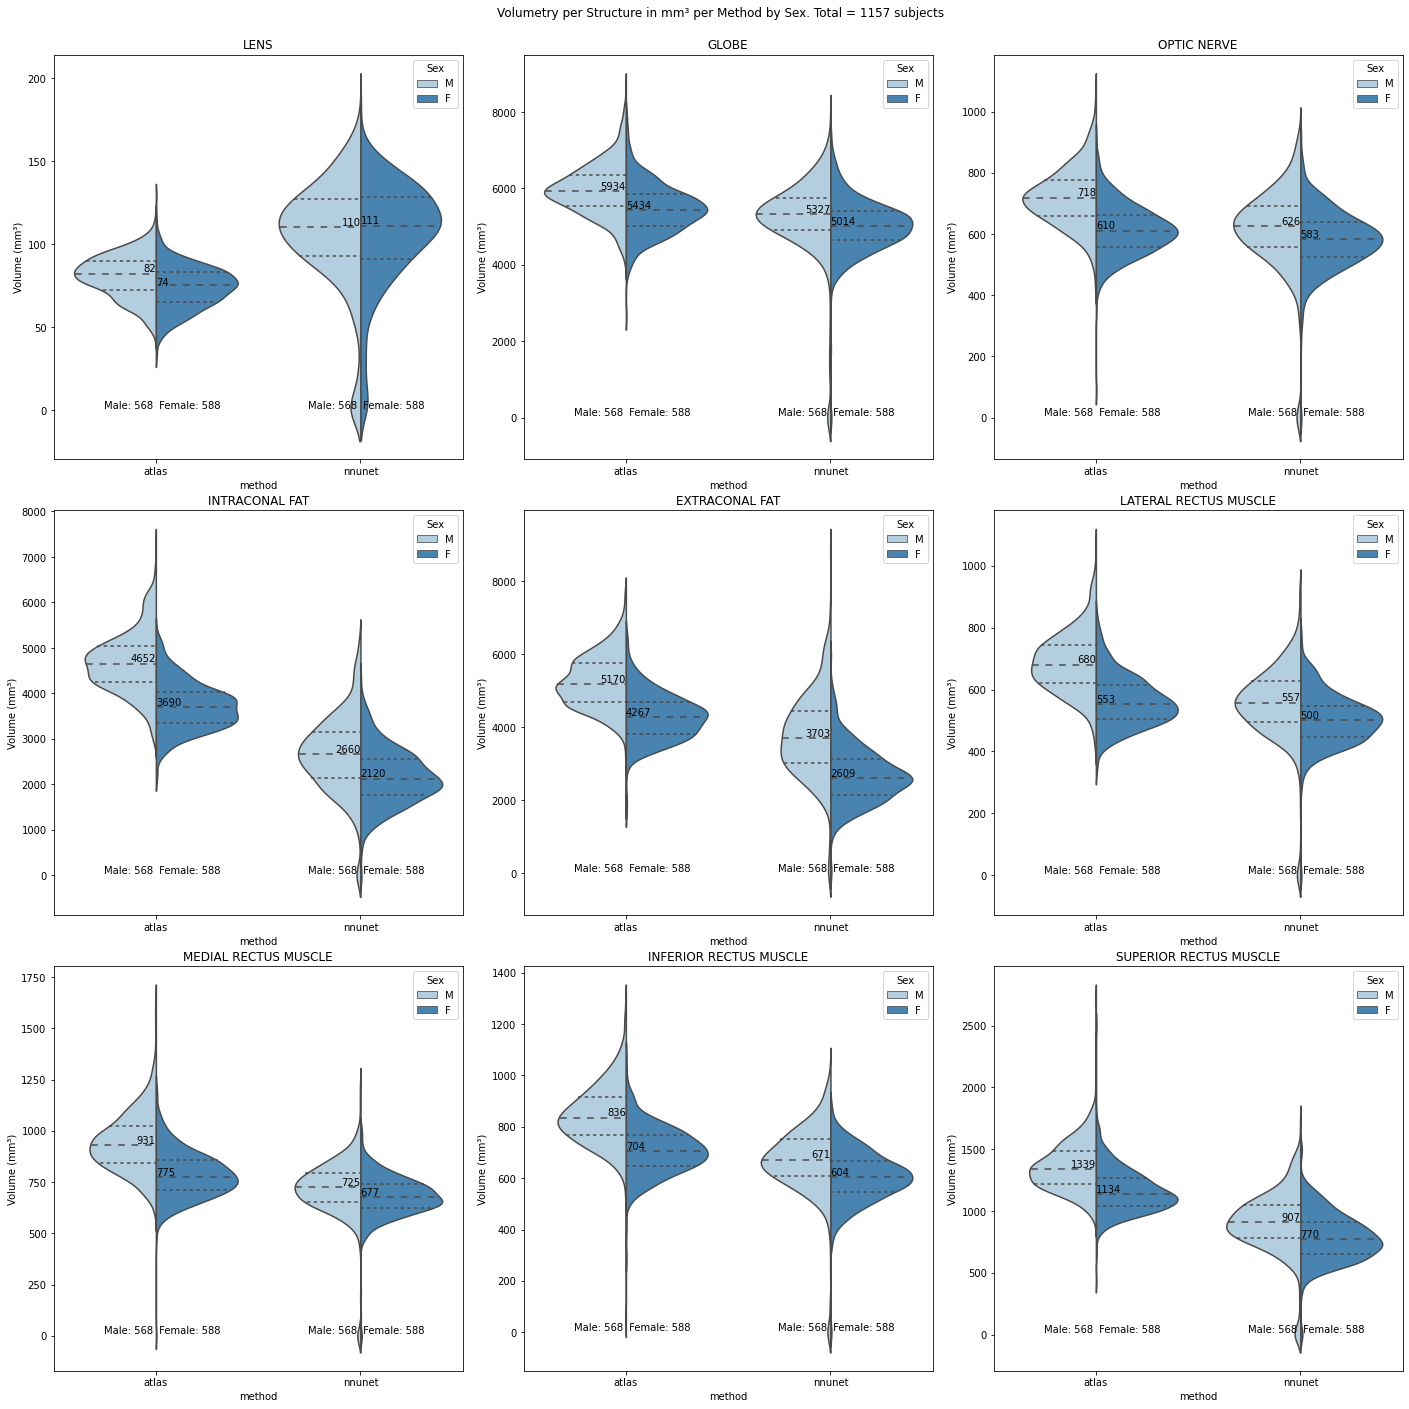

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns

# Subplots
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle(f'Volumetry per Structure in mm³ per Method by Sex. Total = {len(pd_volumes_nnunet)} subjects')
fig.patch.set_facecolor('white')

# Legend
# legend_elements = [Line2D([0], [0], color='lightskyblue', lw=2, label='ATLAS'),
#     Line2D([0], [0], color='steelblue', lw=2, label='nnUNet')]
# fig.legend(handles=legend_elements, loc='upper right')
fig.tight_layout(pad=3)

# Color
# palette with 'lightskyblue' and 'steelblue'
palette = sns.color_palette("Blues", 2)

# lens
ax[0][0].set_title("LENS")
graph = sns.violinplot(data=df_vol_lens, x="method", y="vol_lens", ax=ax[0][0], hue='Sex' , split=True, inner='quart', palette=palette)
graph.set_ylabel('Volume (mm³)')
graph.text(0, df_vol_lens['vol_lens'].min(), f'Male: {len(vol_lens_male_atlas[0])} ', ha='right', va='bottom', fontsize=10)
graph.text(0, df_vol_lens['vol_lens'].min(), f' Female: {len(vol_lens_female_atlas[0])}', ha='left', va='bottom', fontsize=10)
graph.text(1, df_vol_lens['vol_lens'].min(), f'Male: {len(vol_lens_male_nnunet[0])} ', ha='right', va='bottom', fontsize=10)
graph.text(1, df_vol_lens['vol_lens'].min(), f' Female: {len(vol_lens_female_nnunet[0])}', ha='left', va='bottom', fontsize=10)
graph.text(0, int(np.median(vol_lens_male_atlas)), f'{int(np.median(vol_lens_male_atlas))}', ha='right', va='bottom', fontsize=10)
graph.text(0, int(np.median(vol_lens_female_atlas)), f'{int(np.median(vol_lens_female_atlas))}', ha='left', va='bottom', fontsize=10)
graph.text(1, int(np.median(vol_lens_male_nnunet)), f'{int(np.median(vol_lens_male_nnunet))}', ha='right', va='bottom', fontsize=10)
graph.text(1, int(np.median(vol_lens_female_nnunet)), f'{int(np.median(vol_lens_female_nnunet))}', ha='left', va='bottom', fontsize=10)

# globe
ax[0][1].set_title("GLOBE")
graph = sns.violinplot(data=df_vol_globe, x="method", y="vol_globe", ax=ax[0][1], hue='Sex' , split=True, inner='quart', palette=palette)
graph.set_ylabel('Volume (mm³)')
graph.text(0, df_vol_globe['vol_globe'].min(), f'Male: {len(vol_globe_male_atlas[0])} ', ha='right', va='bottom', fontsize=10)
graph.text(0, df_vol_globe['vol_globe'].min(), f' Female: {len(vol_globe_female_atlas[0])}', ha='left', va='bottom', fontsize=10)
graph.text(1, df_vol_globe['vol_globe'].min(), f'Male: {len(vol_globe_male_nnunet[0])} ', ha='right', va='bottom', fontsize=10)
graph.text(1, df_vol_globe['vol_globe'].min(), f' Female: {len(vol_globe_female_nnunet[0])}', ha='left', va='bottom', fontsize=10)
graph.text(0, int(np.median(vol_globe_male_atlas)), f'{int(np.median(vol_globe_male_atlas))}', ha='right', va='bottom', fontsize=10)
graph.text(0, int(np.median(vol_globe_female_atlas)), f'{int(np.median(vol_globe_female_atlas))}', ha='left', va='bottom', fontsize=10)
graph.text(1, int(np.median(vol_globe_male_nnunet)), f'{int(np.median(vol_globe_male_nnunet))}', ha='right', va='bottom', fontsize=10)
graph.text(1, int(np.median(vol_globe_female_nnunet)), f'{int(np.median(vol_globe_female_nnunet))}', ha='left', va='bottom', fontsize=10)

# nerve
ax[0][2].set_title("OPTIC NERVE")
graph = sns.violinplot(data=df_vol_nerve, x="method", y="vol_nerve", ax=ax[0][2], hue='Sex' , split=True, inner='quart', palette=palette)
graph.set_ylabel('Volume (mm³)')
graph.text(0, df_vol_nerve['vol_nerve'].min(), f'Male: {len(vol_nerve_male_atlas[0])} ', ha='right', va='bottom', fontsize=10)
graph.text(0, df_vol_nerve['vol_nerve'].min(), f' Female: {len(vol_nerve_female_atlas[0])}', ha='left', va='bottom', fontsize=10)
graph.text(1, df_vol_nerve['vol_nerve'].min(), f'Male: {len(vol_nerve_male_nnunet[0])} ', ha='right', va='bottom', fontsize=10)
graph.text(1, df_vol_nerve['vol_nerve'].min(), f' Female: {len(vol_nerve_female_nnunet[0])}', ha='left', va='bottom', fontsize=10)
graph.text(0, int(np.median(vol_nerve_male_atlas)), f'{int(np.median(vol_nerve_male_atlas))}', ha='right', va='bottom', fontsize=10)
graph.text(0, int(np.median(vol_nerve_female_atlas)), f'{int(np.median(vol_nerve_female_atlas))}', ha='left', va='bottom', fontsize=10)
graph.text(1, int(np.median(vol_nerve_male_nnunet)), f'{int(np.median(vol_nerve_male_nnunet))}', ha='right', va='bottom', fontsize=10)
graph.text(1, int(np.median(vol_nerve_female_nnunet)), f'{int(np.median(vol_nerve_female_nnunet))}', ha='left', va='bottom', fontsize=10)

# int_fat
ax[1][0].set_title("INTRACONAL FAT")
graph = sns.violinplot(data=df_vol_int_fat, x="method", y="vol_int_fat", ax=ax[1][0], hue='Sex' , split=True, inner='quart', palette=palette)
graph.set_ylabel('Volume (mm³)')
graph.text(0, df_vol_int_fat['vol_int_fat'].min(), f'Male: {len(vol_lens_male_atlas[0])} ', ha='right', va='bottom', fontsize=10)
graph.text(0, df_vol_int_fat['vol_int_fat'].min(), f' Female: {len(vol_lens_female_atlas[0])}', ha='left', va='bottom', fontsize=10)
graph.text(1, df_vol_int_fat['vol_int_fat'].min(), f'Male: {len(vol_lens_male_nnunet[0])} ', ha='right', va='bottom', fontsize=10)
graph.text(1, df_vol_int_fat['vol_int_fat'].min(), f' Female: {len(vol_lens_female_nnunet[0])}', ha='left', va='bottom', fontsize=10)
graph.text(0, int(np.median(vol_int_fat_male_atlas)), f'{int(np.median(vol_int_fat_male_atlas))}', ha='right', va='bottom', fontsize=10)
graph.text(0, int(np.median(vol_int_fat_female_atlas)), f'{int(np.median(vol_int_fat_female_atlas))}', ha='left', va='bottom', fontsize=10)
graph.text(1, int(np.median(vol_int_fat_male_nnunet)), f'{int(np.median(vol_int_fat_male_nnunet))}', ha='right', va='bottom', fontsize=10)
graph.text(1, int(np.median(vol_int_fat_female_nnunet)), f'{int(np.median(vol_int_fat_female_nnunet))}', ha='left', va='bottom', fontsize=10)

# ext_fat
ax[1][1].set_title("EXTRACONAL FAT")
graph = sns.violinplot(data=df_vol_ext_fat, x="method", y="vol_ext_fat", ax=ax[1][1], hue='Sex' , split=True, inner='quart', palette=palette)
graph.set_ylabel('Volume (mm³)')
graph.text(0, df_vol_ext_fat['vol_ext_fat'].min(), f'Male: {len(vol_lens_male_atlas[0])} ', ha='right', va='bottom', fontsize=10)
graph.text(0, df_vol_ext_fat['vol_ext_fat'].min(), f' Female: {len(vol_lens_female_atlas[0])}', ha='left', va='bottom', fontsize=10)
graph.text(1, df_vol_ext_fat['vol_ext_fat'].min(), f'Male: {len(vol_lens_male_nnunet[0])} ', ha='right', va='bottom', fontsize=10)
graph.text(1, df_vol_ext_fat['vol_ext_fat'].min(), f' Female: {len(vol_lens_female_nnunet[0])}', ha='left', va='bottom', fontsize=10)
graph.text(0, int(np.median(vol_ext_fat_male_atlas)), f'{int(np.median(vol_ext_fat_male_atlas))}', ha='right', va='bottom', fontsize=10)
graph.text(0, int(np.median(vol_ext_fat_female_atlas)), f'{int(np.median(vol_ext_fat_female_atlas))}', ha='left', va='bottom', fontsize=10)
graph.text(1, int(np.median(vol_ext_fat_male_nnunet)), f'{int(np.median(vol_ext_fat_male_nnunet))}', ha='right', va='bottom', fontsize=10)
graph.text(1, int(np.median(vol_ext_fat_female_nnunet)), f'{int(np.median(vol_ext_fat_female_nnunet))}', ha='left', va='bottom', fontsize=10)

# lat_mus
ax[1][2].set_title("LATERAL RECTUS MUSCLE")
graph = sns.violinplot(data=df_vol_lat_mus, x="method", y="vol_lat_mus", ax=ax[1][2], hue='Sex' , split=True, inner='quart', palette=palette)
graph.set_ylabel('Volume (mm³)')
graph.text(0, df_vol_lat_mus['vol_lat_mus'].min(), f'Male: {len(vol_lens_male_atlas[0])} ', ha='right', va='bottom', fontsize=10)
graph.text(0, df_vol_lat_mus['vol_lat_mus'].min(), f' Female: {len(vol_lens_female_atlas[0])}', ha='left', va='bottom', fontsize=10)
graph.text(1, df_vol_lat_mus['vol_lat_mus'].min(), f'Male: {len(vol_lens_male_nnunet[0])} ', ha='right', va='bottom', fontsize=10)
graph.text(1, df_vol_lat_mus['vol_lat_mus'].min(), f' Female: {len(vol_lens_female_nnunet[0])}', ha='left', va='bottom', fontsize=10)
graph.text(0, int(np.median(vol_lat_mus_male_atlas)), f'{int(np.median(vol_lat_mus_male_atlas))}', ha='right', va='bottom', fontsize=10)
graph.text(0, int(np.median(vol_lat_mus_female_atlas)), f'{int(np.median(vol_lat_mus_female_atlas))}', ha='left', va='bottom', fontsize=10)
graph.text(1, int(np.median(vol_lat_mus_male_nnunet)), f'{int(np.median(vol_lat_mus_male_nnunet))}', ha='right', va='bottom', fontsize=10)
graph.text(1, int(np.median(vol_lat_mus_female_nnunet)), f'{int(np.median(vol_lat_mus_female_nnunet))}', ha='left', va='bottom', fontsize=10)

# med_mus
ax[2][0].set_title("MEDIAL RECTUS MUSCLE")
graph = sns.violinplot(data=df_vol_med_mus, x="method", y="vol_med_mus", ax=ax[2][0], hue='Sex' , split=True, inner='quart', palette=palette)
graph.set_ylabel('Volume (mm³)')
graph.text(0, df_vol_med_mus['vol_med_mus'].min(), f'Male: {len(vol_lens_male_atlas[0])} ', ha='right', va='bottom', fontsize=10)
graph.text(0, df_vol_med_mus['vol_med_mus'].min(), f' Female: {len(vol_lens_female_atlas[0])}', ha='left', va='bottom', fontsize=10)
graph.text(1, df_vol_med_mus['vol_med_mus'].min(), f'Male: {len(vol_lens_male_nnunet[0])} ', ha='right', va='bottom', fontsize=10)
graph.text(1, df_vol_med_mus['vol_med_mus'].min(), f' Female: {len(vol_lens_female_nnunet[0])}', ha='left', va='bottom', fontsize=10)
graph.text(0, int(np.median(vol_med_mus_male_atlas)), f'{int(np.median(vol_med_mus_male_atlas))}', ha='right', va='bottom', fontsize=10)
graph.text(0, int(np.median(vol_med_mus_female_atlas)), f'{int(np.median(vol_med_mus_female_atlas))}', ha='left', va='bottom', fontsize=10)
graph.text(1, int(np.median(vol_med_mus_male_nnunet)), f'{int(np.median(vol_med_mus_male_nnunet))}', ha='right', va='bottom', fontsize=10)
graph.text(1, int(np.median(vol_med_mus_female_nnunet)), f'{int(np.median(vol_med_mus_female_nnunet))}', ha='left', va='bottom', fontsize=10)

# inf_mus
ax[2][1].set_title("INFERIOR RECTUS MUSCLE")
graph = sns.violinplot(data=df_vol_inf_mus, x="method", y="vol_inf_mus", ax=ax[2][1], hue='Sex' , split=True, inner='quart', palette=palette)
graph.set_ylabel('Volume (mm³)')
graph.text(0, df_vol_inf_mus['vol_inf_mus'].min(), f'Male: {len(vol_lens_male_atlas[0])} ', ha='right', va='bottom', fontsize=10)
graph.text(0, df_vol_inf_mus['vol_inf_mus'].min(), f' Female: {len(vol_lens_female_atlas[0])}', ha='left', va='bottom', fontsize=10)
graph.text(1, df_vol_inf_mus['vol_inf_mus'].min(), f'Male: {len(vol_lens_male_nnunet[0])} ', ha='right', va='bottom', fontsize=10)
graph.text(1, df_vol_inf_mus['vol_inf_mus'].min(), f' Female: {len(vol_lens_female_nnunet[0])}', ha='left', va='bottom', fontsize=10)
graph.text(0, int(np.median(vol_inf_mus_male_atlas)), f'{int(np.median(vol_inf_mus_male_atlas))}', ha='right', va='bottom', fontsize=10)
graph.text(0, int(np.median(vol_inf_mus_female_atlas)), f'{int(np.median(vol_inf_mus_female_atlas))}', ha='left', va='bottom', fontsize=10)
graph.text(1, int(np.median(vol_inf_mus_male_nnunet)), f'{int(np.median(vol_inf_mus_male_nnunet))}', ha='right', va='bottom', fontsize=10)
graph.text(1, int(np.median(vol_inf_mus_female_nnunet)), f'{int(np.median(vol_inf_mus_female_nnunet))}', ha='left', va='bottom', fontsize=10)

# sup_mus
ax[2][2].set_title("SUPERIOR RECTUS MUSCLE")
graph = sns.violinplot(data=df_vol_sup_mus, x="method", y="vol_sup_mus", ax=ax[2][2], hue='Sex' , split=True, inner='quart', palette=palette)
graph.set_ylabel('Volume (mm³)')
graph.text(0, df_vol_sup_mus['vol_sup_mus'].min(), f'Male: {len(vol_lens_male_atlas[0])} ', ha='right', va='bottom', fontsize=10)
graph.text(0, df_vol_sup_mus['vol_sup_mus'].min(), f' Female: {len(vol_lens_female_atlas[0])}', ha='left', va='bottom', fontsize=10)
graph.text(1, df_vol_sup_mus['vol_sup_mus'].min(), f'Male: {len(vol_lens_male_nnunet[0])} ', ha='right', va='bottom', fontsize=10)
graph.text(1, df_vol_sup_mus['vol_sup_mus'].min(), f' Female: {len(vol_lens_female_nnunet[0])}', ha='left', va='bottom', fontsize=10)
graph.text(0, int(np.median(vol_sup_mus_male_atlas)), f'{int(np.median(vol_sup_mus_male_atlas))}', ha='right', va='bottom', fontsize=10)
graph.text(0, int(np.median(vol_sup_mus_female_atlas)), f'{int(np.median(vol_sup_mus_female_atlas))}', ha='left', va='bottom', fontsize=10)
graph.text(1, int(np.median(vol_sup_mus_male_nnunet)), f'{int(np.median(vol_sup_mus_male_nnunet))}', ha='right', va='bottom', fontsize=10)
graph.text(1, int(np.median(vol_sup_mus_female_nnunet)), f'{int(np.median(vol_sup_mus_female_nnunet))}', ha='left', va='bottom', fontsize=10)

plt.show()

Save figure

In [ ]:
# save figure as .png
fig.savefig('/mnt/sda1/Repos/a-eye/Output/volumetry/atlas_nnunet_sex_raw_text_right_eye_qc1_qc2_qc3.png', dpi=300, bbox_inches='tight')

### Outliers

In [ ]:
import pandas as pd

# csv_file = pd.read_csv('/mnt/sda1/Repos/a-eye/Output/volumetry/atlas/volumes_reg_total_qc1_qc2.csv')
csv_file = pd.read_csv('/mnt/sda1/Repos/a-eye/Output/volumetry/nnunet/volumes_nnunet_right_eye_qc1_qc2.csv')

Normality test

In [ ]:
# Shapiro-Wilk test for normality for each column of csv_file
from scipy.stats import shapiro
from matplotlib import pyplot as plt

for i in range(1, len(csv_file.columns)):
    stat, p = shapiro(csv_file.iloc[:,i])
    print(f'{csv_file.columns[i]}: Statistics={stat}, p={p}')
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
    # histogram plot
    plt.hist(csv_file.iloc[:,i])
    plt.show()

Outliers IQR

In [ ]:
outliers_df1 = pd.DataFrame(columns=['Column', 'Outlier Subject'])
bounds_df = pd.DataFrame(columns=['Column', 'Lower Bound', 'Upper Bound']) # dataFrame for bounds

# Calculate the IQR for each column
Q1 = csv_file.quantile(0.25)
Q3 = csv_file.quantile(0.75)
IQR = Q3 - Q1

# Find the outliers for each column
for column in csv_file.columns[1:]:
    lower_bound = Q1[column] - 1.5 * IQR[column]
    upper_bound = Q3[column] + 1.5 * IQR[column]

    # Append bounds to the bounds_df DataFrame
    new_row = pd.DataFrame({'Column': [column], 'Lower Bound': [lower_bound], 'Upper Bound': [upper_bound]})
    bounds_df = pd.concat([bounds_df, new_row], ignore_index=True)

    column_outliers = csv_file[(csv_file[column] < lower_bound) | (csv_file[column] > upper_bound)]
    new_row = pd.DataFrame({'Column': [column], 'Outlier Subject': [column_outliers['Subject'].values]})
    outliers_df1 = pd.concat([outliers_df1, new_row], ignore_index=True)

In [ ]:
# Initialize a new DataFrame with the same structure as csv_file but filled with False
outliers_df2 = pd.DataFrame(False, index=csv_file.index, columns=csv_file.columns)

# Copy the 'Subject' column from csv_file to outliers_df
outliers_df2['Subject'] = csv_file['Subject']

# Calculate the IQR for each column excluding 'Subject'
Q1 = csv_file.drop('Subject', axis=1).quantile(0.25)
Q3 = csv_file.drop('Subject', axis=1).quantile(0.75)
IQR = Q3 - Q1

# Find the outliers for each column excluding 'Subject'
for column in csv_file.columns:
    if column != 'Subject':
        lower_bound = Q1[column] - 1.5 * IQR[column]
        upper_bound = Q3[column] + 1.5 * IQR[column]
        # Update outliers_df with True for outliers
        outliers_df2[column] = (csv_file[column] < lower_bound) | (csv_file[column] > upper_bound)

# Replace all False values with ''
outliers_df2 = outliers_df2.replace(False, '')

In [ ]:
from collections import Counter

# make a list of 'Outlier Subject' without duplicates in row and column
outliers_list = []
for i in range(len(outliers_df1)):
    for j in range(len(outliers_df1.iloc[i,1])):
        outliers_list.append(outliers_df1.iloc[i,1][j])

# Count the occurrences of each outlier
outliers_counter = Counter(outliers_list)

# Keep only the outliers that appear more than once
outliers_list = [item for item, count in outliers_counter.items() if count > 1]

outliers_list = list(sorted(set(outliers_list)))

Reports to look at - removing already analysed subjects from atlas qc3

In [ ]:
import pandas as pd

qc3_vol_atlas = pd.read_excel("/home/jaimebarranco/Desktop/MRI-QC/qc3_vol_atlas.xlsx")

In [ ]:
import pandas as pd

df_aux = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/df_aux.csv")

# subdataframe of df_aux with the outliers_list
outliers_reports_df = df_aux[df_aux['subject'].isin(outliers_list)]
# add 'my_rate' column to outliers_reports_df
outliers_reports_df.loc[:, 'my_rate'] = 0.0
# order outliers_reports_df by 'report'
outliers_reports_df = outliers_reports_df.sort_values(by=['report'])
# remove subjects from outliers_reports_df that are in qc3_atlas - useful to view the non-repeated reports
outliers_reports_df = outliers_reports_df[~outliers_reports_df['subject'].isin(qc3_vol_atlas['subject'])]
# add column 'comments' to outliers_reports_df
outliers_reports_df.loc[:, 'comments'] = ''

In [ ]:
# copy reports that appear in outliers_reports from /home/jaimebarranco/Desktop/MRI-QC/fetal/fetalqc_non-labeled-dataset to /home/jaimebarranco/Downloads/reports 
import shutil
import os

reports_folder = '/home/jaimebarranco/Downloads/reports/'
# create reports folder if it doesn't exist
if not os.path.exists(reports_folder):
    os.makedirs(reports_folder)
else:
    # remove content from reports folder
    for filename in os.listdir(reports_folder):
        file_path = os.path.join(reports_folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

for report in outliers_reports_df['report']:
    src = f'/home/jaimebarranco/Desktop/MRI-QC/fetal/fetalqc_non-labeled-dataset/{report}_report.html'
    dst = f'/home/jaimebarranco/Downloads/reports/{report}_report.html'
    shutil.copy(src, dst)

Joint outliers (atlas + nnunet)

In [ ]:
import pandas as pd

qc3_atlas = pd.read_excel("/home/jaimebarranco/Desktop/MRI-QC/qc3_vol_atlas.xlsx")
qc3_nnunet = pd.read_excel("/home/jaimebarranco/Desktop/MRI-QC/qc3_vol_nnunet.xlsx")

# joint dataframes
qc3 = pd.concat([qc3_atlas, qc3_nnunet], ignore_index=True)
# keep only the rows with '0' in my_rate column
qc3 = qc3[qc3['my_rate'] == 0]
# save it to .csv
qc3.to_csv("/home/jaimebarranco/Desktop/MRI-QC/qc3_vol.csv", index=False)

## Axial length

### regionprops + line 2D

In [ ]:
import os, glob
from pathlib import Path
import numpy as np
import nibabel as nb
from skimage.measure import regionprops, label
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import math
from skimage import filters

METHOD = 'reg' # reg, dl, manual, nnunet

# Paths - segmentation results
if METHOD=='reg':
    main_path = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/'
    input_path = main_path + 'non_labeled_dataset_nifti_reg_2/'
    input_path_ima = main_path + 'non_labeled_dataset_nifti_cropped/'
    output_path = '/mnt/sda1/Repos/a-eye/Output/axial_length/atlas/'
elif METHOD=='dl':
    main_path = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/'
    input_path = main_path + 'test_orig_reg-cropped_non-labeled/'
elif METHOD=='manual':
    input_path = "/home/jaimebarranco/Desktop/new_manual_annotations/segmentations/manual_74/"
    input_path_ima = "/home/jaimebarranco/Desktop/new_manual_annotations/images/images_74/"
    output_path = '/mnt/sda1/Repos/a-eye/Output/axial_length/manual/'
elif METHOD=='nnunet': 
    input_path = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/deep_learning/nnUNet/nnUNet/nnUNet_inference/non_labeled_dataset_nifti_nnunet/'
    lab_path = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/deep_learning/nnUNet/nnUNet/nnUNet_inference/no_postprocessing/'
    output_path = '/mnt/sda1/Repos/a-eye/Output/axial_length/nnunet/'

# List of volumes for each individual label and subject
len_path = len([elem for elem in os.listdir(input_path)])
name_subject = [""]*len_path
axial_length_total = np.zeros(len_path)
outliers_list_1 = list() # condition 1
outliers_list_2 = list() # condition 2
outliers_list_3 = list() # condition 3
outliers_list_4 = list() # condition 4
outliers_dict_2 = {}
outliers_dict_3 = {}
outliers_dict_4 = {}
list_results = sorted(os.listdir(input_path))
arr_diff = []

i=0
for folder1 in list_results:
    # if folder1 == '2022160100265.nii.gz': # uncomment for concrete subject
    # if folder1 == 'AEye_2022160100285_0000.nii.gz': # for nnunet

        # Subject's name
        if METHOD=='dl': name_subject[i] = folder1.split('_')[0]
        elif METHOD=='nnunet': name_subject[i] = folder1.split('_')[1]
        else: name_subject[i] = str(folder1) # reg, manual
        print(f'subject: {name_subject[i]}')

        # Load image in array format
        if METHOD=='reg':
            lab = nb.load(f'{input_path}{folder1}/labels.nii.gz')
            lab_arr = lab.get_fdata() # labels matrix
            voxel_size = lab.header.get_zooms() # voxel size
            ima = nb.load(f'{input_path_ima}{folder1}_cropped.nii.gz')
            ima_arr = ima.get_fdata() # image matrix
        elif METHOD=='dl':
            lab = nb.load(f'{input_path}{folder1}')
            lab_arr = lab.get_fdata() # labels matrix
            voxel_size = lab.header.get_zooms() # voxel size
        elif METHOD=='manual':
            lab = nb.load(f'{input_path}{folder1}')
            lab_arr = lab.get_fdata() # labels matrix
            voxel_size = lab.header.get_zooms() # voxel size
            ima = nb.load(f'{input_path_ima}{folder1}')
            ima_arr = ima.get_fdata() # image matrix
        elif METHOD=='nnunet':
            lab = nb.load(f'{lab_path}AEye_{name_subject[i]}.nii.gz')
            lab_arr = lab.get_fdata() # labels matrix
            voxel_size = lab.header.get_zooms() # voxel size
            ima = nb.load(f'{input_path}{folder1}')
            ima_arr = ima.get_fdata() # image matrix
        
        # Label masks
        lens = (lab_arr==1)*1
        globe = (lab_arr==2)*1
        eyeball = (np.logical_or(lab_arr==1, lab_arr==2))*1 # *1 to convert it to int instead of bool
        nerve = (lab_arr==3)*1
        # Condition 1: there must be lens, nerve or globe segmentation
        if np.count_nonzero(lens)==0 or np.count_nonzero(nerve)==0 or np.count_nonzero(globe)==0: # condition 1
            axial_length_total[i] = 0
            outliers_list_1.append(name_subject[i]) # outliers with no lens segmented
            outliers_list1_clean = list(dict.fromkeys(outliers_list_2)) # to remove duplicates from list
            print(f'Final axial length: {axial_length_total[i]}mm \n')
        else:
            # LENS CENTROID
            properties_lens = regionprops(lens) # properties
            com_lens = (np.rint(properties_lens[0].centroid)).astype(int) # centroid
            print(f'com_lens: {np.around(com_lens)}')

            # EYEBALL CENTROID
            properties_eyeball = regionprops(eyeball) # properties
            com_eyeball = (np.rint(properties_eyeball[0].centroid)).astype(int) # centroid
            print(f'com_eyeball: {np.around(com_eyeball)}')
            
            # OPTIC NERVE CENTROID
            properties_nerve = regionprops(nerve) # properties
            com_nerve = (np.rint(properties_nerve[0].centroid)).astype(int) # centroid
            print(f'com_nerve: {np.around(com_nerve)}')

            # Compute best centroid
            if com_lens[2] == com_nerve[2]:
                slices = np.array([com_lens[2]])
            else:
                if com_lens[2] < com_nerve[2]:
                    slices = np.arange(com_lens[2], com_nerve[2]+1, 1, dtype=int)
                else: 
                    slices = np.arange(com_lens[2], com_nerve[2]-1, -1, dtype=int)
            print(f'slices: {slices} \n')

            # Save variables per slice
            axial_length_slices = np.zeros(len(slices))
            lens_vox = np.zeros(len(slices))
            globe_vox = np.zeros(len(slices))
            nerve_vox = np.zeros(len(slices))
            int_fat_vox = np.zeros(len(slices))

            # Compute axial length per slice
            p = -1
            for s in slices:
                p+=1
                lens_vox[p] = np.count_nonzero(lab_arr[:, :, s]==1)
                globe_vox[p] = np.count_nonzero(lab_arr[:, :, s]==2)
                nerve_vox[p] = np.count_nonzero(lab_arr[:, :, s]==3)
                int_fat_vox[p] = np.count_nonzero(lab_arr[:, :, s]==4)
                print(f'slice {s} -- voxels -- lens: {int(lens_vox[p])} | nerve: {int(nerve_vox[p])} | int fat: {int(int_fat_vox[p])} | globe: {int(globe_vox[p])}')

                # Label masks
                lens_2d = (lab_arr[:, :, s]==1)*1
                globe_2d = (lab_arr[:, :, s]==2)*1
                nerve_2d = (lab_arr[:, :, s]==3)*1
                int_fat_2d = (lab_arr[:, :, s]==4)*1
                lens_vox_2d = np.count_nonzero(lens_2d)
                globe_vox_2d = np.count_nonzero(globe_2d)
                nerve_vox_2d = np.count_nonzero(nerve_2d)
                int_fat_vox_2d = np.count_nonzero(int_fat_2d)
                if METHOD=='nnunet':
                    lens_2d_q = lens_2d[int(np.around(lens_2d.shape[0]/2)):lens_2d.shape[0], int(np.around(lens_2d.shape[1]/2)):lens_2d.shape[1]] # quadrant right eye
                    globe_2d_q = globe_2d[int(np.around(globe_2d.shape[0]/2)):globe_2d.shape[0], int(np.around(globe_2d.shape[1]/2)):globe_2d.shape[1]] # quadrant right eye
                    nerve_2d_q = nerve_2d[int(np.around(nerve_2d.shape[0]/2)):nerve_2d.shape[0], int(np.around(nerve_2d.shape[1]/2)):nerve_2d.shape[1]] # quadrant right eye
                    int_fat_2d_q = int_fat_2d[int(np.around(int_fat_2d.shape[0]/2)):int_fat_2d.shape[0], int(np.around(int_fat_2d.shape[1]/2)):int_fat_2d.shape[1]] # quadrant right eye
                    lens_vox_2d = np.count_nonzero(lens_2d_q)
                    globe_vox_2d = np.count_nonzero(globe_2d_q)
                    nerve_vox_2d = np.count_nonzero(nerve_2d_q)
                    int_fat_vox_2d = np.count_nonzero(int_fat_2d_q)
                    print(f'```````````right eye: lens: {lens_vox_2d} | nerve: {nerve_vox_2d} | int fat: {int_fat_vox_2d} | globe: {globe_vox_2d}')

                # Centroid of the lens in the 2D slice in axial view
                # Condition 2
                # Check first if there are voxels of all the structures below in the upper right quadrant (only for nnunet)
                if lens_vox_2d > 0 and nerve_vox_2d > 0 and int_fat_vox_2d > 0 and globe_vox_2d > 0:
                    properties_lens = regionprops(lens_2d)
                    com_lens = properties_lens[0].centroid # centroid
                    if METHOD=='nnunet':
                        properties_lens = regionprops(lens_2d_q) # upper right quadrant
                        com_lens = properties_lens[0].centroid # centroid
                        com_lens = [com_lens[0]+lens_2d.shape[0]/2, com_lens[1]+lens_2d.shape[1]/2] # centroid amplified to entire image
                    print(f'com_lens: {np.around(com_lens)}')
                    axis_minor_lens = properties_lens[0].axis_minor_length # minor axis
                    axis_major_lens = properties_lens[0].axis_major_length # major axis
                    print(f'axis minor lens = {axis_minor_lens} \naxis major lens = {axis_major_lens}')

                    # Get the 2nd point of the orthogonal in the lens
                    x0_lens = com_lens[0]
                    y0_lens = com_lens[1]
                    x1_lens = x0_lens
                    y1_lens = y0_lens - 1 # orthogonal to the globe (following y axis: orientation y=1, z=slice)

                    # Parametric equation of the line between (x0, y0) and (x1, y1)
                    n_points = int(np.ceil(math.dist([0,0,0], [lab_arr.shape[0], lab_arr.shape[1], lab_arr.shape[2]]))) # max number of points of a line in the image square
                    t = np.linspace(-int(n_points), int(n_points), n_points*10) # resolution of the line
                    line_x = (x0_lens - x1_lens)*t + x0_lens
                    line_y = (y0_lens - y1_lens)*t + y0_lens

                    # Line in image space (square)
                    line = np.zeros([lab_arr.shape[0], lab_arr.shape[1]])
                    for j in range(len(t)):
                        if 0<=round(line_x[j])<lab_arr.shape[0] and 0<=round(line_y[j])<lab_arr.shape[1] :
                            line[int(np.around(line_x[j])), int(np.around(line_y[j]))] = 1
                    print(f'Number of points of the line in the image space: {np.count_nonzero(line)}')

                    # Intersections and extreme points
                    # Lens
                    # inter_lens = np.logical_and(lens[:, :, int(np.around(com_eyeball[2]))], line)*1 # int format, intersection points in lens with line
                    inter_lens = np.logical_and(lens_2d, line)*1 # int format, intersection points in lens with line
                    print(f'Number of intersection points in lens: {np.count_nonzero(inter_lens)}')
                    # Condition 3: there must be intersection points between the line and the lens
                    if np.count_nonzero(inter_lens) > 0: # condition 3
                        inter_coord_lens = np.argwhere(inter_lens==1)
                        extreme_inter_lens = inter_coord_lens[np.argmax(inter_coord_lens[:,1])]
                        print(f'Lens extreme intersection point: {extreme_inter_lens}')
                        # Globe
                        # inter_globe = np.logical_and(globe[:, :, int(np.around(com_eyeball[2]))], line)*1 # int format, intersection points in globe with line
                        inter_globe = np.logical_and(globe_2d, line)*1 # int format, intersection points in globe with line
                        print(f'Number of instersection points in globe: {np.count_nonzero(inter_globe)}')
                        inter_coord_globe = np.argwhere(inter_globe==1)
                        extreme_inter_globe = inter_coord_globe[np.argmin(inter_coord_globe[:,1])]
                        print(f'Globe extreme intersection point: {extreme_inter_globe}')

                        # Line to compute the intensities gradient
                        sobel = True
                        if sobel:
                            edges = filters.sobel(ima_arr[:, :, s]) # Sobel
                            grad_arr = edges[extreme_inter_lens[0], extreme_inter_lens[1]:lab_arr.shape[1]-1] # Sobel
                        else:
                            grad_arr = ima_arr[extreme_inter_lens[0], extreme_inter_lens[1]:lab_arr.shape[1]-1, s]
                        print(f'grad_arr = {grad_arr}')
                        vox = 0
                        n_drops = 0
                        if len(grad_arr) >= 1:
                            for v in range(len(grad_arr)):
                                next_val = grad_arr[v+1] if v != len(grad_arr)-1 else 3000
                                diff = next_val - grad_arr[v]
                                if sobel:
                                    threshold = 96.17 # np.mean(arr_diff) for 100 cases (95.28 for 1210 cases)
                                    if diff < threshold: # Sobel
                                        if n_drops > 0: # 2nd drop
                                            arr_diff.append(diff)
                                            break
                                        else:
                                            vox+=1
                                            n_drops+=1
                                    else:
                                        vox+=1
                                else:
                                    threshold = 179.92 # np.mean(arr_diff) for 100 cases
                                    if (diff > 0 and next_val >= 100) or (diff <= threshold and diff >= 0):
                                        vox += 1
                                    else:
                                        arr_diff.append(diff)
                                        break
                        print(f'Number of mm to add to the axial length (due to the cornea) = {vox}')

                        # Extra distance 2 (towards globe direction until reaching intraconal fat)
                        grad_arr2 = lab_arr[extreme_inter_globe[0], np.arange(extreme_inter_globe[1]-1, 0, -1), s]
                        print(f'grad_arr2 = {grad_arr2}')
                        vox2 = 0
                        if len(grad_arr2) > 0 and np.count_nonzero(grad_arr2 == 4) > 0 :
                            for w in range(len(grad_arr2)):
                                if grad_arr2[w] != 4:
                                    vox2 +=1
                                else:
                                    break
                        print(f'Number of mm to add to the axial length (due to intraconal fat) = {vox2}')

                        # Axial length
                        axial_length = (extreme_inter_lens[1] + voxel_size[1]/2) - (extreme_inter_globe[1] - voxel_size[1]/2) + vox + vox2 # distance between the center of the two points, we have to add +0.5mm for each point to be the actual extremes
                        print(f'Axial length = {axial_length} mm \n')

                        if axial_length > 0: # condition 4
                            # axial_length_total[i] = axial_length
                            axial_length_slices[p] = axial_length # if best slice

                            # PLOT
                            plot_bool = 1
                            if plot_bool:
                                k = 1 # aspect ratio
                                fig, ax = plt.subplots(1, 3, figsize=(16*k, 9*k))
                                fig.patch.set_facecolor('white')
                                if METHOD == 'reg':
                                    method = 'ATLAS'
                                elif METHOD == 'nnunet':
                                    method = 'nnUNet'
                                fig.suptitle(f'Automatic axial length extraction. Method: {method}. Subject: {name_subject[i]}. Slice: {s}. Axial length: {axial_length} mm.')

                                # Legend
                                legend_elements = [Line2D([0], [0], color='y', lw=2, label=f'Axial length'),
                                    Line2D([], [], color='y', label='Extreme points', marker='+', markersize=5, linestyle='None'),
                                    Line2D([], [], color='b', label='Lens centroid', marker='+', markersize=5, linestyle='None'),
                                    Line2D([], [], color='c', label='Added distance', marker='+', markersize=5, linestyle='None')]
                                fig.legend(handles=legend_elements, loc='lower right')
                                fig.tight_layout()

                                # Lens centroid and line
                                ax[0].set_title('Original image')
                                ax[0].imshow(ima_arr[:, :, s].T, origin='lower', cmap='gist_gray', interpolation='none')
                                # Note the inverted coordinates because plt uses (x, y) while NumPy uses (row, column)
                                ax[0].plot(int(np.around(com_lens[0])), int(np.around(com_lens[1])), '+b', markersize=10)
                                ax[0].plot(extreme_inter_lens[0], extreme_inter_lens[1]+voxel_size[1]/2, '+y', markersize=10)
                                ax[0].plot(extreme_inter_globe[0], extreme_inter_globe[1]-voxel_size[1]/2, '+y', markersize=10)
                                ax[0].plot((extreme_inter_lens[0], extreme_inter_globe[0]), (extreme_inter_lens[1]+voxel_size[1]/2, extreme_inter_globe[1]-voxel_size[1]/2), '-y', linewidth=1)
                                # Extra distance
                                ax[0].plot(extreme_inter_lens[0], extreme_inter_lens[1]+voxel_size[1]/2+vox, '+c', markersize=10)
                                ax[0].plot((extreme_inter_lens[0], extreme_inter_lens[0]), (extreme_inter_lens[1]+voxel_size[1]/2+vox, extreme_inter_lens[1]), '-c', linewidth=1)
                                # Extra distance 2
                                ax[0].plot(extreme_inter_globe[0], extreme_inter_globe[1]-voxel_size[1]/2-vox2, '+c', markersize=10)
                                ax[0].plot((extreme_inter_globe[0], extreme_inter_globe[0]), (extreme_inter_globe[1]-voxel_size[1]/2-vox2, extreme_inter_globe[1]), '-c', linewidth=1)

                                # Eyeball
                                ax[1].set_title('Original image + labels')
                                ax[1].imshow(ima_arr[:, :, s].T, origin='lower', cmap='gist_gray', interpolation='none')
                                lens_mask = np.ma.masked_where(lens[:, :, s] == 0, lens[:, :, s])
                                globe_mask = np.ma.masked_where(globe[:, :, s] == 0, globe[:, :, s])
                                nerve_mask = np.ma.masked_where(nerve[:, :, s] == 0, nerve[:, :, s])
                                int_fat_mask = np.ma.masked_where(int_fat_2d[:, :] == 0, int_fat_2d[:, :])
                                palette_lens = colors.ListedColormap(['red'])
                                palette_globe = colors.ListedColormap(['lime'])
                                palette_nerve = colors.ListedColormap(['blue'])
                                palette_int_fat = colors.ListedColormap(['yellow'])
                                ax[1].imshow(lens_mask.T, origin='lower', interpolation='none', alpha=0.4, cmap=palette_lens)
                                ax[1].imshow(globe_mask.T, origin='lower', interpolation='none', alpha=0.4, cmap=palette_globe)
                                ax[1].imshow(nerve_mask.T, origin='lower', interpolation='none', alpha=0.4, cmap=palette_nerve)
                                ax[1].imshow(int_fat_mask.T, origin='lower', interpolation='none', alpha=0.4, cmap=palette_int_fat)
                                # Note the inverted coordinates because plt uses (x, y) while NumPy uses (row, column)
                                ax[1].plot(int(np.around(com_lens[0])), int(np.around(com_lens[1])), '+b', markersize=10)
                                ax[1].plot(extreme_inter_lens[0], extreme_inter_lens[1]+voxel_size[1]/2, '+y', markersize=10)
                                ax[1].plot(extreme_inter_globe[0], extreme_inter_globe[1]-voxel_size[1]/2, '+y', markersize=10)
                                ax[1].plot((extreme_inter_lens[0], extreme_inter_globe[0]), (extreme_inter_lens[1]+voxel_size[1]/2, extreme_inter_globe[1]-voxel_size[1]/2), '-y', linewidth=1)
                                # Extra distance
                                ax[1].plot(extreme_inter_lens[0], extreme_inter_lens[1]+voxel_size[1]/2+vox, '+c', markersize=10)
                                ax[1].plot((extreme_inter_lens[0], extreme_inter_lens[0]), (extreme_inter_lens[1]+voxel_size[1]/2+vox, extreme_inter_lens[1]), '-c', linewidth=1)
                                # Extra distance 2
                                ax[1].plot(extreme_inter_globe[0], extreme_inter_globe[1]-voxel_size[1]/2-vox2, '+c', markersize=10)
                                ax[1].plot((extreme_inter_globe[0], extreme_inter_globe[0]), (extreme_inter_globe[1]-voxel_size[1]/2-vox2, extreme_inter_globe[1]), '-c', linewidth=1)

                                # Sobel
                                edges = filters.sobel(ima_arr[:, :, s].T)
                                ax[2].set_title('Sobel filter')
                                ax[2].imshow(edges, origin='lower', cmap='gist_gray', interpolation='none')
                                lens_mask = np.ma.masked_where(lens[:, :, s] == 0, lens[:, :, s])
                                globe_mask = np.ma.masked_where(globe[:, :, s] == 0, globe[:, :, s])
                                nerve_mask = np.ma.masked_where(nerve[:, :, s] == 0, nerve[:, :, s])
                                palette_lens = colors.ListedColormap(['red'])
                                palette_globe = colors.ListedColormap(['lime'])
                                palette_nerve = colors.ListedColormap(['blue'])
                                # ax[2].imshow(lens_mask.T, origin='lower', interpolation='none', alpha=0.4, cmap=palette_lens)
                                # ax[2].imshow(globe_mask.T, origin='lower', interpolation='none', alpha=0.4, cmap=palette_globe)
                                # ax[2].imshow(nerve_mask.T, origin='lower', interpolation='none', alpha=0.4, cmap=palette_nerve)
                                # Note the inverted coordinates because plt uses (x, y) while NumPy uses (row, column)
                                # ax[2].plot(int(np.around(com_lens[0])), int(np.around(com_lens[1])), '+b', markersize=10)
                                # ax[2].plot(extreme_inter_lens[0], extreme_inter_lens[1]+voxel_size[1]/2, '+y', markersize=10)
                                # ax[2].plot(extreme_inter_globe[0], extreme_inter_globe[1]-voxel_size[1]/2, '+y', markersize=10)
                                ax[2].plot((extreme_inter_lens[0], extreme_inter_globe[0]), (extreme_inter_lens[1]+voxel_size[1]/2, extreme_inter_globe[1]-voxel_size[1]/2), '-y', linewidth=1)
                                # Extra distance
                                ax[2].plot(extreme_inter_lens[0], extreme_inter_lens[1]+voxel_size[1]/2+vox, '+c', markersize=10)
                                ax[2].plot((extreme_inter_lens[0], extreme_inter_lens[0]), (extreme_inter_lens[1]+voxel_size[1]/2+vox, extreme_inter_lens[1]), '-c', linewidth=1)
                                # Extra distance 2
                                ax[2].plot((extreme_inter_globe[0], extreme_inter_globe[0]), (extreme_inter_globe[1]-voxel_size[1]/2-vox2, extreme_inter_globe[1]), '-c', linewidth=1)
                                ax[2].plot(extreme_inter_globe[0], extreme_inter_globe[1]-voxel_size[1]/2-vox2, '+c', markersize=10)

                                plt.show

                                # plt.savefig(f'{output_path}examples/{name_subject[i]}_{s}.png')

                            # break # comment to extract all the slices in the range lens centroid - optic nerve centroid

                        else:
                            axial_length_slices[p] = 0
                            outliers_list_4.append(name_subject[i])
                            outliers_list_4_clean = list(dict.fromkeys(outliers_list_4)) # to remove duplicates from list
                            outliers_dict_4[str(name_subject[i])] = s

                    else:
                        axial_length_slices[p] = 0
                        outliers_list_3.append(name_subject[i])
                        outliers_list_3_clean = list(dict.fromkeys(outliers_list_3)) # to remove duplicates from list
                        outliers_dict_3[str(name_subject[i])] = s
                        # break

                else:
                    axial_length_slices[p] = 0
                    outliers_list_2.append(name_subject[i])
                    outliers_list2_clean = list(dict.fromkeys(outliers_list_2)) # to remove duplicates from list
                    outliers_dict_2[str(name_subject[i])] = s

            # Selecting best slice (not really good - better to allow clinician to select by him/herself)
            if np.count_nonzero(axial_length_slices) == 0:
                axial_length_total[i] = 0
            else:
                indexes_valid_slices = np.argwhere(axial_length_slices != 0)
                valid_slices = slices[indexes_valid_slices]
                filtered_lens_vox = lens_vox[axial_length_slices != 0] # from the lens values, the ones with axial length != 0
                filtered_nerve_vox = nerve_vox[axial_length_slices != 0] # from the nerve values, the ones with axial length != 0
                ratio = np.zeros(len(valid_slices)) # they all have the same length
                for k in range(len(valid_slices)): # they all have the same length
                    ratio[k] = filtered_lens_vox[k] / filtered_nerve_vox[k] if filtered_lens_vox[k] < filtered_nerve_vox[k] else filtered_nerve_vox[k] / filtered_lens_vox[k]
                best_slice_inner = np.argmax(ratio) # best slice is the one with higher ratio lens-nerve
                best_slice_outer = valid_slices[best_slice_inner] # the real slice number
                index_best_slice = np.argwhere(slices == best_slice_outer)
                print(f'--------- BEST SLICE: {best_slice_outer} ---------')
                axial_length_total[i] = axial_length_slices[index_best_slice]
            print(f'\nFinal axial length: {axial_length_total[i]}mm')

            print(f'\n')

        i+=1
        if i==5:
            break

In [ ]:
np.abs(np.mean(arr_diff))

### Save values into .csv


In [ ]:
import csv

if METHOD=='reg': filename = 'axial_length_reg_cond4_best_slice.csv'
elif METHOD=='dl': filename = 'axial_length_dl_outliers.csv'
elif METHOD=='manual': filename = 'axial_length_manual_cond4_best_slice.csv'
elif METHOD=='nnunet': filename = 'axial_length_nnunet_cond4_best_slice.csv'

column_names = ['Subject','axial_length']
vals = np.array([name_subject, axial_length_total])
vals = vals.T
with open(output_path + filename, 'w') as file:
    writer = csv.writer(file)
    writer.writerow(column_names)
    writer.writerows(vals)

### Read values from .csv

In [ ]:
from turtle import color
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np

ref_axl_mean = 24.1 # mm. Range: (21.6-27). See https://bmcophthalmol.biomedcentral.com/articles/10.1186/s12886-022-02289-y
ref_axl_std = 1.2 # mm

csv_manual = '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/axial_length_manual.csv'
csv_reg = '/mnt/sda1/Repos/a-eye/Output/axial_length/atlas/axial_length_reg_cond4_best_slice.csv'
csv_dl = '/mnt/sda1/Repos/a-eye/Output/axial_length/nnunet/axial_length_nnunet_cond4_best_slice.csv' # nnUNet

df_axial_manual = pd.read_csv(csv_manual)
df_axial_reg = pd.read_csv(csv_reg)
df_axial_dl = pd.read_csv(csv_dl)

Removing excluded subjects from qc1, qc2, qc3

In [ ]:
import pandas as pd

qc1 = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/qc1.csv")
qc2 = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/qc2_atlas_nnunet.csv")
qc3_vol = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/qc3_vol.csv")
qc3_al = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/qc3_al.csv")

# concat qc1, qc2 and qc3
qc_list = pd.concat([qc1, qc2, qc3_vol, qc3_al], ignore_index=True)

# subdataframe of pd_volumes_reg and pd_volumes_nnunet removing the subjects that are in qc1 and qc2
df_axial_reg = df_axial_reg[~df_axial_reg['Subject'].isin(qc_list['subject'])]
df_axial_reg = df_axial_reg.reset_index(drop=True)
df_axial_dl = df_axial_dl[~df_axial_dl['Subject'].isin(qc_list['subject'])]
df_axial_dl = df_axial_dl.reset_index(drop=True)

Plot

In [ ]:
# Data from .csv
axl_manual = np.array([df_axial_manual["axial_length"]])
axl_manual = axl_manual[axl_manual != 0]
axl_reg = np.array([df_axial_reg["axial_length"]])
axl_reg = axl_reg[axl_reg != 0]
axl_dl = np.array([df_axial_dl["axial_length"]])
axl_dl = axl_dl[axl_dl != 0]
print(f'MANUAL: axial length mean: {np.around(np.mean(axl_manual), 1)}, std: {np.std(axl_manual)}\n\
ATLAS-BASED: axial length mean: {np.around(np.mean(axl_reg), 1)}, std: {np.std(axl_reg)}\n\
nnUNet: axial length mean: {np.around(np.mean(axl_dl), 1)}, std: {np.std(axl_dl)}')

# Subplots
k = 1 # Figure size to preserve ratio 16:9
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Axial length (mm)')
fig.patch.set_facecolor('white')
fix_axis = 1
x_axis = [-2, 2]
y_axis = [15, 30]
fig.tight_layout(pad=2)

# Legend
legend_elements = [Line2D([0], [0], color='red', lw=2, label=f'Previous studies \nmean: {ref_axl_mean} \nstd: {ref_axl_std}'), Line2D([0], [0], color='limegreen', lw=2, label='Mean')]
fig.legend(handles=legend_elements, loc='lower right')

# # Manual
# ax[0].set_title(f'MANUAL (35 subs) - mean: {np.around(np.mean(axl_manual), decimals=1)}, std: {np.around(np.std(axl_manual), decimals=1)}')
# graph_lens = sns.boxplot(axl_manual, ax=ax[0])
# # graph_lens = sns.swarmplot(axl_manual, ax=ax[0])
# graph_lens.axhline(ref_axl_mean, color='red')
# # ax[0].set_xticklabels()
# if fix_axis:
#     # ax[0].set_xlim(x_axis)
#     ax[0].set_ylim(y_axis)

meanlineprops = dict(linestyle="-", linewidth=2, color="limegreen")
meanpointprops = {"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black", "markersize":"10"}

# ATLAS-based reg
ax[0].set_title(f'ATLAS ({len(axl_reg)} subs) - mean: {np.around(np.mean(axl_reg), decimals=1)}, std: {np.around(np.std(axl_reg), decimals=1)}')
graph_lens = sns.boxplot(data=axl_reg, ax=ax[0], meanprops=meanlineprops, showmeans=True, meanline=True)
ax[0].set(xticklabels=[])
ax[0].tick_params(bottom=False)
graph_lens.axhline(ref_axl_mean, color='red')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax[0].set_ylim(y_axis)

# Deep learning --> nnUNet
ax[1].set_title(f'nnUNet ({len(axl_dl)} subs) - mean: {np.around(np.mean(axl_dl), decimals=1)}, std: {np.around(np.std(axl_dl), decimals=1)}')
graph_lens = sns.boxplot(data=axl_dl, ax=ax[1], meanprops=meanlineprops, showmeans=True, meanline=True)
ax[1].set_xticklabels([])
ax[1].tick_params(bottom=False)
graph_lens.axhline(ref_axl_mean, color='red')
if fix_axis:
    # ax[2].set_xlim(x_axis)
    ax[1].set_ylim(y_axis)

plt.show

plt.savefig('/mnt/sda1/Repos/a-eye/Output/axial_length/axial_length_atlas_vs_nnunet_qc1_qc2_qc3.png')

### Outliers

In [ ]:
import pandas as pd

# csv_file = pd.read_csv('/mnt/sda1/Repos/a-eye/Output/axial_length/atlas/axial_length_reg_cond4_best_slice.csv')
csv_file = pd.read_csv('/mnt/sda1/Repos/a-eye/Output/axial_length/nnunet/axial_length_nnunet_cond4_best_slice.csv')

Remove qc1, qc2, qc3_vol

In [ ]:
import pandas as pd

qc1 = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/qc1.csv")
qc2 = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/qc2_atlas_nnunet.csv")
qc3_vol = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/qc3_vol.csv")

# concat qc1, qc2 and qc3_vol
qc_list = pd.concat([qc1, qc2, qc3_vol], ignore_index=True)

# subdataframe of pd_volumes_reg and pd_volumes_nnunet removing the subjects that are in qc1 and qc2
csv_file = csv_file[~csv_file['Subject'].isin(qc_list['subject'])]
csv_file = csv_file.reset_index(drop=True)

Normality test

In [ ]:
# Shapiro-Wilk test for normality for each column of csv_file
from scipy.stats import shapiro
from matplotlib import pyplot as plt

for i in range(1, len(csv_file.columns)):
    stat, p = shapiro(csv_file.iloc[:,i])
    print(f'{csv_file.columns[i]}: Statistics={stat}, p={p}')
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
    # histogram plot
    plt.hist(csv_file.iloc[:,i])
    plt.show()

Outliers IQR

In [ ]:
outliers_df1 = pd.DataFrame(columns=['Column', 'Outlier Subject'])
bounds_df = pd.DataFrame(columns=['Column', 'Lower Bound', 'Upper Bound']) # dataFrame for bounds

# Calculate the IQR for each column
Q1 = csv_file.quantile(0.25)
Q3 = csv_file.quantile(0.75)
IQR = Q3 - Q1

# Find the outliers for each column
for column in csv_file.columns[1:]:
    lower_bound = Q1[column] - 1.5 * IQR[column]
    upper_bound = Q3[column] + 1.5 * IQR[column]

    # Append bounds to the bounds_df DataFrame
    new_row = pd.DataFrame({'Column': [column], 'Lower Bound': [lower_bound], 'Upper Bound': [upper_bound]})
    bounds_df = pd.concat([bounds_df, new_row], ignore_index=True)

    column_outliers = csv_file[(csv_file[column] < lower_bound) | (csv_file[column] > upper_bound)]
    new_row = pd.DataFrame({'Column': [column], 'Outlier Subject': [column_outliers['Subject'].values]})
    outliers_df1 = pd.concat([outliers_df1, new_row], ignore_index=True)

In [ ]:
# Initialize a new DataFrame with the same structure as csv_file but filled with False
outliers_df2 = pd.DataFrame(False, index=csv_file.index, columns=csv_file.columns)

# Copy the 'Subject' column from csv_file to outliers_df
outliers_df2['Subject'] = csv_file['Subject']

# Calculate the IQR for each column excluding 'Subject'
Q1 = csv_file.drop('Subject', axis=1).quantile(0.25)
Q3 = csv_file.drop('Subject', axis=1).quantile(0.75)
IQR = Q3 - Q1

# Find the outliers for each column excluding 'Subject'
for column in csv_file.columns:
    if column != 'Subject':
        lower_bound = Q1[column] - 1.5 * IQR[column]
        upper_bound = Q3[column] + 1.5 * IQR[column]
        # Update outliers_df with True for outliers
        outliers_df2[column] = (csv_file[column] < lower_bound) | (csv_file[column] > upper_bound)

# Replace all False values with ''
outliers_df2 = outliers_df2.replace(False, '')

In [ ]:
from collections import Counter

# make a list of 'Outlier Subject' without duplicates in row and column
outliers_list = []
for i in range(len(outliers_df1)):
    for j in range(len(outliers_df1.iloc[i,1])):
        outliers_list.append(outliers_df1.iloc[i,1][j])

# Count the occurrences of each outlier
outliers_counter = Counter(outliers_list)

# Keep only the outliers that appear more than once
outliers_list = [item for item, count in outliers_counter.items() if count > 0] # there's only one column

outliers_list = list(sorted(set(outliers_list)))

Reports to look at - removing subjects already analysed

In [ ]:
import pandas as pd

df_aux = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/df_aux.csv")

qc2_atlas = pd.read_excel("/home/jaimebarranco/Desktop/MRI-QC/qc2_atlas.xlsx")
qc2_nnunet = pd.read_excel("/home/jaimebarranco/Desktop/MRI-QC/qc2_nnunet.xlsx")
qc2_atlas_nnunet = pd.read_excel("/home/jaimebarranco/Desktop/MRI-QC/qc2_atlas_nnunet.xlsx")
qc3_vol_atlas = pd.read_excel("/home/jaimebarranco/Desktop/MRI-QC/qc3_vol_atlas.xlsx")
qc3_vol_nnunet = pd.read_excel("/home/jaimebarranco/Desktop/MRI-QC/qc3_vol_nnunet.xlsx")
qc3_al_atlas = pd.read_excel("/home/jaimebarranco/Desktop/MRI-QC/qc3_al_atlas.xlsx")

In [ ]:
# concat qc2_atlas, qc2_nnunet, qc2_atlas_nnunet, qc3_vol_atlas and qc3_vol_nnunet
analysed_subjects = pd.concat([qc2_atlas, qc2_nnunet, qc2_atlas_nnunet, qc3_vol_atlas, qc3_vol_nnunet, qc3_al_atlas], ignore_index=True)
# remove duplicates
analysed_subjects = analysed_subjects.drop_duplicates(subset=['subject'], keep='first')

In [ ]:
# subdataframe of df_aux with the outliers_list
outliers_reports_df = df_aux[df_aux['subject'].isin(outliers_list)]
# add 'my_rate' column to outliers_reports_df
outliers_reports_df.loc[:, 'my_rate'] = 0.0
# order outliers_reports_df by 'report'
outliers_reports_df = outliers_reports_df.sort_values(by=['report'])
# add column 'comments' to outliers_reports_df
outliers_reports_df.loc[:, 'comments'] = ''

In [ ]:
# merge outliers_reports_df and analysed_subjects keeping 'report', 'bids', 'subject' from outliers_reports_df and 'my_rate' and 'comments' from analysed_subjects
outliers_reports_df = pd.merge(outliers_reports_df, analysed_subjects, on=['report', 'bids', 'subject'], how='left')
# remove duplicates
outliers_reports_df = outliers_reports_df.drop_duplicates(subset=['report'], keep='first')
# remove columns 'my_rate_x' and 'comments_x'
outliers_reports_df = outliers_reports_df.drop(columns=['my_rate_x', 'comments_x'])
# rename columns 'my_rate_y' and 'comments_y'
outliers_reports_df = outliers_reports_df.rename(columns={'my_rate_y': 'my_rate', 'comments_y': 'comments'})
# save to excel
# outliers_reports_df.to_excel('/home/jaimebarranco/Desktop/MRI-QC/qc3_al_nnunet.xlsx', index=False)

In [ ]:
# copy reports that appear in outliers_reports from /home/jaimebarranco/Desktop/MRI-QC/fetal/fetalqc_non-labeled-dataset to /home/jaimebarranco/Downloads/reports 
import shutil
import os

reports_folder = '/home/jaimebarranco/Downloads/reports/'
# create reports folder if it doesn't exist
if not os.path.exists(reports_folder):
    os.makedirs(reports_folder)
else:
    # remove content from reports folder
    for filename in os.listdir(reports_folder):
        file_path = os.path.join(reports_folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

filtered_reports_df = outliers_reports_df[outliers_reports_df['my_rate'] != 1]

for report in filtered_reports_df['report']:
    src = f'/home/jaimebarranco/Desktop/MRI-QC/fetal/fetalqc_non-labeled-dataset/{report}_report.html'
    dst = f'/home/jaimebarranco/Downloads/reports/{report}_report.html'
    shutil.copy(src, dst)

In [ ]:
# merge filtered_reports_df (subject) and csv_file (Subject)
filtered_reports_df = pd.merge(filtered_reports_df, csv_file, left_on=['subject'], right_on=['Subject'], how='left')
# remove 'Subject' column
filtered_reports_df = filtered_reports_df.drop(columns=['Subject'])

Joint outliers (atlas + nnunet)

In [ ]:
import pandas as pd

qc3_al_atlas = pd.read_excel("/home/jaimebarranco/Desktop/MRI-QC/qc3_al_atlas.xlsx")
qc3_al_nnunet = pd.read_excel("/home/jaimebarranco/Desktop/MRI-QC/qc3_al_nnunet.xlsx")

# joint dataframes
qc3 = pd.concat([qc3_al_atlas, qc3_al_nnunet], ignore_index=True)
# keep only the rows with '0' in my_rate column
qc3 = qc3[qc3['my_rate'] == 0]
# save it to .csv
qc3.to_csv("/home/jaimebarranco/Desktop/MRI-QC/qc3_al.csv", index=False)

### Axial length grouped by sex

In [ ]:
import pandas as pd
import numpy as np

# Paths
csv_metadata = '/mnt/sda1/Repos/a-eye/Output/metadata/sub_metadata.csv'
METHOD = 'reg' # reg, dl, manual, nnunet
if METHOD == 'reg':
    csv_axial_length = '/mnt/sda1/Repos/a-eye/Output/axial_length/atlas/axial_length_reg_cond4_best_slice.csv'
elif METHOD == 'nnunet':
    csv_axial_length = '/mnt/sda1/Repos/a-eye/Output/axial_length/nnunet/axial_length_nnunet_cond4_best_slice.csv'

# Pandas read csv
pd_metadata = pd.read_csv(csv_metadata)
pd_axial_length = pd.read_csv(csv_axial_length)

Remove subjects from qc1, qc2, qc3

In [ ]:
import pandas as pd

qc1 = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/qc1.csv")
qc2 = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/qc2_atlas_nnunet.csv")
qc3_vol = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/qc3_vol.csv")
qc3_al = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/qc3_al.csv")

# concat qc1, qc2 and qc3
qc_list = pd.concat([qc1, qc2, qc3_vol, qc3_al], ignore_index=True)

# subdataframe of pd_volumes_reg and pd_volumes_nnunet removing the subjects that are in qc1 and qc2
pd_axial_length = pd_axial_length[~pd_axial_length['Subject'].isin(qc_list['subject'])]
pd_axial_length = pd_axial_length.reset_index(drop=True)
pd_metadata = pd_metadata[~pd_metadata['Subject'].isin(qc_list['subject'])]
pd_metadata = pd_metadata.reset_index(drop=True)

Mean and std

In [ ]:
# Dataframe
df = pd.concat([pd_metadata, pd_axial_length['axial_length']], axis=1, verify_integrity=True)

# Group by sex
sex_group = df.groupby(["Sex"])

# Male group
male_group = sex_group.get_group("M").dropna()
axial_length_male = np.array([male_group["axial_length"]])
axial_length_male = axial_length_male[axial_length_male != 0]
mean_al_male = np.around(np.mean(axial_length_male), decimals=1)
std_al_male = np.around(np.std(axial_length_male), decimals=1)
print(f'- MALES: \n   Axial length: {mean_al_male} +- {std_al_male} mm')

# Female group
female_group = sex_group.get_group("F").dropna()
axial_length_female = np.array([female_group["axial_length"]])
axial_length_female = axial_length_female[axial_length_female != 0]
mean_al_female = np.around(np.mean(axial_length_female), decimals=1)
std_al_female = np.around(np.std(axial_length_female), decimals=1)
print(f'- FEMALES: \n   Axial length: {mean_al_female} +- {std_al_female} mm')

Plot

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Literature (PlosOne Sönke). See https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6366780/
ref_axl_male_mean = 23.4 # mm
ref_axl_male_std = 0.8 # mm
ref_axl_female_mean = 22.8 # mm
ref_axl_female_std = 0.9 # mm

# Subplots
k = 1 # Figure size to preserve ratio 16:9
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
if METHOD == 'reg':
    method = 'ATLAS'
elif METHOD == 'nnunet':
    method = 'nnUNet'
fig.suptitle(f'Axial length grouped by sex (mm) - {method}')
fig.patch.set_facecolor('white')
fix_axis = 1
x_axis = [-2, 2]
y_axis = [15,30]

# Legend
legend_elements = [Line2D([0], [0], color='red', lw=2, label=f'Previous studies \n Male: {ref_axl_male_mean} +- {ref_axl_male_std} mm \
    \n Female: {ref_axl_female_mean} +- {ref_axl_female_std} mm'),
    Line2D([0], [0], color='lime', lw=2, label='Mean')]
fig.legend(handles=legend_elements, loc='lower right')
meanlineprops = dict(linestyle="solid", linewidth=1.5, color="lime")
meanpointprops = {"marker":"D", "markerfacecolor":"lime", "markeredgecolor":"black", "markersize":"10"}

# MALES
ax[0].set_title(f'MALES ({len(axial_length_male)} subs) - mean: {mean_al_male}, std: {std_al_male}')
graph_lens = sns.boxplot(data=axial_length_male, ax=ax[0], meanprops=meanlineprops, meanline=True, showmeans=True)
graph_lens.axhline(ref_axl_male_mean, color='red')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax[0].set_ylim(y_axis)

# FEMALES
ax[1].set_title(f'FEMALES ({len(axial_length_female)} subs) - mean: {mean_al_female}, std: {std_al_female}')
graph_lens = sns.boxplot(data=axial_length_female, ax=ax[1], meanprops=meanlineprops, meanline=True, showmeans=True)
graph_lens.axhline(ref_axl_female_mean, color='red')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax[1].set_ylim(y_axis)

plt.show

# plt.savefig(f'/mnt/sda1/Repos/a-eye/Output/axial_length/axial_length_{method}_cond4_best_slice_qc1_qc2_qc3.png')

### Violin plots

import data

In [ ]:
import pandas as pd

# Paths
csv_metadata = '/mnt/sda1/Repos/a-eye/Output/metadata/sub_metadata.csv'
csv_al_atlas = '/mnt/sda1/Repos/a-eye/Output/axial_length/atlas/axial_length_reg_cond4_best_slice.csv'
csv_al_nnunet = '/mnt/sda1/Repos/a-eye/Output/axial_length/nnunet/axial_length_nnunet_cond4_best_slice.csv'
csv_al_manual = '/mnt/sda1/Repos/a-eye/Output/axial_length/manual/axial_length_manual_cond4_best_slice.csv'

# Pandas read csv
pd_metadata = pd.read_csv(csv_metadata)
pd_al_atlas = pd.read_csv(csv_al_atlas)
pd_al_nnunet = pd.read_csv(csv_al_nnunet)
pd_al_manual = pd.read_csv(csv_al_manual)

remove subjects from qc1, qc2, qc3

In [ ]:
import pandas as pd

qc1 = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/qc1.csv")
qc2 = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/qc2_atlas_nnunet.csv")
qc3_vol = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/qc3_vol.csv")
qc3_al = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/qc3_al.csv")

# concat qc1, qc2 and qc3
qc_list = pd.concat([qc1, qc2, qc3_vol, qc3_al], ignore_index=True)

# subdataframe of pd_volumes_reg and pd_volumes_nnunet removing the subjects that are in qc1 and qc2
pd_metadata = pd_metadata[~pd_metadata['Subject'].isin(qc_list['subject'])]
pd_metadata = pd_metadata.reset_index(drop=True)
pd_al_atlas = pd_al_atlas[~pd_al_atlas['Subject'].isin(qc_list['subject'])]
pd_al_atlas = pd_al_atlas.reset_index(drop=True)
pd_al_nnunet = pd_al_nnunet[~pd_al_nnunet['Subject'].isin(qc_list['subject'])]
pd_al_nnunet = pd_al_nnunet.reset_index(drop=True)

mixing dataframes

In [ ]:
# concat pd_metadata and pd_al_atlas
df_atlas = pd.concat([pd_metadata, pd_al_atlas['axial_length']], axis=1, verify_integrity=True)
# add column method with values 'atlas'
df_atlas['method'] = 'atlas'

# concat pd_metadata and pd_al_nnunet
df_nnunet = pd.concat([pd_metadata, pd_al_nnunet['axial_length']], axis=1, verify_integrity=True)
# add column method with values 'nnunet'
df_nnunet['method'] = 'nnunet'

# concat df_atlas and df_nnunet vertically
df = pd.concat([df_atlas, df_nnunet], axis=0, ignore_index=True)

grouped by sex

In [ ]:
# import numpy as np

# # Groups by sex
# atlas_group = df_atlas.groupby(["Sex"])
# nnunet_group = df_nnunet.groupby(["Sex"])

# # atlas male group
# atlas_male = atlas_group.get_group("M").dropna()
# al_atlas_male = np.array([atlas_male["axial_length"]])
# # al_atlas_male = al_atlas_male[al_atlas_male != 0]

# # atlas female group
# atlas_female = atlas_group.get_group("F").dropna()
# al_atlas_female = np.array([atlas_female["axial_length"]])
# # al_atlas_female = al_atlas_female[al_atlas_female != 0]

# # nnunet male group
# nnunet_male = nnunet_group.get_group("M").dropna()
# al_nnunet_male = np.array([nnunet_male["axial_length"]])
# # al_nnunet_male = al_nnunet_male[al_nnunet_male != 0]

# # nnunet female group
# nnunet_female = nnunet_group.get_group("F").dropna()
# al_nnunet_female = np.array([nnunet_female["axial_length"]])
# # al_nnunet_female = al_nnunet_female[al_nnunet_female != 0]

plot

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# Figure
plt.figure(figsize=(10,8), facecolor='white')
plt.suptitle(f'Axial Length (in mm) per Method and Sex. Total = {len(df_nnunet)} subjects')
# plt.patch.set_facecolor('white')

# Legend
# legend_elements = [Line2D([0], [0], color='lightskyblue', lw=2, label='ATLAS'),
#     Line2D([0], [0], color='steelblue', lw=2, label='nnUNet')]
# fig.legend(handles=legend_elements, loc='upper right')
plt.tight_layout(pad=3)

# Color
# palette with 'lightskyblue' and 'steelblue'
palette = sns.color_palette("Blues", 2)

# violin
sns.violinplot(data=df, x="method", y="axial_length", hue='Sex' , split=True, inner='quart', palette=palette)
plt.ylabel('Axial length (mm)')
plt.yticks(np.arange(-5, 35, 2))
# number of males and females
plt.text(0.5, df_atlas['axial_length'].min(), f'Male: {len(df_atlas[df_atlas["Sex"] == "M"])} ', ha='right', va='bottom', fontsize=10)
plt.text(0.5, df_atlas['axial_length'].min(), f' Female: {len(df_atlas[df_atlas["Sex"] == "F"])}', ha='left', va='bottom', fontsize=10)
# median values
# plt.text(0, int(np.median(al_atlas_male)), f'{int(np.median(al_atlas_male))}', ha='right', va='bottom', fontsize=10)
# plt.text(0, int(np.median(al_atlas_female)), f'{int(np.median(al_atlas_female))}', ha='left', va='bottom', fontsize=10)
# plt.text(1, int(np.median(al_nnunet_male)), f'{int(np.median(al_nnunet_male))}', ha='right', va='bottom', fontsize=10)
# plt.text(1, int(np.median(al_nnunet_female)), f'{int(np.median(al_nnunet_female))}', ha='left', va='bottom', fontsize=10)

# plt.savefig(f'/mnt/sda1/Repos/a-eye/Output/axial_length/atlas_nnunet_sex_qc1_qc2_qc3.png', dpi=300)#, bbox_inches='tight')

plt.show()

## Volumetry and BMI

Concatenate csv's and group by sex

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
# import plotly.express as px

# Concat csv in one dataframe (metadata + volumes per label)

METHOD = 'nnunet' # atlas, nnunet

# Paths
csv_metadata = '/mnt/sda1/Repos/a-eye/Output/metadata/sub_metadata.csv'
if METHOD == 'atlas':
    csv_volumes = '/mnt/sda1/Repos/a-eye/Output/volumetry/atlas/volumes_reg.csv'
elif METHOD == 'nnunet':
    csv_volumes = '/mnt/sda1/Repos/a-eye/Output/volumetry/nnunet/volumes_nnunet_right_eye.csv'

# Pandas read csv
pd_metadata = pd.read_csv(csv_metadata)
pd_volumes= pd.read_csv(csv_volumes)

# remove vol_total column (only if nnunet!!)
pd_volumes = pd_volumes.drop(columns=['vol_total'])

# Dataframe
df = pd.concat([pd_metadata, pd_volumes.iloc[:, 1:]], axis=1, verify_integrity=True)

# Group by sex (males and females)
sex_group = df.groupby(["Sex"], dropna=True)

Remove excluded subjects qc1, qc2, qc3

In [ ]:
import pandas as pd

qc1 = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/qc1.csv")
qc2 = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/qc2_atlas_nnunet.csv")
qc3_vol = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/qc3_vol.csv")
qc3_al = pd.read_csv("/home/jaimebarranco/Desktop/MRI-QC/qc3_al.csv")

# concat qc1, qc2 and qc3
qc_list = pd.concat([qc1, qc2, qc3_vol, qc3_al], ignore_index=True)

# subdataframe of pd_volumes_reg and pd_volumes_nnunet removing the subjects that are in qc1 and qc2
df = df[~df['Subject'].isin(qc_list['subject'])]
df = df.reset_index(drop=True)

# Group by sex (males and females)
sex_group = df.groupby(["Sex"], dropna=True)

### Scatter plots

Males

In [ ]:
# Male group
male_group = sex_group.get_group("M").dropna() 

# Volumes
volume_lens_male = np.array([male_group["vol_lens"]])
volume_globe_male = np.array([male_group["vol_globe"]])
volume_nerve_male = np.array([male_group["vol_nerve"]])
volume_int_fat_male = np.array([male_group["vol_int_fat"]])
volume_ext_fat_male = np.array([male_group["vol_ext_fat"]])
volume_lat_mus_male = np.array([male_group["vol_lat_mus"]])
volume_med_mus_male = np.array([male_group["vol_med_mus"]])
volume_inf_mus_male = np.array([male_group["vol_inf_mus"]])
volume_sup_mus_male = np.array([male_group["vol_sup_mus"]])

# BMI
bmi_male = np.array([male_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label

# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig1, ax1 = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig1.suptitle(f'BMI vs Volumes ({male_group.shape[0]} males)')
fig1.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Lens
ax1[0][0].set_title(f'Lens')
plot1 = sns.scatterplot(x=bmi_male.flatten(), y=volume_lens_male.flatten(), ax=ax1[0][0])
ax1[0][0].set_xlabel('BMI (kg/m²)')
ax1[0][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][0].set_ylim(y_axis)

# Globe
ax1[0][1].set_title(f'Globe')
plot2 = sns.scatterplot(x=bmi_male.flatten(), y=volume_globe_male.flatten(), ax=ax1[0][1])
ax1[0][1].set_xlabel('BMI (kg/m²)')
ax1[0][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][1].set_ylim(y_axis)

# Optic nerve
ax1[0][2].set_title(f'Optic nerve')
plot3 = sns.scatterplot(x=bmi_male.flatten(), y=volume_nerve_male.flatten(), ax=ax1[0][2])
ax1[0][2].set_xlabel('BMI (kg/m²)')
ax1[0][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][2].set_ylim(y_axis)

# Intraconal fat
ax1[0][3].set_title(f'Intraconal fat')
plot4 = sns.scatterplot(x=bmi_male.flatten(), y=volume_int_fat_male.flatten(), ax=ax1[0][3])
ax1[0][3].set_xlabel('BMI (kg/m²)')
ax1[0][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][3].set_ylim(y_axis)

# Extraconal fat
ax1[0][4].set_title(f'Extraconal fat')
plot5 = sns.scatterplot(x=bmi_male.flatten(), y=volume_ext_fat_male.flatten(), ax=ax1[0][4])
ax1[0][4].set_xlabel('BMI (kg/m²)')
ax1[0][4].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][4].set_ylim(y_axis)

# Lateral rectus muscle
ax1[1][0].set_title(f'Lateral rectus muscle')
plot6 = sns.scatterplot(x=bmi_male.flatten(), y=volume_lat_mus_male.flatten(), ax=ax1[1][0])
ax1[1][0].set_xlabel('BMI (kg/m²)')
ax1[1][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][0].set_ylim(y_axis)

# Medial rectus muscle
ax1[1][1].set_title(f'Medial rectus muscle')
plot7 = sns.scatterplot(x=bmi_male.flatten(), y=volume_med_mus_male.flatten(), ax=ax1[1][1])
ax1[1][1].set_xlabel('BMI (kg/m²)')
ax1[1][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][1].set_ylim(y_axis)

# Inferior rectus muscle
ax1[1][2].set_title(f'Inferior rectus muscle')
plot8 = sns.scatterplot(x=bmi_male.flatten(), y=volume_inf_mus_male.flatten(), ax=ax1[1][2])
ax1[1][2].set_xlabel('BMI (kg/m²)')
ax1[1][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][2].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][3].set_title(f'Superior rectus muscle')
plot8 = sns.scatterplot(x=bmi_male.flatten(), y=volume_sup_mus_male.flatten(), ax=ax1[1][3])
ax1[1][3].set_xlabel('BMI (kg/m²)')
ax1[1][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][3].set_ylim(y_axis)

plt.show()

# plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume_males_norm.png')

Females

In [ ]:
# Female group
female_group = sex_group.get_group("F").dropna() 

# Volumes
volume_lens_female = np.array([female_group["vol_lens"]])
volume_globe_female = np.array([female_group["vol_globe"]])
volume_nerve_female = np.array([female_group["vol_nerve"]])
volume_int_fat_female = np.array([female_group["vol_int_fat"]])
volume_ext_fat_female = np.array([female_group["vol_ext_fat"]])
volume_lat_mus_female = np.array([female_group["vol_lat_mus"]])
volume_med_mus_female = np.array([female_group["vol_med_mus"]])
volume_inf_mus_female = np.array([female_group["vol_inf_mus"]])
volume_sup_mus_female = np.array([female_group["vol_sup_mus"]])

# BMI
bmi_female = np.array([female_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label

# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig2, ax2 = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig2.suptitle(f'BMI vs Volumes ({female_group.shape[0]} females)')
fig2.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Lens
ax2[0][0].set_title(f'Lens')
plot1 = sns.scatterplot(x=bmi_female.flatten(), y=volume_lens_female.flatten(), ax=ax2[0][0])
ax2[0][0].set_xlabel('BMI (kg/m²)')
ax2[0][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[0][0].set_ylim(y_axis)

# Globe
ax2[0][1].set_title(f'Globe')
plot2 = sns.scatterplot(x=bmi_female.flatten(), y=volume_globe_female.flatten(), ax=ax2[0][1])
ax2[0][1].set_xlabel('BMI (kg/m²)')
ax2[0][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[0][1].set_ylim(y_axis)

# Optic nerve
ax2[0][2].set_title(f'Optic nerve')
plot3 = sns.scatterplot(x=bmi_female.flatten(), y=volume_nerve_female.flatten(), ax=ax2[0][2])
ax2[0][2].set_xlabel('BMI (kg/m²)')
ax2[0][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[0][2].set_ylim(y_axis)

# Intraconal fat
ax2[0][3].set_title(f'Intraconal fat')
plot4 = sns.scatterplot(x=bmi_female.flatten(), y=volume_int_fat_female.flatten(), ax=ax2[0][3])
ax2[0][3].set_xlabel('BMI (kg/m²)')
ax2[0][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[0][3].set_ylim(y_axis)

# Extraconal fat
ax2[0][4].set_title(f'Extraconal fat')
plot5 = sns.scatterplot(x=bmi_female.flatten(), y=volume_ext_fat_female.flatten(), ax=ax2[0][4])
ax2[0][4].set_xlabel('BMI (kg/m²)')
ax2[0][4].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[0][4].set_ylim(y_axis)

# Lateral rectus muscle
ax2[1][0].set_title(f'Lateral rectus muscle')
plot6 = sns.scatterplot(x=bmi_female.flatten(), y=volume_lat_mus_female.flatten(), ax=ax2[1][0])
ax2[1][0].set_xlabel('BMI (kg/m²)')
ax2[1][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[1][0].set_ylim(y_axis)

# Medial rectus muscle
ax2[1][1].set_title(f'Medial rectus muscle')
plot7 = sns.scatterplot(x=bmi_female.flatten(), y=volume_med_mus_female.flatten(), ax=ax2[1][1])
ax2[1][1].set_xlabel('BMI (kg/m²)')
ax2[1][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[1][1].set_ylim(y_axis)

# Inferior rectus muscle
ax2[1][2].set_title(f'Inferior rectus muscle')
plot8 = sns.scatterplot(x=bmi_female.flatten(), y=volume_inf_mus_female.flatten(), ax=ax2[1][2])
ax2[1][2].set_xlabel('BMI (kg/m²)')
ax2[1][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[1][2].set_ylim(y_axis)

# Superior rectus muscle
ax2[1][3].set_title(f'Superior rectus muscle')
plot8 = sns.scatterplot(x=bmi_female.flatten(), y=volume_sup_mus_female.flatten(), ax=ax2[1][3])
ax2[1][3].set_xlabel('BMI (kg/m²)')
ax2[1][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[1][3].set_ylim(y_axis)

plt.show

# plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume_females_norm.png')

### Check normal distribution

#### MALES

Graph

In [ ]:
# Male group
male_group = sex_group.get_group("M").dropna()

# Volumes
volume_lens_male = np.array([male_group["vol_lens"]])
volume_globe_male = np.array([male_group["vol_globe"]])
volume_nerve_male = np.array([male_group["vol_nerve"]])
volume_int_fat_male = np.array([male_group["vol_int_fat"]])
volume_ext_fat_male = np.array([male_group["vol_ext_fat"]])
volume_lat_mus_male = np.array([male_group["vol_lat_mus"]])
volume_med_mus_male = np.array([male_group["vol_med_mus"]])
volume_inf_mus_male = np.array([male_group["vol_inf_mus"]])
volume_sup_mus_male = np.array([male_group["vol_sup_mus"]])

# BMI
bmi_male = np.array([male_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label

# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig1, ax1 = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig1.suptitle(f'BMI vs Volumes ({male_group.shape[0]} males)')
fig1.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Lens
ax1[0][0].set_title(f'Lens')
plot1 = sns.distplot(volume_lens_male.flatten(), ax=ax1[0][0])
ax1[0][0].set_xlabel('Volume (mm³)')
ax1[0][0].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][0].set_ylim(y_axis)

# Globe
ax1[0][1].set_title(f'Globe')
plot2 = sns.distplot(volume_globe_male.flatten(), ax=ax1[0][1])
ax1[0][1].set_xlabel('Volume (mm³)')
ax1[0][1].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][1].set_ylim(y_axis)

# Optic nerve
ax1[0][2].set_title(f'Optic nerve')
plot3 = sns.distplot(volume_nerve_male.flatten(), ax=ax1[0][2])
ax1[0][2].set_xlabel('Volume (mm³)')
ax1[0][2].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][2].set_ylim(y_axis)

# Intraconal fat
ax1[0][3].set_title(f'Intraconal fat')
plot4 = sns.distplot(volume_int_fat_male.flatten(), ax=ax1[0][3])
ax1[0][3].set_xlabel('Volume (mm³)')
ax1[0][3].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][3].set_ylim(y_axis)

# Extraconal fat
ax1[0][4].set_title(f'Extraconal fat')
plot5 = sns.distplot(volume_ext_fat_male.flatten(), ax=ax1[0][4])
ax1[0][4].set_xlabel('Volume (mm³)')
ax1[0][4].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][4].set_ylim(y_axis)

# Lateral rectus muscle
ax1[1][0].set_title(f'Lateral rectus muscle')
plot6 = sns.distplot(volume_lat_mus_male.flatten(), ax=ax1[1][0])
ax1[1][0].set_xlabel('Volume (mm³)')
ax1[1][0].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][0].set_ylim(y_axis)

# Medial rectus muscle
ax1[1][1].set_title(f'Medial rectus muscle')
plot7 = sns.distplot(volume_med_mus_male.flatten(), ax=ax1[1][1])
ax1[1][1].set_xlabel('Volume (mm³)')
ax1[1][1].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][1].set_ylim(y_axis)

# Inferior rectus muscle
ax1[1][2].set_title(f'Inferior rectus muscle')
plot8 = sns.distplot(volume_inf_mus_male.flatten(), ax=ax1[1][2])
ax1[1][2].set_xlabel('Volume (mm³)')
ax1[1][2].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][2].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][3].set_title(f'Superior rectus muscle')
plot9 = sns.distplot(volume_sup_mus_male.flatten(), ax=ax1[1][3])
ax1[1][3].set_xlabel('Volume (mm³)')
ax1[1][3].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][3].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][4].set_title(f'BMI')
plot10 = sns.distplot(bmi_male.flatten(), ax=ax1[1][4])
ax1[1][4].set_xlabel('BMI')
ax1[1][4].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][4].set_ylim(y_axis)

plt.show()

# plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume/dist_gaussian_vol_bmi_males.png')

Shapiro-Wilk test

In [ ]:
from scipy import stats

alpha = 0.05

# LENS
statistic, p_value = stats.shapiro(volume_lens_male.flatten())
print(f"LENS \nstats = {statistic:g} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# GLOBE
statistic, p_value = stats.shapiro(volume_globe_male.flatten())
print(f"GLOBE \nstats = {statistic:g} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# OPTIC NERVE
statistic, p_value = stats.shapiro(volume_nerve_male.flatten())
print(f"OPTIC NERVE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# INTRACONAL FAT
statistic, p_value = stats.shapiro(volume_int_fat_male.flatten())
print(f"INTRACONAL FAT \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# EXTRACONAL FAT
statistic, p_value = stats.shapiro(volume_ext_fat_male.flatten())
print(f"EXTRACONAL FAT \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# LATERAL RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_lat_mus_male.flatten())
print(f"LATERAL RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# MEDIAL RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_med_mus_male.flatten())
print(f"MEDIAL RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# SUPERIOR RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_sup_mus_male.flatten())
print(f"SUPERIOR RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# INFERIOR RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_inf_mus_male.flatten())
print(f"INFERIOR RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# BMI
statistic, p_value = stats.shapiro(bmi_male.flatten())
print(f"BMI \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

#### FEMALES

Graph

In [ ]:
# Female group
female_group = sex_group.get_group("F").dropna()

# Volumes
volume_lens_female = np.array([female_group["vol_lens"]])
volume_globe_female = np.array([female_group["vol_globe"]])
volume_nerve_female = np.array([female_group["vol_nerve"]])
volume_int_fat_female = np.array([female_group["vol_int_fat"]])
volume_ext_fat_female = np.array([female_group["vol_ext_fat"]])
volume_lat_mus_female = np.array([female_group["vol_lat_mus"]])
volume_med_mus_female = np.array([female_group["vol_med_mus"]])
volume_inf_mus_female = np.array([female_group["vol_inf_mus"]])
volume_sup_mus_female = np.array([female_group["vol_sup_mus"]])

# BMI
bmi_female = np.array([female_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label

# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig1, ax1 = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig1.suptitle(f'BMI vs Volumes ({female_group.shape[0]} females)')
fig1.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Lens
ax1[0][0].set_title(f'Lens')
plot1 = sns.distplot(volume_lens_female.flatten(), ax=ax1[0][0])
ax1[0][0].set_xlabel('Volume (mm³)')
ax1[0][0].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][0].set_ylim(y_axis)

# Globe
ax1[0][1].set_title(f'Globe')
plot2 = sns.distplot(volume_globe_female.flatten(), ax=ax1[0][1])
ax1[0][1].set_xlabel('Volume (mm³)')
ax1[0][1].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][1].set_ylim(y_axis)

# Optic nerve
ax1[0][2].set_title(f'Optic nerve')
plot3 = sns.distplot(volume_nerve_female.flatten(), ax=ax1[0][2])
ax1[0][2].set_xlabel('Volume (mm³)')
ax1[0][2].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][2].set_ylim(y_axis)

# Intraconal fat
ax1[0][3].set_title(f'Intraconal fat')
plot4 = sns.distplot(volume_int_fat_female.flatten(), ax=ax1[0][3])
ax1[0][3].set_xlabel('Volume (mm³)')
ax1[0][3].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][3].set_ylim(y_axis)

# Extraconal fat
ax1[0][4].set_title(f'Extraconal fat')
plot5 = sns.distplot(volume_ext_fat_female.flatten(), ax=ax1[0][4])
ax1[0][4].set_xlabel('Volume (mm³)')
ax1[0][4].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][4].set_ylim(y_axis)

# Lateral rectus muscle
ax1[1][0].set_title(f'Lateral rectus muscle')
plot6 = sns.distplot(volume_lat_mus_female.flatten(), ax=ax1[1][0])
ax1[1][0].set_xlabel('Volume (mm³)')
ax1[1][0].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][0].set_ylim(y_axis)

# Medial rectus muscle
ax1[1][1].set_title(f'Medial rectus muscle')
plot7 = sns.distplot(volume_med_mus_female.flatten(), ax=ax1[1][1])
ax1[1][1].set_xlabel('Volume (mm³)')
ax1[1][1].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][1].set_ylim(y_axis)

# Inferior rectus muscle
ax1[1][2].set_title(f'Inferior rectus muscle')
plot8 = sns.distplot(volume_inf_mus_female.flatten(), ax=ax1[1][2])
ax1[1][2].set_xlabel('Volume (mm³)')
ax1[1][2].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][2].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][3].set_title(f'Superior rectus muscle')
plot9 = sns.distplot(volume_sup_mus_female.flatten(), ax=ax1[1][3])
ax1[1][3].set_xlabel('Volume (mm³)')
ax1[1][3].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][3].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][4].set_title(f'BMI')
plot10 = sns.distplot(bmi_female.flatten(), ax=ax1[1][4])
ax1[1][4].set_xlabel('BMI')
ax1[1][4].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][4].set_ylim(y_axis)

plt.show

# plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume/dist_gaussian_vol_bmi_females.png')

Shapiro-Wilk test

In [ ]:
from scipy import stats

alpha = 0.05

# LENS
statistic, p_value = stats.shapiro(volume_lens_female.flatten())
print(f"LENS \nstats = {statistic:g} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# GLOBE
statistic, p_value = stats.shapiro(volume_globe_female.flatten())
print(f"GLOBE \nstats = {statistic:g} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# OPTIC NERVE
statistic, p_value = stats.shapiro(volume_nerve_female.flatten())
print(f"OPTIC NERVE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# INTRACONAL FAT
statistic, p_value = stats.shapiro(volume_int_fat_female.flatten())
print(f"INTRACONAL FAT \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# EXTRACONAL FAT
statistic, p_value = stats.shapiro(volume_ext_fat_female.flatten())
print(f"EXTRACONAL FAT \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# LATERAL RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_lat_mus_female.flatten())
print(f"LATERAL RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# MEDIAL RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_med_mus_female.flatten())
print(f"MEDIAL RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# SUPERIOR RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_sup_mus_female.flatten())
print(f"SUPERIOR RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# INFERIOR RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_inf_mus_female.flatten())
print(f"INFERIOR RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# BMI
statistic, p_value = stats.shapiro(bmi_female.flatten())
print(f"BMI \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

### Linear regression

In [ ]:
train_test = 0
remove_outliers = 0
remove_zeros = 1

#### Males

Prepare data

In [ ]:
# Male group
male_group = sex_group.get_group("M").dropna() 

# # Splitting into train and test sets

# Get all the columns from the dataframe.
columns = male_group.columns.tolist()

# Filter the columns to remove ones we don't want.
columns = [c for c in columns if c not in ["index", "Subject", "Sex", "Weight", "Height", "BMI", "Age"]]
# columns = ['vol_lens']
# print([columns[0]])

# Store the variable we'll be predicting on.
target = "BMI"

# Generate the training set.  Set random_state to be able to replicate results.
if train_test:
    train = male_group.sample(frac=0.8, random_state=1)
else: train = male_group

# Select anything not in the training set and put it in the testing set.
test = male_group.loc[~male_group.index.isin(train.index)]

# Print the shapes of both sets.
print(train[columns].shape)
print(test.shape)

P values

In [ ]:
from sklearn.feature_selection import f_regression

ALPHA = 0.05
f_statistics, p_values = f_regression(train[columns], train[target]) # volumes with BMI

# print(f'p_value = {p_values}')
print(f'p_values \n Lens: {p_values[0]} \n Globe: {p_values[1]} \n Optic nerve: {p_values[2]} \n Intraconal fat: {p_values[3]} \
    \n Extraconal fat: {p_values[4]} \n Lateral rectus muscle: {p_values[5]} \n Medial rectus muscle: {p_values[6]} \
    \n Inferior rectus muscle: {p_values[7]} \n Superior rectus muscle: {p_values[8]}')

Train

In [ ]:
# Fitting a linear regression

# Import the linear models.
from sklearn import linear_model
import statsmodels.api as sma

# Initialize the model class.
model = linear_model.LinearRegression()
# model = linear_model.Ridge(alpha = 0.5)

# Fit the model to the training data.
trained_model = model.fit(train[columns], train[target])

# Model score, intercept and  slope
intercept = trained_model.intercept_
slope = trained_model.coef_
print(f'R² score = {trained_model.score(train[columns], train[target])} \nIntercept = {intercept} \nSlope = {slope}')

Test

In [ ]:
# Predicting Error

# Import the scikit-learn function to compute error. Explained variance score.
from sklearn.metrics import mean_squared_error, r2_score

if train_test:
    # Generate our predictions for the test set.
    predictions = model.predict(test[columns])

    # Compute error between our test predictions and the actual values.
    RMSE = mean_squared_error(predictions, test[target], squared=False)
    print('Root mean squared error: ', RMSE)

    # R² score
    print('Variance score (R²-score): %.2f' % r2_score(test[target], predictions))
else:
    # Generate our predictions for the test set.
    predictions = model.predict(train[columns])

    # Compute error between our test predictions and the actual values.
    RMSE = mean_squared_error(predictions, train[target], squared=False)
    print('Root mean squared error: ', RMSE)

    # R² score
    print('Variance score (R²-score): %.2f' % r2_score(train[target], predictions))

Plot

In [ ]:
# Male group
male_group = sex_group.get_group("M").dropna() 

# Volumes
volume_lens_male = np.array([male_group["vol_lens"]])
volume_globe_male = np.array([male_group["vol_globe"]])
volume_nerve_male = np.array([male_group["vol_nerve"]])
volume_int_fat_male = np.array([male_group["vol_int_fat"]])
volume_ext_fat_male = np.array([male_group["vol_ext_fat"]])
volume_lat_mus_male = np.array([male_group["vol_lat_mus"]])
volume_med_mus_male = np.array([male_group["vol_med_mus"]])
volume_inf_mus_male = np.array([male_group["vol_inf_mus"]])
volume_sup_mus_male = np.array([male_group["vol_sup_mus"]])

# BMI
bmi_male = np.array([male_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label

# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig1, ax1 = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig1.suptitle(f'BMI vs Volumes ({male_group.shape[0]} males)')
fig1.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Line per label (using intercept and slope)
def get_line_lens(x):
    return slope[0] * x + intercept
def get_line_globe(x):
    return slope[1] * x + intercept
def get_line_nerve(x):
    return slope[2] * x + intercept
def get_line_int_fat(x):
    return slope[3] * x + intercept
def get_line_ext_fat(x):
    return slope[4] * x + intercept
def get_line_lat_mus(x):
    return slope[5] * x + intercept
def get_line_med_mus(x):
    return slope[6] * x + intercept
def get_line_inf_mus(x):
    return slope[7] * x + intercept
def get_line_sup_mus(x):
    return slope[8] * x + intercept

# Lens
ax1[0][0].set_title(f'Lens')
plot1 = sns.scatterplot(x=bmi_male.flatten(), y=volume_lens_male.flatten(), ax=ax1[0][0])
line_points = list(map(get_line_lens, volume_lens_male.flatten()))
line = Line2D(line_points, volume_lens_male.flatten(), color='red')
ax1[0][0].add_line(line)
ax1[0][0].set_xlabel('BMI (kg/m²)')
ax1[0][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][0].set_ylim(y_axis)

# Globe
ax1[0][1].set_title(f'Globe')
plot2 = sns.scatterplot(x=bmi_male.flatten(), y=volume_globe_male.flatten(), ax=ax1[0][1])
line_points = list(map(get_line_globe, volume_globe_male.flatten()))
line = Line2D(line_points, volume_globe_male.flatten(), color='red')
ax1[0][1].add_line(line)
ax1[0][1].set_xlabel('BMI (kg/m²)')
ax1[0][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][1].set_ylim(y_axis)

# Optic nerve
ax1[0][2].set_title(f'Optic nerve')
plot3 = sns.scatterplot(x=bmi_male.flatten(), y=volume_nerve_male.flatten(), ax=ax1[0][2])
line_points = list(map(get_line_nerve, volume_nerve_male.flatten()))
line = Line2D(line_points, volume_nerve_male.flatten(), color='red')
ax1[0][2].add_line(line)
ax1[0][2].set_xlabel('BMI (kg/m²)')
ax1[0][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][2].set_ylim(y_axis)

# Intraconal fat
ax1[0][3].set_title(f'Intraconal fat')
plot4 = sns.scatterplot(x=bmi_male.flatten(), y=volume_int_fat_male.flatten(), ax=ax1[0][3])
line_points = list(map(get_line_int_fat, volume_int_fat_male.flatten()))
line = Line2D(line_points, volume_int_fat_male.flatten(), color='red')
ax1[0][3].add_line(line)
ax1[0][3].set_xlabel('BMI (kg/m²)')
ax1[0][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][3].set_ylim(y_axis)

# Extraconal fat
ax1[0][4].set_title(f'Extraconal fat')
plot5 = sns.scatterplot(x=bmi_male.flatten(), y=volume_ext_fat_male.flatten(), ax=ax1[0][4])
line_points = list(map(get_line_ext_fat, volume_ext_fat_male.flatten()))
line = Line2D(line_points, volume_ext_fat_male.flatten(), color='red')
ax1[0][4].add_line(line)
ax1[0][4].set_xlabel('BMI (kg/m²)')
ax1[0][4].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][4].set_ylim(y_axis)

# Lateral rectus muscle
ax1[1][0].set_title(f'Lateral rectus muscle')
plot6 = sns.scatterplot(x=bmi_male.flatten(), y=volume_lat_mus_male.flatten(), ax=ax1[1][0])
line_points = list(map(get_line_lat_mus, volume_lat_mus_male.flatten()))
line = Line2D(line_points, volume_lat_mus_male.flatten(), color='red')
ax1[1][0].add_line(line)
ax1[1][0].set_xlabel('BMI (kg/m²)')
ax1[1][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][0].set_ylim(y_axis)

# Medial rectus muscle
ax1[1][1].set_title(f'Medial rectus muscle')
plot7 = sns.scatterplot(x=bmi_male.flatten(), y=volume_med_mus_male.flatten(), ax=ax1[1][1])
line_points = list(map(get_line_med_mus, volume_med_mus_male.flatten()))
line = Line2D(line_points, volume_med_mus_male.flatten(), color='red')
ax1[1][1].add_line(line)
ax1[1][1].set_xlabel('BMI (kg/m²)')
ax1[1][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][1].set_ylim(y_axis)

# Inferior rectus muscle
ax1[1][2].set_title(f'Inferior rectus muscle')
plot8 = sns.scatterplot(x=bmi_male.flatten(), y=volume_inf_mus_male.flatten(), ax=ax1[1][2])
line_points = list(map(get_line_inf_mus, volume_inf_mus_male.flatten()))
line = Line2D(line_points, volume_inf_mus_male.flatten(), color='red')
ax1[1][2].add_line(line)
ax1[1][2].set_xlabel('BMI (kg/m²)')
ax1[1][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][2].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][3].set_title(f'Superior rectus muscle')
plot8 = sns.scatterplot(x=bmi_male.flatten(), y=volume_sup_mus_male.flatten(), ax=ax1[1][3])
line_points = list(map(get_line_sup_mus, volume_sup_mus_male.flatten()))
line = Line2D(line_points, volume_sup_mus_male.flatten(), color='red')
ax1[1][3].add_line(line)
ax1[1][3].set_xlabel('BMI (kg/m²)')
ax1[1][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][3].set_ylim(y_axis)

plt.show()

# plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume_males_norm.png')

Plot predictions

In [ ]:
# Plot outputs
if train_test:
    plt.scatter(test[target], predictions,  color='red')
else:
    plt.scatter(train[target], predictions, color='red')

plt.show()

Linear regression per label

In [ ]:
from sklearn.feature_selection import f_regression
# Import the linear models.
from sklearn.linear_model import LinearRegression, HuberRegressor
import statsmodels.api as sma
# Import the scikit-learn function to compute error. Explained variance score.
from sklearn.metrics import mean_squared_error, r2_score
# Correlations
from scipy import stats

# Male group
male_group = sex_group.get_group("M").dropna()
print('MALES \n')

# Get all the columns from the dataframe.
columns = male_group.columns.tolist()

# Filter the columns to remove ones we don't want.
columns = [c for c in columns if c not in ["index", "Subject", "Sex", "Weight", "Height", "BMI", "Age"]]
# print([columns[0]])

# Store the variable we'll be predicting on.
target = "BMI"

# Generate the training set.  Set random_state to be able to replicate results.
if train_test:
    train = male_group.sample(frac=0.8, random_state=1)
else: train = male_group

# Select anything not in the training set and put it in the testing set.
test = male_group.loc[~male_group.index.isin(train.index)]

# Print the shapes of both sets.
print(f'Train shape: {train[columns].shape}')
print(f'Test shape: {test.shape} \n')

ALPHA = 0.05 # for the p values
# model = linear_model.LinearRegression() # linear model for the regression

# List labels
list_labels = ['Lens', 'Globe', 'Optic nerve', 'Intraconal fat', 'Extraconal fat', 'Lateral rectus muscle', 'Medial rectus muscle',
    'Inferior rectus muscle', 'Superior rectus muscle']

# Volumes
volume_lens_male = np.array([male_group["vol_lens"]])
volume_globe_male = np.array([male_group["vol_globe"]])
volume_nerve_male = np.array([male_group["vol_nerve"]])
volume_int_fat_male = np.array([male_group["vol_int_fat"]])
volume_ext_fat_male = np.array([male_group["vol_ext_fat"]])
volume_lat_mus_male = np.array([male_group["vol_lat_mus"]])
volume_med_mus_male = np.array([male_group["vol_med_mus"]])
volume_inf_mus_male = np.array([male_group["vol_inf_mus"]])
volume_sup_mus_male = np.array([male_group["vol_sup_mus"]])
volumes_male_list = np.array([volume_lens_male, volume_globe_male, volume_nerve_male, volume_int_fat_male, volume_ext_fat_male,
    volume_lat_mus_male, volume_med_mus_male, volume_inf_mus_male, volume_sup_mus_male])

# BMI
bmi_male = np.array([male_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label
# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig = plt.figure(figsize=(20, 20))
fig.patch.set_facecolor('white')
fig.tight_layout()
# plt.subplots_adjust(hspace=0.5)
plt.suptitle(f'BMI vs Volumes ({male_group.shape[0]} males) - {METHOD}')
fix_axis = False
# x_axis = [-2, 2]
y_axis = [0, 9000]
# Legend
# legend_elements = [Line2D([], [], color='red', lw=2, label=f'Huber regressor')] #Line2D([], [], color='green', label='Linear regressor')
# fig.legend(handles=legend_elements, loc='upper right')
color_arr = ['tab:red','lime','tab:blue','yellow','cyan','magenta','lightgray','tab:purple','chocolate']

for n, c in enumerate(columns):

    print(list_labels[n])

    # print(train[c].shape)
    # print(train[target].shape)

    # 2D array having predictor and target
    arr = np.array([train[c], train[target]]).T # predictor, target
    print(f'Shape before removing outliers = {arr.shape}')

    # Remove zeros
    if remove_zeros == True:
        # Vol
        arr = arr[arr[:,0] != 0]
        print(f'Shape after removing zeros = {arr.shape}')

    # Huber regressor
    huber = HuberRegressor().fit(arr[:,0].reshape(-1, 1), arr[:,1])
    huber_score = huber.score(arr[:,0].reshape(-1, 1), arr[:,1])
    predictions = huber.predict(arr[:,0].reshape(-1, 1))
    slope_huber = huber.coef_
    intercept_huber = huber.intercept_
    print(f'Slope Huber = {slope_huber} \nIntercept Huber = {intercept_huber} \nHuber score (R² score) = {huber_score}')

    # Linear regression
    result = stats.linregress(arr)
    slope_linear = result.slope
    intercept_linear = result.intercept
    r_value = result.rvalue
    p_value = result.pvalue
    stderr = result.stderr
    print(f'Slope linear= {slope_linear} \nIntercept linear = {intercept_linear} \nR value (Pearson) = {r_value} \nP value = {p_value} \nStderr = {stderr} \n')

    # Line per label (using intercept and slope)
    def get_line_huber(x):
        return slope_huber * x + intercept_huber
    def get_line_linear(x):
        return slope_linear * x + intercept_linear

    # Plot
    ax = plt.subplot(3, 3, n+1) # add a new subplot iteratively
    sns.scatterplot(y=arr[:,1], x=arr[:,0], ax=ax, color=color_arr[n])
    line_points_huber = list(map(get_line_huber, arr[:,0]))
    line_huber = Line2D(arr[:,0], line_points_huber, color='grey')
    line_points_linear = list(map(get_line_linear, arr[:,0]))
    line_linear= Line2D(arr[:,0], line_points_linear, color='green')
    # if huber_score > 0.3:
    ax.add_line(line_huber)
        # ax.add_line(line_linear)
    # Title and axis labels
    ax.set_title(list_labels[n])
    ax.set_ylabel('BMI (kg/m²)')
    ax.set_xlabel('Volume (mm³)')
    # Legend
    values_legend = [f'y = {slope_huber[0]:f}*x + {intercept_huber:.2f}\n r = {huber_score:f}']
    ax.legend(values_legend, loc='upper right')
    # Axis
    if fix_axis:
        # ax.set_xlim(x_axis)
        ax.set_ylim(y_axis)

filename = 'bmi_vs_volume_males_linear_regression_outliers_mean' if remove_outliers else f'{METHOD}_bmi_vs_volume_males_huber_regression_qc1_qc2_qc3'
plt.savefig(f'/mnt/sda1/Repos/a-eye/Output/volumetry_vs_bmi/{filename}_inv.png')

In [ ]:
arr[:,0].shape

#### Females

Prepare data

In [ ]:
# Female group
female_group = sex_group.get_group("F").dropna() 

# # Splitting into train and test sets

# Get all the columns from the dataframe.
columns = female_group.columns.tolist()

# Filter the columns to remove ones we don't want.
columns = [c for c in columns if c not in ["index", "Subject", "Sex", "Weight", "Height", "BMI"]]

# Store the variable we'll be predicting on.
target = "BMI"

# Generate the training set.  Set random_state to be able to replicate results.
if train_test:
    train = female_group.sample(frac=0.8, random_state=1)
else: train = female_group    

# Select anything not in the training set and put it in the testing set.
test = female_group.loc[~female_group.index.isin(train.index)]

# Print the shapes of both sets.
print(train.shape)
print(test.shape)

P values

In [ ]:
from sklearn.feature_selection import f_regression

ALPHA = 0.05
f_statistics, p_values = f_regression(train[columns], train[target]) # volumes with BMI

print(f'p_values \n Lens: {p_values[0]} \n Globe: {p_values[1]} \n Optic nerve: {p_values[2]} \n Intraconal fat: {p_values[3]} \
    \n Extraconal fat: {p_values[4]} \n Lateral rectus muscle: {p_values[5]} \n Medial rectus muscle: {p_values[6]} \
    \n Inferior rectus muscle: {p_values[7]} \n Superior rectus muscle: {p_values[8]}')

Train

In [ ]:
# Fitting a linear regression

# Import the linear models.
from sklearn import linear_model
import statsmodels.api as sma

# Initialize the model class.
model = linear_model.LinearRegression()
# model = linear_model.Ridge(alpha = 0.5)

# Fit the model to the training data.
trained_model = model.fit(train[columns], train[target])

# Model score, intercept and  slope
intercept = trained_model.intercept_
slope = trained_model.coef_
print(f'R² score = {trained_model.score(train[columns], train[target])} \nIntercept = {intercept} \nSlope = {slope}')

Test

In [ ]:
# Predicting Error

# Import the scikit-learn function to compute error. Explained variance score.
from sklearn.metrics import mean_squared_error, r2_score

if train_test:
    # Generate our predictions for the test set.
    predictions = model.predict(test[columns])

    # Compute error between our test predictions and the actual values.
    RMSE = mean_squared_error(predictions, test[target], squared=False)
    print('Root mean squared error: ', RMSE)

    # R² score
    print('Variance score (R²-score): %.2f' % r2_score(test[target], predictions))
else:
    # Generate our predictions for the test set.
    predictions = model.predict(train[columns])

    # Compute error between our test predictions and the actual values.
    RMSE = mean_squared_error(predictions, train[target], squared=False)
    print('Root mean squared error: ', RMSE)

    # R² score
    print('Variance score (R²-score): %.2f' % r2_score(train[target], predictions))

Plot

In [ ]:
# Female group
female_group = sex_group.get_group("F").dropna() 

# Volumes
volume_lens_female = np.array([female_group["vol_lens"]])
volume_globe_female = np.array([female_group["vol_globe"]])
volume_nerve_female = np.array([female_group["vol_nerve"]])
volume_int_fat_female = np.array([female_group["vol_int_fat"]])
volume_ext_fat_female = np.array([female_group["vol_ext_fat"]])
volume_lat_mus_female = np.array([female_group["vol_lat_mus"]])
volume_med_mus_female = np.array([female_group["vol_med_mus"]])
volume_inf_mus_female = np.array([female_group["vol_inf_mus"]])
volume_sup_mus_female = np.array([female_group["vol_sup_mus"]])

# BMI
bmi_female = np.array([female_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label

# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig1, ax1 = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig1.suptitle(f'BMI vs Volumes ({female_group.shape[0]} females)')
fig1.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Line per label (using intercept and slope)
def get_line_lens(x):
    return slope[0] * x + intercept
def get_line_globe(x):
    return slope[1] * x + intercept
def get_line_nerve(x):
    return slope[2] * x + intercept
def get_line_int_fat(x):
    return slope[3] * x + intercept
def get_line_ext_fat(x):
    return slope[4] * x + intercept
def get_line_lat_mus(x):
    return slope[5] * x + intercept
def get_line_med_mus(x):
    return slope[6] * x + intercept
def get_line_inf_mus(x):
    return slope[7] * x + intercept
def get_line_sup_mus(x):
    return slope[8] * x + intercept

# Lens
ax1[0][0].set_title(f'Lens')
plot1 = sns.scatterplot(x=bmi_female.flatten(), y=volume_lens_female.flatten(), ax=ax1[0][0])
line_points = list(map(get_line_lens, volume_lens_female.flatten()))
line = Line2D(line_points, volume_lens_female.flatten(), color='red')
ax1[0][0].add_line(line)
ax1[0][0].set_xlabel('BMI (kg/m²)')
ax1[0][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][0].set_ylim(y_axis)

# Globe
ax1[0][1].set_title(f'Globe')
plot2 = sns.scatterplot(x=bmi_female.flatten(), y=volume_globe_female.flatten(), ax=ax1[0][1])
line_points = list(map(get_line_globe, volume_globe_female.flatten()))
line = Line2D(line_points, volume_globe_female.flatten(), color='red')
ax1[0][1].add_line(line)
ax1[0][1].set_xlabel('BMI (kg/m²)')
ax1[0][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][1].set_ylim(y_axis)

# Optic nerve
ax1[0][2].set_title(f'Optic nerve')
plot3 = sns.scatterplot(x=bmi_female.flatten(), y=volume_nerve_female.flatten(), ax=ax1[0][2])
line_points = list(map(get_line_nerve, volume_nerve_female.flatten()))
line = Line2D(line_points, volume_nerve_female.flatten(), color='red')
ax1[0][2].add_line(line)
ax1[0][2].set_xlabel('BMI (kg/m²)')
ax1[0][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][2].set_ylim(y_axis)

# Intraconal fat
ax1[0][3].set_title(f'Intraconal fat')
plot4 = sns.scatterplot(x=bmi_female.flatten(), y=volume_int_fat_female.flatten(), ax=ax1[0][3])
line_points = list(map(get_line_int_fat, volume_int_fat_female.flatten()))
line = Line2D(line_points, volume_int_fat_female.flatten(), color='red')
ax1[0][3].add_line(line)
ax1[0][3].set_xlabel('BMI (kg/m²)')
ax1[0][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][3].set_ylim(y_axis)

# Extraconal fat
ax1[0][4].set_title(f'Extraconal fat')
plot5 = sns.scatterplot(x=bmi_female.flatten(), y=volume_ext_fat_female.flatten(), ax=ax1[0][4])
line_points = list(map(get_line_ext_fat, volume_ext_fat_female.flatten()))
line = Line2D(line_points, volume_ext_fat_female.flatten(), color='red')
ax1[0][4].add_line(line)
ax1[0][4].set_xlabel('BMI (kg/m²)')
ax1[0][4].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][4].set_ylim(y_axis)

# Lateral rectus muscle
ax1[1][0].set_title(f'Lateral rectus muscle')
plot6 = sns.scatterplot(x=bmi_female.flatten(), y=volume_lat_mus_female.flatten(), ax=ax1[1][0])
line_points = list(map(get_line_lat_mus, volume_lat_mus_female.flatten()))
line = Line2D(line_points, volume_lat_mus_female.flatten(), color='red')
ax1[1][0].add_line(line)
ax1[1][0].set_xlabel('BMI (kg/m²)')
ax1[1][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][0].set_ylim(y_axis)

# Medial rectus muscle
ax1[1][1].set_title(f'Medial rectus muscle')
plot7 = sns.scatterplot(x=bmi_female.flatten(), y=volume_med_mus_female.flatten(), ax=ax1[1][1])
line_points = list(map(get_line_med_mus, volume_med_mus_female.flatten()))
line = Line2D(line_points, volume_med_mus_female.flatten(), color='red')
ax1[1][1].add_line(line)
ax1[1][1].set_xlabel('BMI (kg/m²)')
ax1[1][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][1].set_ylim(y_axis)

# Inferior rectus muscle
ax1[1][2].set_title(f'Inferior rectus muscle')
plot8 = sns.scatterplot(x=bmi_female.flatten(), y=volume_inf_mus_female.flatten(), ax=ax1[1][2])
line_points = list(map(get_line_inf_mus, volume_inf_mus_female.flatten()))
line = Line2D(line_points, volume_inf_mus_female.flatten(), color='red')
ax1[1][2].add_line(line)
ax1[1][2].set_xlabel('BMI (kg/m²)')
ax1[1][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][2].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][3].set_title(f'Superior rectus muscle')
plot8 = sns.scatterplot(x=bmi_female.flatten(), y=volume_sup_mus_female.flatten(), ax=ax1[1][3])
line_points = list(map(get_line_sup_mus, volume_sup_mus_female.flatten()))
line = Line2D(line_points, volume_sup_mus_female.flatten(), color='red')
ax1[1][3].add_line(line)
ax1[1][3].set_xlabel('BMI (kg/m²)')
ax1[1][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][3].set_ylim(y_axis)

plt.show()

# plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume_males_norm.png')

Plot predictions

In [ ]:
# Plot outputs
if train_test:
    plt.scatter(test[target], predictions,  color='red')
else:
    plt.scatter(train[target], predictions, color='red')

plt.show()

Linear regression per label

In [ ]:
from sklearn.feature_selection import f_regression
# Import the linear models.
from sklearn import linear_model
import statsmodels.api as sma
# Import the scikit-learn function to compute error. Explained variance score.
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

# Female group
female_group = sex_group.get_group("F").dropna() 
print('FEMALES \n')

# Get all the columns from the dataframe.
columns = female_group.columns.tolist()

# Filter the columns to remove ones we don't want.
columns = [c for c in columns if c not in ["index", "Subject", "Sex", "Weight", "Height", "BMI", "Age"]]
# print([columns[0]])

# Store the variable we'll be predicting on.
target = "BMI"

# Generate the training set.  Set random_state to be able to replicate results.
if train_test:
    train = female_group.sample(frac=0.8, random_state=1)
else: train = female_group

# Select anything not in the training set and put it in the testing set.
test = female_group.loc[~female_group.index.isin(train.index)]

# Print the shapes of both sets.
print(f'Train shape: {train[columns].shape}')
print(f'Test shape: {test.shape} \n')

ALPHA = 0.05 # for the p values
model = linear_model.LinearRegression() # linear model for the regression

# List labels
list_labels = ['Lens', 'Globe', 'Optic nerve', 'Intraconal fat', 'Extraconal fat', 'Lateral rectus muscle', 'Medial rectus muscle',
    'Inferior rectus muscle', 'Superior rectus muscle']

# Volumes
volume_lens_female = np.array([female_group["vol_lens"]])
volume_globe_female = np.array([female_group["vol_globe"]])
volume_nerve_female = np.array([female_group["vol_nerve"]])
volume_int_fat_female = np.array([female_group["vol_int_fat"]])
volume_ext_fat_female = np.array([female_group["vol_ext_fat"]])
volume_lat_mus_female = np.array([female_group["vol_lat_mus"]])
volume_med_mus_female = np.array([female_group["vol_med_mus"]])
volume_inf_mus_female = np.array([female_group["vol_inf_mus"]])
volume_sup_mus_female = np.array([female_group["vol_sup_mus"]])
volumes_female_list = np.array([volume_lens_female, volume_globe_female, volume_nerve_female, volume_int_fat_female, volume_ext_fat_female,
    volume_lat_mus_female, volume_med_mus_female, volume_inf_mus_female, volume_sup_mus_female])

# BMI
bmi_female = np.array([female_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label
# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig = plt.figure(figsize=(20, 20))
fig.patch.set_facecolor('white')
fig.tight_layout()
# plt.subplots_adjust(hspace=0.5)
plt.suptitle(f'BMI vs Volumes ({female_group.shape[0]} females) - {METHOD}')
fix_axis = False
# x_axis = [-2, 2]
y_axis = [0, 9000]
# Legend
# legend_elements = [Line2D([], [], color='red', lw=2, label=f'Huber regressor')] #Line2D([], [], color='green', label='Linear regressor')
# fig.legend(handles=legend_elements, loc='upper right')
color_arr = ['tab:red','lime','tab:blue','yellow','cyan','magenta','lightgray','tab:purple','chocolate','lightseagreen']

for n, c in enumerate(columns):

    print(list_labels[n])

    # print(train[c].shape)
    # print(train[target].shape)

    # 2D array having predictor and target
    arr = np.array([train[c], train[target]]).T
    print(f'Shape before removing outliers = {arr.shape}')

    # Remove zeros
    if remove_zeros == True:
        # Vol
        arr = arr[arr[:,0] != 0]
        print(f'Shape after removing zeros = {arr.shape}')

    # Huber regressor
    huber = HuberRegressor().fit(arr[:,0].reshape(-1, 1), arr[:,1])
    huber_score = huber.score(arr[:,0].reshape(-1, 1), arr[:,1])
    predictions = huber.predict(arr[:,0].reshape(-1, 1))
    slope_huber = huber.coef_
    intercept_huber = huber.intercept_
    print(f'Slope Huber = {slope_huber} \nIntercept Huber = {intercept_huber} \nHuber score (R² score) = {huber_score}')

    # Linear regression
    result = stats.linregress(arr)
    slope_linear = result.slope
    intercept_linear = result.intercept
    r_value = result.rvalue
    p_value = result.pvalue
    stderr = result.stderr
    print(f'Slope linear= {slope_linear} \nIntercept linear = {intercept_linear} \nR value (Pearson) = {r_value} \nP value = {p_value} \nStderr = {stderr} \n')

    # Line per label (using intercept and slope)
    def get_line_huber(x):
        return slope_huber * x + intercept_huber
    def get_line_linear(x):
        return slope_linear * x + intercept_linear

    # Plot
    ax = plt.subplot(3, 3, n+1) # add a new subplot iteratively
    sns.scatterplot(y=arr[:,1], x=arr[:,0], ax=ax, color=color_arr[n])
    line_points_huber = list(map(get_line_huber, arr[:,0]))
    line_huber = Line2D(arr[:,0], line_points_huber, color='grey')
    line_points_linear = list(map(get_line_linear, arr[:,0]))
    line_linear= Line2D(arr[:,0], line_points_linear, color='green')
    # if huber_score > 0.3:
    ax.add_line(line_huber)
        # ax.add_line(line_linear)
    # Title and axis labels
    ax.set_title(list_labels[n])
    ax.set_ylabel('BMI (kg/m²)')
    ax.set_xlabel('Volume (mm³)')
    # Legend
    values_legend = [f'y = {slope_huber[0]:f}*x + {intercept_huber:.2f}\n r = {huber_score:f}']
    ax.legend(values_legend, loc='upper right')
    # Axis
    if fix_axis:
        # ax.set_xlim(x_axis)
        ax.set_ylim(y_axis)

filename = 'bmi_vs_volume_females_linear_regression_outliers_mean' if remove_outliers else f'{METHOD}_bmi_vs_volume_females_huber_regression_qc1_qc2_qc3'
plt.savefig(f'/mnt/sda1/Repos/a-eye/Output/volumetry_vs_bmi/{filename}_inv.png')